<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/EURJPY/EURJPY_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "EURJPY"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-24 11:03:12,439 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-24 11:03:12,441 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURJPY
2019-08-24 11:07:58,618 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-24 11:17:48,648 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-24 11:22:54,043 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-24 11:27:59,224 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-24 11:33:34,489 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-24 11:38:47,440 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-24 11:43:58,505 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-24 11:48:43,998 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-24 12:04:34,683 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_EURJPY__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-EURJPY__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-EURJPY to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open        High         Low       Close        Volume
Date                                                                             
2018-01-01 22:00:00  135.212997  135.296997  135.132996  135.279007   3494.590088
2018-01-01 23:00:00  135.279999  135.485992  135.169998  135.453003  11702.520508
2018-01-02 00:00:00  135.453003  135.539993  135.416000  135.470001   4992.649902
2018-01-02 01:00:00  135.468994  135.514008  135.417007  135.447998   5474.770020
2018-01-02 02:00:00  135.447006  135.459000  135.343002  135.369995   6819.540039
...                         ...         ...         ...         ...           ...
2018-12-31 17:00:00  125.702003  125.728996  125.570000  125.612000  12911.500000
2018-12-31 18:00:00  125.612999  125.636002  125.547997  125.581001   6734.790039
2018-12-31 19:00:00  125.582001  125.638000  125.568001  125.579002   4857.250000
2018-12-31 20:00:00  125.580002  125.647003  125.579002  125.615997   4612.370117
2018-12-31 21:00:00  125.614998  125.721001  125.569000  125.656998   3358.070068

[6217 rows x 5 columns]

Open         High          Low        Close         Volume
count  6217.000000  6217.000000  6217.000000  6217.000000    6217.000000
mean    130.382767   130.481796   130.282944   130.381165   10815.972656
std       2.431428     2.429240     2.432935     2.430932    4680.130859
min     124.828003   125.196999   124.617996   124.824997     410.700012
25%     128.656006   128.748001   128.563995   128.654999    8318.809570
50%     130.039993   130.134995   129.951004   130.039001   10508.259766
75%     131.701004   131.783997   131.591995   131.699005   12738.480469
max     137.404999   137.501007   137.298004   137.404999  149660.625000

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open        High         Low       Close        Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08       SMA_8      TEMA_8     TRIMA_8       WMA_8      MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2018-01-04 00:00:00  135.257004  135.354996  135.246002  135.337997   8470.860352    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  135.166672  134.033124  134.855427  135.258385  135.197970  135.127248  135.210495  135.201500  134.956185  135.179121  135.307741  135.166695  135.213386  135.179121  135.257665  135.126496              135.345382               135.179121              135.012860              135.428512               135.179121              134.929730              135.511643               135.179121              134.846599              135.594773               135.179121              134.763469  135.197970  135.273294  135.120276              135.364230               135.197970              135.031709              135.447361               135.197970              134.948578              135.530491               135.197970              134.865448   
2018-01-04 01:00:00  135.339005  135.434998  135.326996  135.367996   7761.879883    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  135.176738  134.061714  134.885401  135.312130  135.235753  135.157437  135.225494  135.241501  134.988090  135.212246  135.362933  135.198896  135.255358  135.212246  135.352997  135.133803              135.407677               135.212246              135.016815              135.505392               135.212246              134.919100              135.603107               135.212246              134.821385              135.700823               135.212246              134.723669  135.235753  135.345711  135.130923              135.431184               135.235753              135.040323              135.528899               135.235753              134.942607              135.626614               135.235753              134.844892   
2018-01-04 02:00:00  135.367996  135.432007  135.345993

Open         High          Low        Close         Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6167.000000  6167.000000  6167.000000  6167.000000    6167.000000  6167.000000  6167.000000  6167.000000    6167.000000  6167.000000   6167.000000     6167.000000     6167.000000       6167.000000  6167.000000  6167.000000  6167.000000  6167.000000   6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000             6167.000000              6167.000000             6167.000000             6167.000000              6167.000000             6167.000000             6167.000000              6167.000000             6167.000000             6167.000000              6167.000000             6167.000000  6167.000000  6167.000000  6167.000000             6167.000000              6167.000000             6167.000000             6167.000000              6167.000000             6167.000000             6167.000000   
mean    130.343140   130.442352   130.243103   130.341507   10839.380859    15.897519     2.049781   183.861359      30.441057    11.492946      0.034214        0.972272        0.004054          0.995135     6.548889     2.520188    26.644722     2.049781      2.027566    26.644722   130.347495   130.363380     3.573414   130.341712   130.347005   130.342446   130.344928   130.343580   130.345234   130.347053   130.341639   130.347056   130.345248   130.347053   130.342797   130.357521              130.608363               130.347053              130.085742              130.739018               130.347053              129.955087              130.869673               130.347053              129.824432              131.000329               130.347053              129.693777   130.347005   130.342776   130.355968              130.608316               130.347005              130.085695              130.738971               130.347005              129.955040              130.869626   
std       2.400919     2.399130     2.402053     2.400373    4687.704102     8.724207     1.509174   103.993561       0.843621     6.922436      0.181794        0.164206        0.063546          0.069582     3.408957     1.112489    14.855945     1.509174      1.457324    14.855945     2.396461     2.385609   130.316821     2.402025     2.393247     2.399127     2.395871     2.395725     2.404641     2.395472     2.401443     2.396557     2.396226     2.395472     2.399143     2.387696                2.399105                 2.395472                2.403530                2.405296                 2.395472                2.411913                2.414376                 2.395472                2.423162                2.426314                 2.395472                2.437237     2.393247     2.398359     2.388781                2.396661                 2.393247                2.401534                2.402747                 2.393247                2.410034                2.411727   
min     124.828003   125.196999   

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.829212  0.825584  0.838170  0.835691  0.054004    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.821480  0.726414  0.991599  0.826102  0.825018  0.825092    0.826854    0.831583  0.802467  0.824025  0.831751  0.821742  0.825209  0.824025  0.828105  0.823343                0.819016                 0.824025                0.826736                0.780650                 0.824025                0.830366                0.741813                 0.824025                0.833791                0.706510                 0.824025                0.837622  0.825018  0.828684  0.822129                0.824972                 0.825018                0.830023                0.796308                 0.825018                0.833529                0.755884                 0.825018                0.836784                0.719213                 0.825018   
2018-01-04 01:00:00  0.835732  0.832086  0.844558  0.838076  0.049254    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.822321  0.728904  0.991708  0.830477  0.828157  0.827650    0.828088    0.834877  0.804943  0.826766  0.836215  0.824402  0.828678  0.826766  0.835843  0.823965                0.824177                 0.826766                0.827053                0.786734                 0.826766                0.829539                0.748706                 0.826766                0.831885                0.714139                 0.826766                0.834711  0.828157  0.834557  0.823030                0.830571                 0.828157                0.830707                0.802905                 0.828157                0.833068                0.763283                 0.828157                0.835242                0.727339                 0.828157   
2018-01-04 02:00:00  0.838037  0.831843  

140028

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2yrs9z9e
  JVM stdout: /tmp/tmp2yrs9z9e/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2yrs9z9e/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_zqcgp8
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_122034_mod...  0.747503  0.640050              0.290729  0.474280  0.224941
1  DeepLearning_grid_1_AutoML_20190824_122034_mod...  0.747335  0.618361              0.295476  0.462311  0.213732
2  DeepLearning_grid_1_AutoML_20190824_122034_mod...  0.739024  0.617511              0.336778  0.462711  0.214101
3  DeepLearning_grid_1_AutoML_20190824_122034_mod...  0.737883  0.615721              0.317549  0.461829  0.213286
4  DeepLearning_grid_1_AutoML_20190824_122034_mod...  0.733073  0.866299              0.330765  0.521080  0.271524
5  DeepLearning_grid_1_AutoML_20190824_122034_mod...  0.730787  0.754014              0.318022  0.499275  0.249276
6              DeepLearning_1_AutoML_20190824_122034  0.720646  0.634387              0.338834  0.471243  0.222070
7  DeepLearning_grid_1_AutoML_20190824_122034_mod...  0.690336  1.084149              0.387653  0.561421  0.315193

variable  relative_importance  scaled_importance  percentage
0                     BOP             1.000000           1.000000    0.011078
1      CDLCLOSINGMARUBOZU             0.550148           0.550148    0.006095
2             CDLLONGLINE             0.405087           0.405087    0.004488
3                     SUB             0.391788           0.391788    0.004340
4                     DIV             0.377943           0.377943    0.004187
...                   ...                  ...                ...         ...
1031      CDLLADDERBOTTOM             0.057984           0.057984    0.000642
1032          CDLPIERCING             0.057830           0.057830    0.000641
1033         CDLTASUKIGAP             0.056509           0.056509    0.000626
1034        CDLHIKKAKEMOD             0.054208           0.054208    0.000601
1035  CDLRISEFALL3METHODS             0.054068           0.054068    0.000599

[1036 rows x 4 columns]

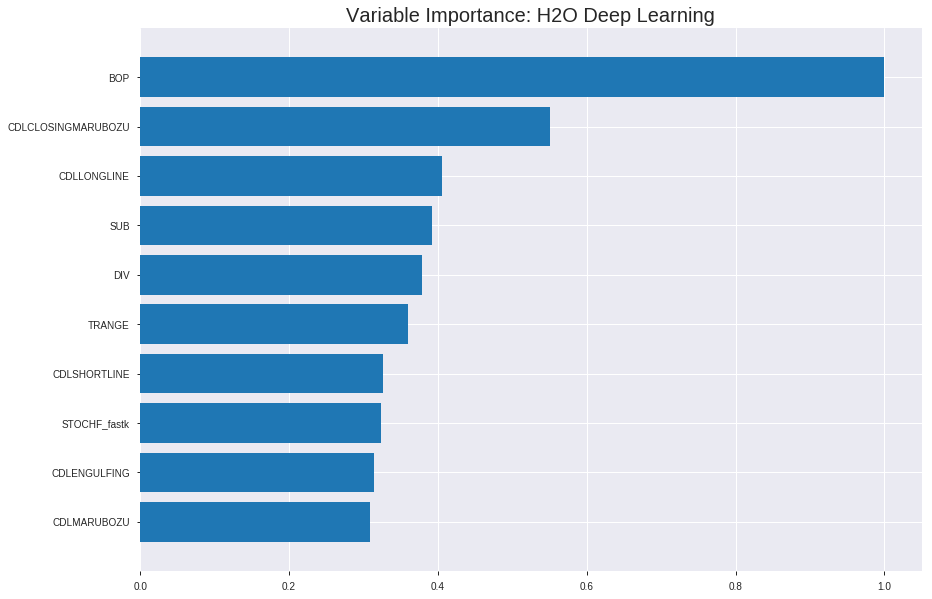

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_122034_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20780900491552942
RMSE: 0.4558607297360998
LogLoss: 0.5991259072564761
Mean Per-Class Error: 0.31118102788705415
AUC: 0.7549575622430476
pr_auc: 0.7202072535993633
Gini: 0.5099151244860951
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4671669313475585: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1156  1098  0.4871   (1098.0/2254.0)
1      306   1756  0.1484   (306.0/2062.0)
Total  1462  2854  0.3253   (1404.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467167     0.714402  201
max f2                       0.252157     0.83637   311
max f0point5                 0.472236     0.662461  194
max accuracy                 0.471699     0.683735  195
max precision                0.966286     1         0
max recall                   0.0227515    1         394
max specificity              0.966286     1         0
max absolute_mcc             0.470041     0.386912  197
max min_per_class_accuracy   0.473396     0.674103  191
max mean_per_class_accuracy  0.471699     0.688819  195

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 46.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.88847            1.85526   1.85526            0.886364         0.918254  0.886364                    0.918254            0.0189137       0.0189137                  85.526    85.526
    2        0.0201576                   0.849388           1.99576   1.9247             0.953488         0.868253  0.91954                     0.893541            0.0198836       0.0387973                  99.5759   92.4702
    3        0.0301205                   0.810485           1.84973   1.8999             0.883721         0.828417  0.907692                    0.872               0.0184287       0.057226                   84.9728   89.9903
    4        0.0400834                   0.775607           1.7037    1.85114            0.813953         0.792169  0.884393                    0.852157            0.0169738       0.0741998                  70.3697   85.1135
    5        0.0500463                   0.760189           1.7037    1.82178            0.813953         0.766932  0.87037                     0.835191            0.0169738       0.0911736                  70.3697   82.1784
    6        0.100093                    0.663616           1.6086    1.71519            0.768519         0.70734   0.819444                    0.771266            0.0805044       0.171678                   60.8596   71.519
    7        0.150139                    0.596411           1.6086    1.67966            0.768519         0.630171  0.802469                    0.724234            0.0805044       0.252182                   60.8596   67.9659
    8        0.200185                    0.544452           1.48262   1.6304             0.708333         0.567939  0.778935                    0.68516             0.0741998       0.326382                   48.2622   63.04
    9        0.300046                    0.480375           1.37436   1.54519            0.656613         0.506064  0.738224                    0.625554            0.137245        0.463628                   37.4365   54.5186
    10       0.452039                    0.473433           1.11356   1.40006            0.532012         0.474245  0.668888                    0.574678            0.169253        0.632881                   11.3562   40.0058
    11       0.5                         0.473068           1.06172   1.3676             0.507246         0.473266  0.653383                    0.56495             0.0509214       0.683802                   6.17242   36.7604
    12       0.600093                    0.471484           1.15315   1.33183            0.550926         0.472422  0.636293                    0.549517            0.115422        0.799224                   15.315    33.1834
    13       0.699954                    0.455736           0.781882  1.25337            0.37355          0.466648  0.598808                    0.537694            0.0780795       0.877304                   -21.8118  25.3374
    14       0.800046                    0.381235           0.634717  1.17597            0.303241         0.42352   0.56183                     0.52341             0.0635306       0.940834                   -36.5283  17.5975
    15       0.899907                    0.226256           0.432221  1.09344            0.206497         0.308836  0.5224                      0.499599            0.043162        0.983996                   -56.7779  9.34416
    16       1                           0.000946808        0.159891  1                  0.0763889        0.12402   0.477757                    0.462006            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20904534723262957
RMSE: 0.4572147714506057
LogLoss: 0.6016597770922307
Mean Per-Class Error: 0.31263955532329324
AUC: 0.7532543113687111
pr_auc: 0.7234777534918412
Gini: 0.5065086227374223
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38454276937452186: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      294  357  0.5484   (357.0/651.0)
1      73   509  0.1254   (73.0/582.0)
Total  367  866  0.3487   (430.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384543     0.703039  223
max f2                       0.186093     0.835544  317
max f0point5                 0.471536     0.663701  158
max accuracy                 0.452012     0.682076  179
max precision                0.94049      1         0
max recall                   0.0318621    1         388
max specificity              0.94049      1         0
max absolute_mcc             0.452012     0.37952   179
max min_per_class_accuracy   0.470722     0.671821  160
max mean_per_class_accuracy  0.452012     0.68736   179

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 41.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.866153           1.95559   1.95559            0.923077         0.907901  0.923077                    0.907901            0.0206186       0.0206186                  95.5591   95.5591
    2        0.0202758                   0.810336           1.76546   1.86433            0.833333         0.83121   0.88                        0.871089            0.0171821       0.0378007                  76.5464   86.433
    3        0.0300081                   0.759456           1.94201   1.88952            0.916667         0.783058  0.891892                    0.842538            0.0189003       0.056701                   94.201    88.9524
    4        0.0405515                   0.711716           1.95559   1.9067             0.923077         0.734147  0.9                         0.814357            0.0206186       0.0773196                  95.5591   90.6701
    5        0.0502839                   0.682056           1.94201   1.91354            0.916667         0.696807  0.903226                    0.791605            0.0189003       0.0962199                  94.201    91.3535
    6        0.100568                    0.58172            1.77685   1.84519            0.83871          0.625032  0.870968                    0.708318            0.0893471       0.185567                   77.6854   84.5195
    7        0.150041                    0.513906           1.49341   1.7292             0.704918         0.545317  0.816216                    0.654572            0.0738832       0.25945                    49.3409   72.92
    8        0.200324                    0.4834             1.50349   1.67254            0.709677         0.496545  0.789474                    0.614905            0.0756014       0.335052                   50.3492   67.2545
    9        0.326845                    0.473433           1.19508   1.48772            0.564103         0.475422  0.702233                    0.560912            0.151203        0.486254                   19.5083   48.7721
    10       0.399838                    0.472697           1.24759   1.44388            0.588889         0.473111  0.681542                    0.544883            0.0910653       0.57732                    24.7595   44.3884
    11       0.500406                    0.469922           1.05928   1.36659            0.5              0.471383  0.645057                    0.530112            0.106529        0.683849                   5.92784   36.6589
    12       0.600162                    0.446491           1.08511   1.3198             0.512195         0.462414  0.622973                    0.518859            0.108247        0.792096                   8.51144   31.9804
    13       0.699919                    0.385284           0.80953   1.24708            0.382114         0.41576   0.588644                    0.504165            0.080756        0.872852                   -19.047   24.7076
    14       0.799676                    0.26751            0.620065  1.16886            0.292683         0.327374  0.551724                    0.482111            0.0618557       0.934708                   -37.9935  16.8859
    15       0.899432                    0.143891           0.465049  1.0908             0.219512         0.203693  0.514878                    0.451231            0.0463918       0.9811                     -53.4951  9.07988
    16       1                           0.00324653         0.187936  1                  0.0887097        0.078455  0.472019                    0.413742            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:00:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 13:00:48  9.852 sec         267 obs/sec       0.111214  1             480        0.613283         1.79741             -0.507448      0.503565        0.487141           1.09413          0.522243                         0.578151           1.11564               -0.341233        0.511546          0.483539             0.977795           0.527981
    2019-08-24 13:02:07  1 min 29.095 sec  337 obs/sec       5.71501   51            24666      0.470301         0.631173            0.113513       0.703435        0.652493           1.90283          0.360982                         0.470064           0.630202              0.113383         0.710948          0.668469             2.11856            0.387672
    2019-08-24 13:03:26  2 min 48.631 sec  349 obs/sec       11.7162   105           50567      0.459334         0.608695            0.154375       0.7527          0.713058           1.99797          0.332715                         0.464022           0.617039              0.136027         0.739254          0.70671              1.95559            0.372263
    2019-08-24 13:04:47  4 min 10.541 sec  354 obs/sec       17.8248   160           76932      0.455861         0.599126            0.167116       0.754958        0.720207           1.85526          0.325301                         0.457215           0.60166               0.161192         0.753254          0.723478             1.95559            0.348743
    2019-08-24 13:06:21  5 min 43.151 sec  356 obs/sec       24.921    224           107559     0.460035         0.608995            0.151793       0.768757        0.73693            1.99797          0.324606                         0.461096           0.610425              0.14689          0.755225          0.722674             1.79262            0.336577
    2019-08-24 13:07:40  7 min  2.508 sec  357 obs/sec       30.9571   278           133611     0.443229         0.574072            0.212635       0.779194        0.747496           1.99797          0.304449                         0.459489           0.617855              0.152828         0.74486           0.70969              1.79262            0.330089
    2019-08-24 13:09:00  8 min 22.418 sec  359 obs/sec       37.0605   333           159953     0.441498         0.572058            0.218771       0.778296        0.742166           1.85526          0.303985                         0.455526           0.607646              0.167375         0.748672          0.718272             1.95559            0.3382
    2019-08-24 13:09:08  8 min 30.340 sec  359 obs/sec       37.0605   333           159953     0.455861         0.599126            0.167116       0.754958        0.720207           1.85526          0.325301                         0.457215           0.60166               0.161192         0.753254          0.723478             1.95559            0.348743

Variable Importances: 


variable             relative_importance    scaled_importance     percentage
-------------------  ---------------------  --------------------  ---------------------
BOP                  1.0                    1.0                   0.011078270905823308
CDLCLOSINGMARUBOZU   0.550147533416748      0.550147533416748     0.006094683413361216
CDLLONGLINE          0.4050867557525635     0.4050867557525635    0.004487660820587977
SUB                  0.3917882740497589     0.3917882740497589    0.004340336637648173
DIV                  0.37794291973114014    0.37794291973114014   0.004186954051719404
---                  ---                    ---                   ---
CDLLADDERBOTTOM      0.057984109967947006   0.057984109967947006  0.0006423636784579666
CDLPIERCING          0.05783019959926605    0.05783019959926605   0.0006406586176985038
CDLTASUKIGAP         0.05650885030627251    0.05650885030627251   0.0006260203522695032
CDLHIKKAKEMOD        0.05420815572142601    0.05420815572142601   0.0006005326343870131
CDLRISEFALL3METHODS  0.05406760796904564    0.05406760796904564   0.0005989756083109387


See the whole table with table.as_data_frame()


('accuracy', 0.7098865478119936)

('F1', 0.7310549777117383)

('auc', 0.747503048908701)

('logloss', 0.6400496627826863)

('mean_per_class_error', 0.2886685731107279)

('rmse', 0.47427988695549106)

('mse', 0.22494141117051336)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


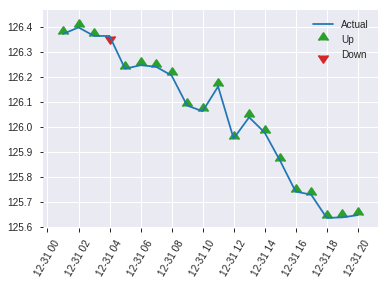


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22494141117051336
RMSE: 0.47427988695549106
LogLoss: 0.6400496627826863
Mean Per-Class Error: 0.2886685731107279
AUC: 0.747503048908701
pr_auc: 0.7132262328639722
Gini: 0.495006097817402
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46968629955935626: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      190  126  0.3987   (126.0/316.0)
1      55   246  0.1827   (55.0/301.0)
Total  245  372  0.2934   (181.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469686     0.731055  183
max f2                       0.0806634    0.831033  389
max f0point5                 0.470609     0.695364  170
max accuracy                 0.470609     0.709887  170
max precision                0.659895     0.904762  20
max recall                   0.0806634    1         389
max specificity              0.894573     0.996835  0
max absolute_mcc             0.469686     0.427574  183
max min_per_class_accuracy   0.471539     0.687708  158
max mean_per_class_accuracy  0.470552     0.711331  171

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 43.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.804894           1.757     1.757              0.857143         0.846509  0.857143                    0.846509            0.0199336       0.0199336                  75.7      75.7
    2        0.0210697                   0.70801            1.70819   1.73447            0.833333         0.747325  0.846154                    0.800732            0.0166113       0.0365449                  70.8195   73.4475
    3        0.0307942                   0.665658           2.04983   1.83406            1                0.685353  0.894737                    0.764296            0.0199336       0.0564784                  104.983   83.4062
    4        0.0405186                   0.64085            1.70819   1.80385            0.833333         0.651145  0.88                        0.73714             0.0166113       0.0730897                  70.8195   80.3854
    5        0.0502431                   0.625621           1.70819   1.78534            0.833333         0.631661  0.870968                    0.716724            0.0166113       0.089701                   70.8195   78.5339
    6        0.100486                    0.527944           1.58697   1.68615            0.774194         0.575684  0.822581                    0.646204            0.0797342       0.169435                   58.6968   68.6154
    7        0.150729                    0.490926           1.32247   1.56493            0.645161         0.505945  0.763441                    0.599451            0.0664452       0.23588                    32.2473   56.4927
    8        0.200972                    0.476544           1.65309   1.58697            0.806452         0.482885  0.774194                    0.57031             0.0830565       0.318937                   65.3092   58.6968
    9        0.363047                    0.473433           1.2504    1.43671            0.61             0.473678  0.700893                    0.527171            0.202658        0.521595                   25.0399   43.6714
    10       0.400324                    0.472863           1.42597   1.43571            0.695652         0.473128  0.700405                    0.522138            0.0531561       0.574751                   42.5971   43.5714
    11       0.50081                     0.471394           1.15716   1.37982            0.564516         0.472158  0.673139                    0.51211             0.116279        0.69103                    15.7164   37.9823
    12       0.599676                    0.469689           1.24334   1.35732            0.606557         0.470619  0.662162                    0.50527             0.122924        0.813953                   24.3342   35.7322
    13       0.700162                    0.46267            0.562051  1.24319            0.274194         0.467099  0.606481                    0.499791            0.0564784       0.870432                   -43.7949  24.3186
    14       0.799028                    0.387606           0.470454  1.14757            0.229508         0.434706  0.559838                    0.491738            0.0465116       0.916944                   -52.9546  14.7574
    15       0.899514                    0.246253           0.462866  1.07108            0.225806         0.315858  0.522523                    0.47209             0.0465116       0.963455                   -53.7134  7.10844
    16       1                           0.0125303          0.36368   1                  0.177419         0.148807  0.487844                    0.439605            

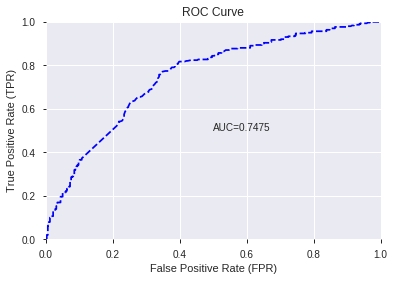

This function is available for GLM models only


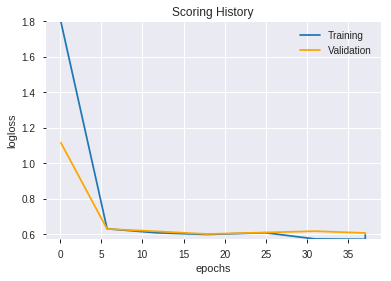

--2019-08-24 13:20:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  64.0MB/s    in 5.6s    

2019-08-24 13:20:56 (62.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_122034_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_122034_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_132151_model_9  0.744507  0.601023              0.327758  0.454759  0.206806
1  DeepLearning_grid_1_AutoML_20190824_132151_model_6  0.736658  0.606867              0.337567  0.458432  0.210160
2  DeepLearning_grid_1_AutoML_20190824_132151_model_5  0.736548  0.608361              0.337966  0.458349  0.210084
3  DeepLearning_grid_1_AutoML_20190824_132151_model_8  0.729919  0.611530              0.339070  0.459951  0.211555
4  DeepLearning_grid_1_AutoML_20190824_132151_model_7  0.729404  0.630813              0.327758  0.461979  0.213424
5  DeepLearning_grid_1_AutoML_20190824_132151_model_2  0.716399  0.668005              0.361543  0.480005  0.230404
6               DeepLearning_1_AutoML_20190824_132151  0.716310  0.623495              0.371268  0.465066  0.216286
7  DeepLearning_grid_1_AutoML_20190824_132151_model_3  0.710532  0.671474              0.387096  0.470758  0.221613
8  DeepLearning_grid_1_AutoML_20190824_132151_model_1  0.680926  0.806703              0.421117  0.507450  0.257506
9  DeepLearning_grid_1_AutoML_20190824_132151_model_4  0.665577  0.725558              0.383852  0.497932  0.247936

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.047600
1     CDLCLOSINGMARUBOZU             0.760202           0.760202    0.036186
2            CDLLONGLINE             0.643322           0.643322    0.030622
3           CDLSHORTLINE             0.509087           0.509087    0.024233
4       CDLDRAGONFLYDOJI             0.486429           0.486429    0.023154
5              CDLTAKURI             0.477326           0.477326    0.022721
6                 SAREXT             0.472545           0.472545    0.022493
7                 TRANGE             0.470696           0.470696    0.022405
8                    DIV             0.460288           0.460288    0.021910
9                    SUB             0.459288           0.459288    0.021862
10             CDLHAMMER             0.455586           0.455586    0.021686
11         CDLHANGINGMAN             0.455072           0.455072    0.021662
12           CDLBELTHOLD             0.448466           0.448466    0.021347
13           CDLMARUBOZU             0.436250           0.436250    0.020766
14           STOCH_slowd             0.426469           0.426469    0.020300
15             aroonup_8             0.414933           0.414933    0.019751
16              CORREL_8             0.413783           0.413783    0.019696
17               WILLR_8             0.409876           0.409876    0.019510
18                   OBV             0.407214           0.407214    0.019384
19             CDLHARAMI             0.405778           0.405778    0.019315
20            aroonup_14             0.403256           0.403256    0.019195
21     CDLINVERTEDHAMMER             0.400161           0.400161    0.019048
22                ULTOSC             0.396179           0.396179    0.018858
23          STOCHF_fastk             0.394622           0.394622    0.018784
24               CDLDOJI             0.387493           0.387493    0.018445
25          CDLENGULFING             0.382866           0.382866    0.018225
26             dayofyear             0.380934           0.380934    0.018133
27                 month             0.377686           0.377686    0.017978
28            CDLHIKKAKE             0.377009           0.377009    0.017946
29             PLUS_DM_8             0.376625           0.376625    0.017928
30     CDLLONGLEGGEDDOJI             0.375750           0.375750    0.017886
31        STOCHRSI_fastk             0.373003           0.373003    0.017755
32                  hour             0.368935           0.368935    0.017561
33            PLUS_DM_12             0.368342           0.368342    0.017533
34            PLUS_DI_12             0.365910           0.365910    0.017417
35     CDLGRAVESTONEDOJI             0.364785           0.364785    0.017364
36          HT_TRENDMODE             0.363039           0.363039    0.017281
37          aroondown_24             0.362322           0.362322    0.017247
38            PLUS_DM_14             0.355499           0.355499    0.016922
39  HT_PHASOR_quadrature             0.355203           0.355203    0.016908
40                 ADOSC             0.353961           0.353961    0.016849
41        CDLRICKSHAWMAN             0.353742           0.353742    0.016838
42           HT_DCPERIOD             0.352821           0.352821    0.016794
43                 RSI_8             0.351010           0.351010    0.016708
44               BETA_14             0.349699           0.349699    0.016646
45                BETA_8             0.347853           0.347853    0.016558
46              WILLR_20             0.345281           0.345281    0.016436
47              WILLR_14             0.343483           0.343483    0.016350
48              WILLR_12             0.338651           0.338651    0.016120
49                 CMO_8             0.329495           0.329495    0.015684

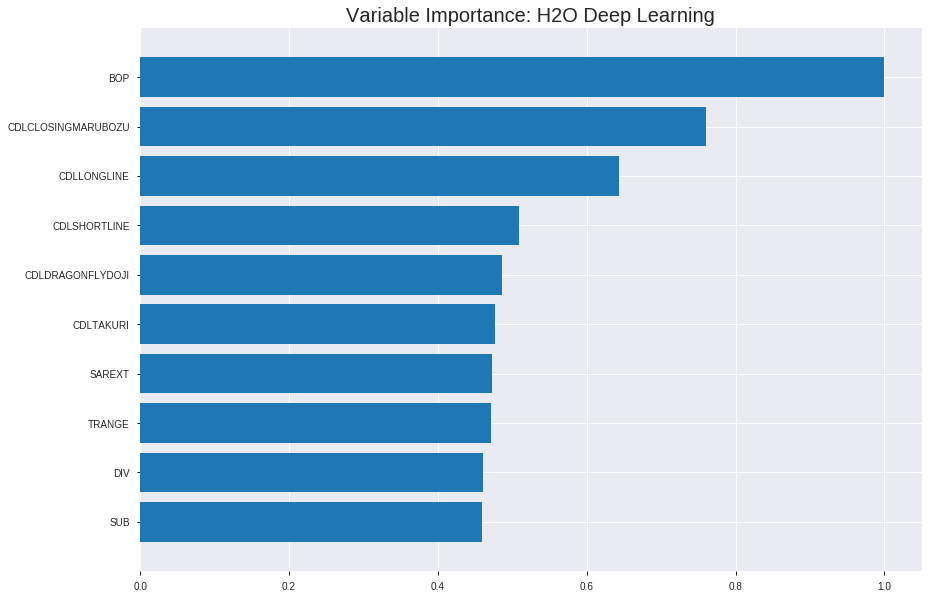

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_132151_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1979036022957776
RMSE: 0.44486357717369673
LogLoss: 0.5806178795951917
Mean Per-Class Error: 0.29729107516156206
AUC: 0.7706921717786764
pr_auc: 0.7366591973821192
Gini: 0.5413843435573529
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4442148672096188: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1163  1091  0.484    (1091.0/2254.0)
1      298   1764  0.1445   (298.0/2062.0)
Total  1461  2855  0.3218   (1389.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444215     0.717511  240
max f2                       0.247481     0.835975  337
max f0point5                 0.585587     0.693233  149
max accuracy                 0.52949      0.702271  186
max precision                0.807735     0.904306  35
max recall                   0.128751     1         393
max specificity              0.923477     0.999556  0
max absolute_mcc             0.513018     0.40561   197
max min_per_class_accuracy   0.528264     0.701863  187
max mean_per_class_accuracy  0.514472     0.702709  196

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.880419           1.76012   1.76012            0.840909         0.899843  0.840909                    0.899843            0.0179437       0.0179437                  76.0118   76.0118
    2        0.0201576                   0.839206           1.89841   1.82847            0.906977         0.855417  0.873563                    0.877886            0.0189137       0.0368574                  89.8405   82.8467
    3        0.0301205                   0.82777            1.80105   1.8194             0.860465         0.833491  0.869231                    0.863201            0.0179437       0.0548012                  80.1051   81.9399
    4        0.0400834                   0.816397           1.94708   1.85114            0.930233         0.821328  0.884393                    0.852794            0.0193986       0.0741998                  94.7082   85.1135
    5        0.0500463                   0.804494           2.04444   1.88962            0.976744         0.810883  0.902778                    0.84445             0.0203686       0.0945684                  104.444   88.9616
    6        0.100093                    0.749873           1.72488   1.80725            0.824074         0.774618  0.863426                    0.809534            0.086324        0.180892                   72.4881   80.7248
    7        0.150139                    0.718209           1.56014   1.72488            0.74537          0.733025  0.824074                    0.784031            0.0780795       0.258972                   56.0145   72.4881
    8        0.200185                    0.686388           1.502     1.66916            0.717593         0.702043  0.797454                    0.763534            0.0751697       0.334142                   50.2003   66.9161
    9        0.300046                    0.628653           1.34523   1.56135            0.642691         0.65852   0.745946                    0.728583            0.134336        0.468477                   34.5226   56.135
    10       0.400139                    0.565477           1.31304   1.49924            0.627315         0.598627  0.716271                    0.696075            0.131426        0.599903                   31.3041   49.9236
    11       0.5                         0.524016           1.10241   1.41998            0.526682         0.54302   0.678406                    0.665507            0.110087        0.70999                    10.2405   41.9981
    12       0.600093                    0.482417           0.944808  1.34072            0.451389         0.504379  0.640541                    0.638632            0.0945684       0.804559                   -5.51918  34.0724
    13       0.699954                    0.415916           0.7576    1.25753            0.361949         0.451342  0.600794                    0.611911            0.0756547       0.880213                   -24.24    25.7531
    14       0.800046                    0.309675           0.605646  1.17597            0.289352         0.365785  0.56183                     0.581119            0.0606208       0.940834                   -39.4354  17.5975
    15       0.899907                    0.221513           0.412795  1.09129            0.197216         0.263169  0.52137                     0.545837            0.0412221       0.982056                   -58.7205  9.1286
    16       1                           0.0979306          0.179271  1                  0.0856481        0.183531  0.477757                    0.509572           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20122119325610668
RMSE: 0.4485768532326503
LogLoss: 0.5888365156801355
Mean Per-Class Error: 0.3102008013048918
AUC: 0.7603752619549095
pr_auc: 0.7153893833212327
Gini: 0.5207505239098189
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42719068712717506: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      318  333  0.5115   (333.0/651.0)
1      79   503  0.1357   (79.0/582.0)
Total  397  836  0.3341   (412.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427191     0.70945   255
max f2                       0.261611     0.835052  336
max f0point5                 0.596495     0.681818  139
max accuracy                 0.526809     0.690998  186
max precision                0.921123     1         0
max recall                   0.135509     1         397
max specificity              0.921123     1         0
max absolute_mcc             0.453243     0.384123  238
max min_per_class_accuracy   0.52062      0.6851    191
max mean_per_class_accuracy  0.526809     0.689799  186

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.890835           1.62966   1.62966            0.769231         0.903248  0.769231                    0.903248            0.0171821       0.0171821                  62.9659   62.9659
    2        0.0202758                   0.864223           1.58892   1.6101             0.75             0.874235  0.76                        0.889322            0.0154639       0.032646                   58.8918   61.0103
    3        0.0300081                   0.847689           1.41237   1.54597            0.666667         0.855958  0.72973                     0.878501            0.0137457       0.0463918                  41.2371   54.5974
    4        0.0405515                   0.832588           1.95559   1.65247            0.923077         0.841729  0.78                        0.86894             0.0206186       0.0670103                  95.5591   65.2474
    5        0.0502839                   0.821733           1.76546   1.67434            0.833333         0.827101  0.790323                    0.860843            0.0171821       0.0841924                  76.5464   67.4343
    6        0.100568                    0.755725           2.01605   1.84519            0.951613         0.788353  0.870968                    0.824598            0.101375        0.185567                   101.605   84.5195
    7        0.150041                    0.706754           1.63233   1.77501            0.770492         0.732619  0.837838                    0.79427             0.080756        0.266323                   63.2331   77.5007
    8        0.200324                    0.678525           1.53766   1.71543            0.725806         0.692306  0.809717                    0.768676            0.0773196       0.343643                   53.7662   71.5431
    9        0.300081                    0.605035           1.34347   1.59178            0.634146         0.641462  0.751351                    0.726386            0.134021        0.477663                   34.3475   59.178
    10       0.399838                    0.548696           1.05067   1.45678            0.495935         0.57518   0.687627                    0.688661            0.104811        0.582474                   5.06663   45.6776
    11       0.500406                    0.516021           1.12762   1.39062            0.532258         0.532346  0.656402                    0.657246            0.113402        0.695876                   12.7619   39.0625
    12       0.600162                    0.467011           0.964546  1.3198             0.455285         0.492468  0.622973                    0.629857            0.0962199       0.792096                   -3.54539  31.9804
    13       0.699919                    0.409628           0.843978  1.25199            0.398374         0.441779  0.590962                    0.603051            0.0841924       0.876289                   -15.6022  25.1986
    14       0.799676                    0.317038           0.585617  1.16886            0.276423         0.366899  0.551724                    0.573592            0.0584192       0.934708                   -41.4383  16.8859
    15       0.899432                    0.231199           0.482273  1.09271            0.227642         0.275628  0.51578                     0.540545            0.04811         0.982818                   -51.7727  9.27091
    16       1                           0.11603            0.170851  1                  0.0806452        0.192842  0.472019                    0.505577          


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:38:33  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 13:38:36  8 min  4.275 sec   319 obs/sec       0.249537  1             1077       0.549562         0.990478            -0.210471      0.740918        0.703945           1.9504           0.348007                         0.602298           1.31517               -0.455611        0.738459          0.698068             1.95559            0.357664
    2019-08-24 13:39:36  9 min  4.040 sec   538 obs/sec       7.13601   29            30799      0.444864         0.580618            0.206816       0.770692        0.736659           1.76012          0.321826                         0.448577           0.588837              0.192587         0.760375          0.715389             1.62966            0.334144
    2019-08-24 13:40:36  10 min  4.392 sec  631 obs/sec       16.3443   66            70542      0.446742         0.583913            0.200102       0.775201        0.74256            1.80769          0.321131                         0.453542           0.598004              0.174613         0.756576          0.715889             1.62966            0.334144
    2019-08-24 13:41:36  11 min  4.123 sec  697 obs/sec       26.7498   108           115452     0.438357         0.567604            0.229848       0.780397        0.745928           1.85526          0.307229                         0.449974           0.593262              0.187549         0.752971          0.718306             1.62966            0.324412
    2019-08-24 13:42:34  12 min  2.238 sec  745 obs/sec       37.6494   152           162495     0.433869         0.557685            0.245538       0.788674        0.758413           1.76012          0.300278                         0.450674           0.593881              0.18502          0.753169          0.719152             1.95559            0.323601
    2019-08-24 13:43:32  12 min 59.838 sec  779 obs/sec       48.7607   197           210451     0.43289          0.559486            0.24894        0.791759        0.761354           1.9504           0.309778                         0.455362           0.608656              0.167977         0.749842          0.709884             1.79262            0.334144
    2019-08-24 13:44:29  13 min 57.338 sec  806 obs/sec       60.1233   243           259492     0.428958         0.547545            0.262522       0.798264        0.768172           1.90283          0.292169                         0.449993           0.592724              0.18748          0.755448          0.721489             1.95559            0.319546
    2019-08-24 13:44:35  14 min  2.956 sec  806 obs/sec       60.1233   243           259492     0.444864         0.580618            0.206816       0.770692        0.736659           1.76012          0.321826                         0.448577           0.588837              0.192587         0.760375          0.715389             1.62966            0.334144

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04760040738240327
CDLCLOSINGMARUBOZU  0.7602021098136902     0.7602021098136902   0.03618593012009412
CDLLONGLINE         0.6433220505714417     0.6433220505714417   0.030622391685283662
CDLSHORTLINE        0.509086549282074      0.509086549282074    0.024232727138728642
CDLDRAGONFLYDOJI    0.4864291250705719     0.4864291250705719   0.023154224516025217
---                 ---                    ---                  ---
BETA_8              0.3478534519672394     0.3478534519672394   0.016557966023015843
WILLR_20            0.34528109431266785    0.34528109431266785  0.016435520750724995
WILLR_14            0.3434832692146301     0.3434832692146301   0.01634994354365609
WILLR_12            0.3386509418487549     0.3386509418487549   0.016119922792435293
CMO_8               0.3294945955276489     0.3294945955276489   0.01568407697741628


See the whole table with table.as_data_frame()


('accuracy', 0.6969205834683955)

('F1', 0.7156726768377253)

('auc', 0.7445067075991421)

('logloss', 0.6010227956468066)

('mean_per_class_error', 0.30132680095882924)

('rmse', 0.4547587988631061)

('mse', 0.206805565143415)

deeplearning prediction progress: |███████████████████████████████████████| 100%


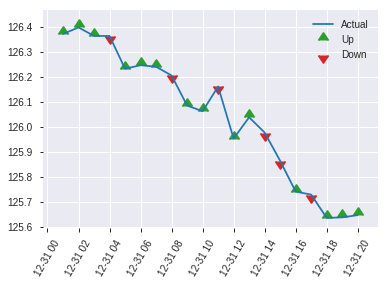


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.206805565143415
RMSE: 0.4547587988631061
LogLoss: 0.6010227956468066
Mean Per-Class Error: 0.30132680095882924
AUC: 0.7445067075991421
pr_auc: 0.724983945217063
Gini: 0.4890134151982841
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4421184581438992: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      154  162  0.5127   (162.0/316.0)
1      43   258  0.1429   (43.0/301.0)
Total  197  420  0.3323   (205.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442118     0.715673  259
max f2                       0.212783     0.833798  378
max f0point5                 0.49069      0.681952  219
max accuracy                 0.49069      0.696921  219
max precision                0.898572     1         0
max recall                   0.148506     1         397
max specificity              0.898572     1         0
max absolute_mcc             0.49069      0.400873  219
max min_per_class_accuracy   0.519884     0.667774  192
max mean_per_class_accuracy  0.49069      0.698673  219

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.878771           2.04983   2.04983            1                0.892003  1                           0.892003            0.0232558       0.0232558                  104.983   104.983
    2        0.0210697                   0.849383           1.36656   1.73447            0.666667         0.864532  0.846154                    0.879324            0.013289        0.0365449                  36.6556   73.4475
    3        0.0307942                   0.83295            1.70819   1.72618            0.833333         0.838857  0.842105                    0.866545            0.0166113       0.0531561                  70.8195   72.6176
    4        0.0405186                   0.815156           2.04983   1.80385            1                0.821498  0.88                        0.855734            0.0199336       0.0730897                  104.983   80.3854
    5        0.0502431                   0.809981           1.70819   1.78534            0.833333         0.812258  0.870968                    0.847319            0.0166113       0.089701                   70.8195   78.5339
    6        0.100486                    0.739109           1.78534   1.78534            0.870968         0.772563  0.870968                    0.809941            0.089701        0.179402                   78.5339   78.5339
    7        0.150729                    0.687997           1.45472   1.67513            0.709677         0.708222  0.817204                    0.776034            0.0730897       0.252492                   45.4721   67.5133
    8        0.200972                    0.66364            1.1241    1.53738            0.548387         0.677435  0.75                        0.751385            0.0564784       0.30897                    12.4102   53.7375
    9        0.299838                    0.598359           1.54578   1.54015            0.754098         0.626967  0.751351                    0.71036             0.152824        0.461794                   54.5776   54.0145
    10       0.400324                    0.543126           1.09104   1.42741            0.532258         0.56879   0.696356                    0.674824            0.109635        0.571429                   9.10406   42.7415
    11       0.50081                     0.517811           1.05798   1.35329            0.516129         0.529781  0.660194                    0.645722            0.106312        0.677741                   5.79788   35.3288
    12       0.599676                    0.479422           1.14253   1.31854            0.557377         0.497783  0.643243                    0.621332            0.112957        0.790698                   14.253    31.8542
    13       0.700162                    0.426884           0.694299  1.22895            0.33871          0.454399  0.599537                    0.597374            0.0697674       0.860465                   -30.5701  22.8951
    14       0.799028                    0.34351            0.571265  1.14757            0.278689         0.387221  0.559838                    0.571371            0.0564784       0.916944                   -42.8735  14.7574
    15       0.899514                    0.242528           0.429804  1.06739            0.209677         0.287357  0.520721                    0.539644            0.0431894       0.960133                   -57.0196  6.7391
    16       1                           0.136212           0.396742  1                  0.193548         0.207322  0.487844                    0.50625           

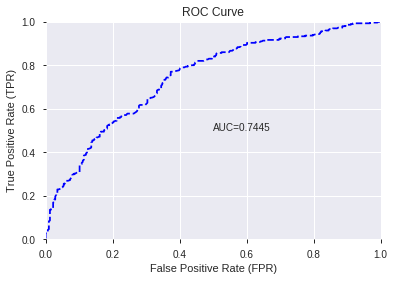

This function is available for GLM models only


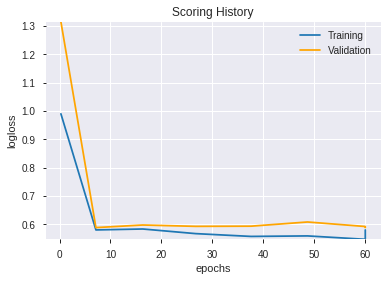

--2019-08-24 13:44:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.226.232
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.226.232|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_132151_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_132151_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'SAREXT',
 'TRANGE',
 'DIV',
 'SUB',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'CDLMARUBOZU',
 'STOCH_slowd',
 'aroonup_8',
 'CORREL_8',
 'WILLR_8',
 'OBV',
 'CDLHARAMI',
 'aroonup_14',
 'CDLINVERTEDHAMMER',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLDOJI',
 'CDLENGULFING',
 'dayofyear',
 'month',
 'CDLHIKKAKE',
 'PLUS_DM_8',
 'CDLLONGLEGGEDDOJI',
 'STOCHRSI_fastk',
 'hour',
 'PLUS_DM_12',
 'PLUS_DI_12',
 'CDLGRAVESTONEDOJI',
 'HT_TRENDMODE',
 'aroondown_24',
 'PLUS_DM_14',
 'HT_PHASOR_quadrature',
 'ADOSC',
 'CDLRICKSHAWMAN',
 'HT_DCPERIOD',
 'RSI_8',
 'BETA_14',
 'BETA_8',
 'WILLR_20',
 'WILLR_14',
 'WILLR_12',
 'CMO_8']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190824_134550_model_1  0.748649  0.596206              0.316209  0.45246  0.20472

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.773230           1.000000    0.190151
1             PLUS_DI_12             0.235781           0.304930    0.057983
2     CDLCLOSINGMARUBOZU             0.211517           0.273550    0.052016
3            STOCH_slowd             0.195799           0.253222    0.048150
4                 ULTOSC             0.157359           0.203509    0.038697
5                WILLR_8             0.148801           0.192440    0.036593
6                 TRANGE             0.143072           0.185032    0.035184
7              CDLHAMMER             0.138977           0.179735    0.034177
8                    SUB             0.131907           0.170592    0.032438
9             CDLHIKKAKE             0.130994           0.169412    0.032214
10                SAREXT             0.109570           0.141705    0.026945
11              WILLR_14             0.099699           0.128939    0.024518
12             PLUS_DM_8             0.093516           0.120942    0.022997
13          STOCHF_fastk             0.089032           0.115143    0.021895
14     CDLGRAVESTONEDOJI             0.087691           0.113409    0.021565
15             CDLTAKURI             0.083578           0.108089    0.020553
16          aroondown_24             0.075578           0.097743    0.018586
17           CDLBELTHOLD             0.073349           0.094861    0.018038
18         CDLHANGINGMAN             0.072324           0.093535    0.017786
19             aroonup_8             0.069004           0.089241    0.016969
20               CDLDOJI             0.066624           0.086163    0.016384
21            PLUS_DM_14             0.065876           0.085196    0.016200
22        CDLRICKSHAWMAN             0.049888           0.064519    0.012268
23     CDLINVERTEDHAMMER             0.049186           0.063611    0.012096
24               BETA_14             0.048439           0.062644    0.011912
25                 ADOSC             0.046460           0.060086    0.011425
26                BETA_8             0.046183           0.059727    0.011357
27        STOCHRSI_fastk             0.045380           0.058688    0.011160
28           CDLMARUBOZU             0.043997           0.056900    0.010820
29                   DIV             0.043628           0.056423    0.010729
30              CORREL_8             0.041230           0.053322    0.010139
31             dayofyear             0.040842           0.052819    0.010044
32          CDLSHORTLINE             0.039217           0.050718    0.009644
33                  hour             0.034029           0.044009    0.008368
34          CDLENGULFING             0.032508           0.042042    0.007994
35                 month             0.031984           0.041364    0.007865
36            aroonup_14             0.026338           0.034062    0.006477
37            PLUS_DM_12             0.025663           0.033189    0.006311
38     CDLLONGLEGGEDDOJI             0.024442           0.031610    0.006011
39      CDLDRAGONFLYDOJI             0.022710           0.029371    0.005585
40           CDLLONGLINE             0.021806           0.028201    0.005362
41              WILLR_12             0.018474           0.023892    0.004543
42             CDLHARAMI             0.018341           0.023720    0.004510
43              WILLR_20             0.015933           0.020605    0.003918
44           HT_DCPERIOD             0.014870           0.019231    0.003657
45          HT_TRENDMODE             0.012975           0.016781    0.003191
46                   OBV             0.007093           0.009173    0.001744
47                 CMO_8             0.005523           0.007143    0.001358
48                 RSI_8             0.004523           0.005849    0.001112
49  HT_PHASOR_quadrature             0.001466           0.001896    0.000360

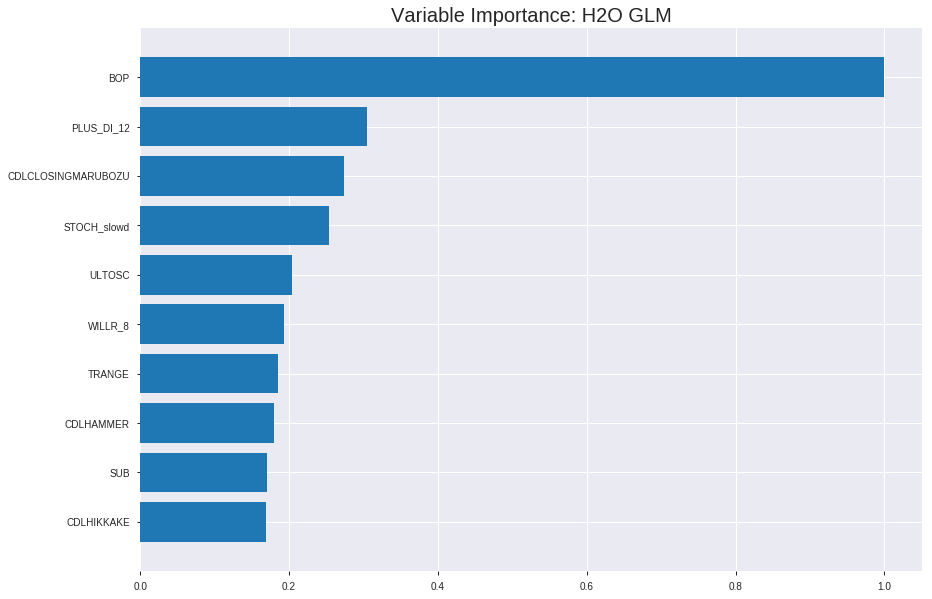

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_134550_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19275879936172105
RMSE: 0.4390430495540512
LogLoss: 0.5668178526502503
Null degrees of freedom: 4315
Residual degrees of freedom: 4265
Null deviance: 5974.702401324418
Residual deviance: 4892.77170407696
AIC: 4994.77170407696
AUC: 0.7750953795257401
pr_auc: 0.7435033112993242
Gini: 0.5501907590514803
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34439399107718804: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1124  1130  0.5013   (1130.0/2254.0)
1      253   1809  0.1227   (253.0/2062.0)
Total  1377  2939  0.3204   (1383.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344394     0.723455  261
max f2                       0.217842     0.838043  319
max f0point5                 0.557302     0.696624  165
max accuracy                 0.543664     0.705283  172
max precision                0.953377     1         0
max recall                   0.0354749    1         393
max specificity              0.953377     1         0
max absolute_mcc             0.412889     0.411275  232
max min_per_class_accuracy   0.507328     0.700976  190
max mean_per_class_accuracy  0.541337     0.703252  173

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 47.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101946                   0.905944           1.90283   1.90283            0.909091         0.921829   0.909091                    0.921829            0.0193986       0.0193986                  90.283     90.283
    2        0.0201576                   0.885977           1.89841   1.90064            0.906977         0.893638   0.908046                    0.907896            0.0189137       0.0383123                  89.8405    90.0643
    3        0.0301205                   0.873587           1.84973   1.8838             0.883721         0.879764   0.9                         0.898591            0.0184287       0.056741                   84.9728    88.3802
    4        0.0400834                   0.856193           1.89841   1.88743            0.906977         0.865758   0.901734                    0.89043             0.0189137       0.0756547                  89.8405    88.7432
    5        0.0500463                   0.833164           1.99576   1.909              0.953488         0.845327   0.912037                    0.881451            0.0198836       0.0955383                  99.5759    90.8997
    6        0.100093                    0.770086           1.69581   1.8024             0.810185         0.799534   0.861111                    0.840493            0.0848691       0.180407                   69.581     80.2403
    7        0.150139                    0.723196           1.56984   1.72488            0.75             0.744522   0.824074                    0.808502            0.0785645       0.258972                   56.9835    72.4881
    8        0.200185                    0.693396           1.42448   1.64978            0.680556         0.709326   0.788194                    0.783708            0.07129         0.330262                   42.448     64.978
    9        0.300046                    0.63273            1.42779   1.5759             0.682135         0.663107   0.752896                    0.74357             0.14258         0.472842                   42.7785    57.5896
    10       0.400139                    0.566779           1.31304   1.51014            0.627315         0.600079   0.721482                    0.707677            0.131426        0.604268                   31.3041    51.0144
    11       0.5                         0.501238           1.06355   1.42095            0.508121         0.53616    0.678869                    0.673421            0.106208        0.710475                   6.35542    42.0951
    12       0.600093                    0.410572           0.998105  1.35042            0.476852         0.454931   0.645174                    0.636978            0.099903        0.810378                   -0.189496  35.0422
    13       0.699954                    0.330446           0.777026  1.26862            0.37123          0.369276   0.606091                    0.598785            0.0775946       0.887973                   -22.2974   26.8617
    14       0.800046                    0.246684           0.586266  1.18325            0.280093         0.289266   0.565306                    0.560062            0.0586809       0.946654                   -41.3734   18.3249
    15       0.899907                    0.153264           0.335092  1.08913            0.160093         0.20263    0.52034                     0.520398            0.0334627       0.980116                   -66.4908   8.91304
    16       1                           0.00433131         0.198652  1                  0.0949074        0.0943823  0.477757    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19786600504334145
RMSE: 0.4448213181080033
LogLoss: 0.5784179941803964
Null degrees of freedom: 1232
Residual degrees of freedom: 1182
Null deviance: 1705.6003649118566
Residual deviance: 1426.378773648857
AIC: 1528.378773648857
AUC: 0.7633827946431871
pr_auc: 0.7307308630758859
Gini: 0.5267655892863743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3170601484670836: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      318  333  0.5115   (333.0/651.0)
1      78   504  0.134    (78.0/582.0)
Total  396  837  0.3333   (411.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.31706      0.710359  266
max f2                       0.192531     0.837533  329
max f0point5                 0.514607     0.682844  171
max accuracy                 0.514607     0.695864  171
max precision                0.957315     1         0
max recall                   0.0356646    1         395
max specificity              0.957315     1         0
max absolute_mcc             0.499213     0.388541  180
max min_per_class_accuracy   0.471841     0.687285  194
max mean_per_class_accuracy  0.499213     0.693406  180

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 44.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.899372           1.79262   1.79262            0.846154         0.920259   0.846154                    0.920259            0.0189003       0.0189003                  79.2625   79.2625
    2        0.0202758                   0.872254           1.94201   1.86433            0.916667         0.885913   0.88                        0.903773            0.0189003       0.0378007                  94.201    86.433
    3        0.0300081                   0.853314           1.76546   1.83227            0.833333         0.866164   0.864865                    0.891576            0.0171821       0.0549828                  76.5464   83.2265
    4        0.0405515                   0.83743            1.62966   1.77959            0.769231         0.845007   0.84                        0.879468            0.0171821       0.0721649                  62.9659   77.9588
    5        0.0502839                   0.828584           1.94201   1.81102            0.916667         0.833344   0.854839                    0.870541            0.0189003       0.0910653                  94.201    81.1024
    6        0.100568                    0.743935           1.87936   1.84519            0.887097         0.781695   0.870968                    0.826118            0.0945017       0.185567                   87.9365   84.5195
    7        0.150041                    0.688958           1.70179   1.79791            0.803279         0.714016   0.848649                    0.789154            0.0841924       0.269759                   70.1791   79.791
    8        0.200324                    0.651279           1.46932   1.71543            0.693548         0.670899   0.809717                    0.759471            0.0738832       0.343643                   46.9322   71.5431
    9        0.300081                    0.593958           1.22291   1.5517             0.577236         0.622087   0.732432                    0.7138              0.121993        0.465636                   22.2907   55.17
    10       0.399838                    0.528563           1.27458   1.48256            0.601626         0.560365   0.699797                    0.675519            0.127148        0.592784                   27.4579   48.256
    11       0.500406                    0.463354           1.02511   1.39062            0.483871         0.496387   0.656402                    0.639518            0.103093        0.695876                   2.51081   39.0625
    12       0.600162                    0.374857           0.964546  1.3198             0.455285         0.422036   0.622973                    0.603369            0.0962199       0.792096                   -3.54539  31.9804
    13       0.699919                    0.29914            0.843978  1.25199            0.398374         0.335182   0.590962                    0.565146            0.0841924       0.876289                   -15.6022  25.1986
    14       0.799676                    0.225937           0.671737  1.1796             0.317073         0.262653   0.556795                    0.527411            0.0670103       0.943299                   -32.8263  17.9602
    15       0.899432                    0.140522           0.378929  1.0908             0.178862         0.187642   0.514878                    0.489727            0.0378007       0.9811                     -62.1071  9.07988
    16       1                           0.0127485          0.187936  1                  0.0887097        0.0857498  0.472019                    0.44


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 13:45:51  0.000 sec   2            .21E2     51            1.3647279959382106  1.364897536420544
     2019-08-24 13:45:51  0.147 sec   4            .13E2     51            1.3546956746835226  1.3554331179129877
     2019-08-24 13:45:51  0.270 sec   6            .8E1      51            1.3407679982907899  1.3422417503308868
     2019-08-24 13:45:51  0.327 sec   8            .49E1     51            1.3225199145456805  1.324864409958923
     2019-08-24 13:45:52  0.384 sec   10           .31E1     51            1.3002052449876862  1.3034964502980526
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 13:45:52  1.095 sec   36           .63E-2    51            1.1324478075374211  1.1568968386342497
     2019-08-24 13:45:52  1.156 sec   38           .39E-2    51            1.131755001941175   1.1572268958528396
     2019-08-24 13:45:52  1.188 sec   39           .24E-2    51            1.1313137998472012  1.1576542842336048
     2019-08-24 13:45:52  1.218 sec   40           .15E-2    51            1.1309707038210413  1.1581185206599915
     2019-08-24 13:45:52  1.243 sec   41           .93E-3    51            1.1306299114630396  1.1586221865479767


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6888168557536467)

('F1', 0.7272727272727274)

('auc', 0.7486490180411287)

('logloss', 0.5962058562316731)

('mean_per_class_error', 0.31057866184448457)

('rmse', 0.45245980612270115)

('mse', 0.20471987615659232)

glm prediction progress: |████████████████████████████████████████████████| 100%


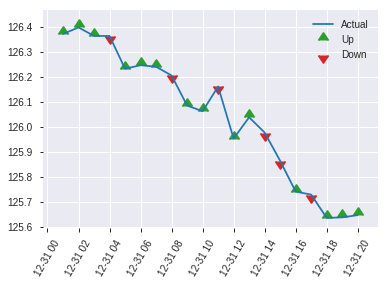


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20471987615659232
RMSE: 0.45245980612270115
LogLoss: 0.5962058562316731
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.2304056881629
Residual deviance: 735.7180265898846
AIC: 837.7180265898846
AUC: 0.7486490180411287
pr_auc: 0.7346411720764486
Gini: 0.4972980360822574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30728497002637584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      155  161  0.5095   (161.0/316.0)
1      37   264  0.1229   (37.0/301.0)
Total  192  425  0.3209   (198.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.307285     0.727273  273
max f2                       0.0638399    0.833333  389
max f0point5                 0.439248     0.678233  203
max accuracy                 0.439248     0.688817  203
max precision                0.941269     1         0
max recall                   0.0638399    1         389
max specificity              0.941269     1         0
max absolute_mcc             0.307285     0.39686   273
max min_per_class_accuracy   0.451207     0.683544  196
max mean_per_class_accuracy  0.439248     0.689421  203

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 44.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.885702           2.04983   2.04983            1                0.90274    1                           0.90274             0.0232558       0.0232558                  104.983   104.983
    2        0.0210697                   0.869974           2.04983   2.04983            1                0.877629   1                           0.89115             0.0199336       0.0431894                  104.983   104.983
    3        0.0307942                   0.849366           1.70819   1.94195            0.833333         0.856982   0.947368                    0.88036             0.0166113       0.0598007                  70.8195   94.1948
    4        0.0405186                   0.83326            1.70819   1.88585            0.833333         0.841595   0.92                        0.871057            0.0166113       0.076412                   70.8195   88.5847
    5        0.0502431                   0.818977           2.04983   1.91759            1                0.82561    0.935484                    0.86226             0.0199336       0.0963455                  104.983   91.7587
    6        0.100486                    0.738942           1.71922   1.8184             0.83871          0.780079   0.887097                    0.82117             0.0863787       0.182724                   71.9216   81.8401
    7        0.150729                    0.686891           1.45472   1.69717            0.709677         0.706904   0.827957                    0.783081            0.0730897       0.255814                   45.4721   69.7174
    8        0.200972                    0.652699           1.25635   1.58697            0.612903         0.668464   0.774194                    0.754427            0.0631229       0.318937                   25.635    58.6968
    9        0.299838                    0.585399           1.27695   1.48474            0.622951         0.616286   0.724324                    0.708878            0.126246        0.445183                   27.6946   48.4745
    10       0.400324                    0.521848           1.22329   1.41912            0.596774         0.54782    0.692308                    0.66845             0.122924        0.568106                   22.3288   41.9116
    11       0.50081                     0.44896            1.22329   1.37982            0.596774         0.486007   0.673139                    0.631843            0.122924        0.69103                    22.3288   37.9823
    12       0.599676                    0.381012           1.00812   1.31854            0.491803         0.414444   0.643243                    0.596002            0.0996678       0.790698                   0.811503  31.8542
    13       0.700162                    0.299518           0.89267   1.25742            0.435484         0.335318   0.613426                    0.558589            0.089701        0.880399                   -10.733   25.7421
    14       0.799028                    0.206625           0.537661  1.16836            0.262295         0.254695   0.56998                     0.520988            0.0531561       0.933555                   -46.2339  16.8364
    15       0.899514                    0.124805           0.297557  1.07108            0.145161         0.171294   0.522523                    0.481923            0.0299003       0.963455                   -70.2443  7.10844
    16       1                           0.0233098          0.36368   1                  0.177419         0.0819425  0.487844                   

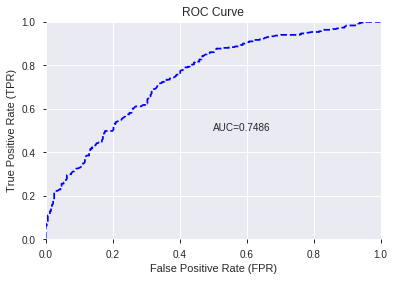

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


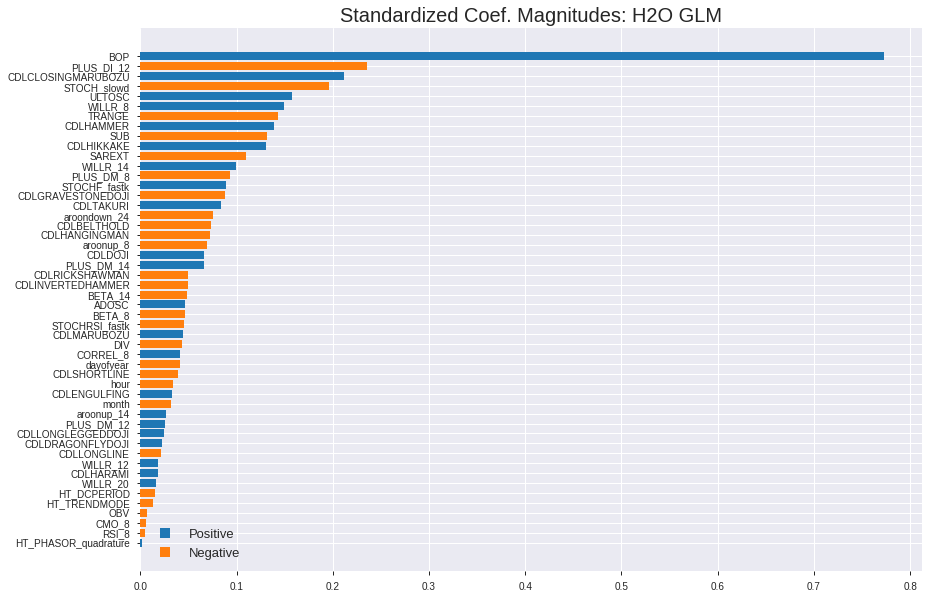

'log_likelihood'
--2019-08-24 13:46:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_134550_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_134550_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'PLUS_DI_12',
 'CDLCLOSINGMARUBOZU',
 'STOCH_slowd',
 'ULTOSC',
 'WILLR_8',
 'TRANGE',
 'CDLHAMMER',
 'SUB',
 'CDLHIKKAKE',
 'SAREXT',
 'WILLR_14',
 'PLUS_DM_8',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'aroondown_24',
 'CDLBELTHOLD',
 'CDLHANGINGMAN',
 'aroonup_8',
 'CDLDOJI',
 'PLUS_DM_14',
 'CDLRICKSHAWMAN',
 'CDLINVERTEDHAMMER',
 'BETA_14',
 'ADOSC',
 'BETA_8',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'DIV',
 'CORREL_8',
 'dayofyear',
 'CDLSHORTLINE',
 'hour',
 'CDLENGULFING',
 'month',
 'aroonup_14',
 'PLUS_DM_12',
 'CDLLONGLEGGEDDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLINE',
 'WILLR_12',
 'CDLHARAMI',
 'WILLR_20',
 'HT_DCPERIOD',
 'HT_TRENDMODE',
 'OBV',
 'CMO_8',
 'RSI_8',
 'HT_PHASOR_quadrature']

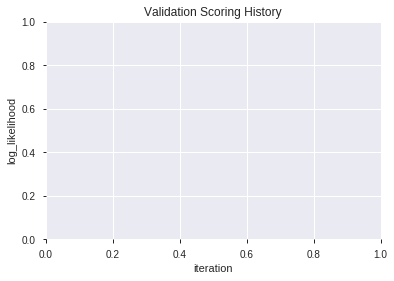

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_134659  0.757501  0.587310              0.306000  0.448554  0.201200
1  XGBoost_grid_1_AutoML_20190824_134659_model_2  0.754552  0.592099              0.298798  0.450727  0.203155
2               XGBoost_1_AutoML_20190824_134659  0.753522  0.592498              0.335117  0.450281  0.202753
3  XGBoost_grid_1_AutoML_20190824_134659_model_1  0.752118  0.590408              0.315178  0.450215  0.202693
4  XGBoost_grid_1_AutoML_20190824_134659_model_6  0.751540  0.591342              0.317313  0.450479  0.202932
5  XGBoost_grid_1_AutoML_20190824_134659_model_3  0.748081  0.596058              0.339391  0.452969  0.205181
6  XGBoost_grid_1_AutoML_20190824_134659_model_4  0.746488  0.594313              0.309322  0.451808  0.204130
7  XGBoost_grid_1_AutoML_20190824_134659_model_7  0.742309  0.603150              0.318022  0.455615  0.207585
8               XGBoost_2_AutoML_20190824_134659  0.739902  0.602857              0.333535  0.455320  0.207316
9  XGBoost_grid_1_AutoML_20190824_134659_model_5  0.718396  0.643326              0.368587  0.471027  0.221866

variable  relative_importance  scaled_importance  percentage
0                    BOP          5221.853027           1.000000    0.326745
1           STOCHF_fastk          1069.867554           0.204883    0.066944
2         STOCHRSI_fastk           769.352356           0.147333    0.048140
3                 TRANGE           547.011353           0.104754    0.034228
4                    SUB           542.946289           0.103976    0.033974
5                    DIV           513.456238           0.098328    0.032128
6     CDLCLOSINGMARUBOZU           502.854706           0.096298    0.031465
7              PLUS_DM_8           400.996246           0.076792    0.025091
8              dayofyear           334.502106           0.064058    0.020931
9                   hour           321.238342           0.061518    0.020101
10                 ADOSC           306.464600           0.058689    0.019176
11                   OBV           288.432098           0.055236    0.018048
12           HT_DCPERIOD           279.299377           0.053487    0.017477
13           STOCH_slowd           278.836456           0.053398    0.017448
14               WILLR_8           275.400269           0.052740    0.017233
15            aroonup_14           271.384735           0.051971    0.016981
16              CORREL_8           262.226227           0.050217    0.016408
17              WILLR_14           255.780869           0.048983    0.016005
18            PLUS_DI_12           254.600754           0.048757    0.015931
19                BETA_8           243.952332           0.046718    0.015265
20  HT_PHASOR_quadrature           238.104828           0.045598    0.014899
21                SAREXT           232.943268           0.044609    0.014576
22             aroonup_8           231.236343           0.044282    0.014469
23            PLUS_DM_12           218.321259           0.041809    0.013661
24               BETA_14           217.381271           0.041629    0.013602
25             CDLHAMMER           203.724564           0.039014    0.012748
26            PLUS_DM_14           192.789673           0.036920    0.012063
27              WILLR_12           185.016251           0.035431    0.011577
28                ULTOSC           163.034058           0.031221    0.010201
29              WILLR_20           155.533325           0.029785    0.009732
30          aroondown_24           137.592743           0.026349    0.008610
31            CDLHIKKAKE           130.168442           0.024928    0.008145
32                 CMO_8           103.719757           0.019863    0.006490
33             CDLTAKURI            96.830261           0.018543    0.006059
34      CDLDRAGONFLYDOJI            95.144424           0.018220    0.005953
35     CDLGRAVESTONEDOJI            73.811874           0.014135    0.004619
36          CDLSHORTLINE            71.755455           0.013741    0.004490
37           CDLLONGLINE            68.585266           0.013134    0.004292
38                 RSI_8            56.294540           0.010781    0.003522
39        CDLRICKSHAWMAN            53.555862           0.010256    0.003351
40           CDLBELTHOLD            35.928402           0.006880    0.002248
41               CDLDOJI            21.291580           0.004077    0.001332
42          HT_TRENDMODE            20.883286           0.003999    0.001307
43                 month            17.799278           0.003409    0.001114
44         CDLHANGINGMAN             8.974592           0.001719    0.000562
45     CDLLONGLEGGEDDOJI             8.459269           0.001620    0.000529
46          CDLENGULFING             2.081532           0.000399    0.000130

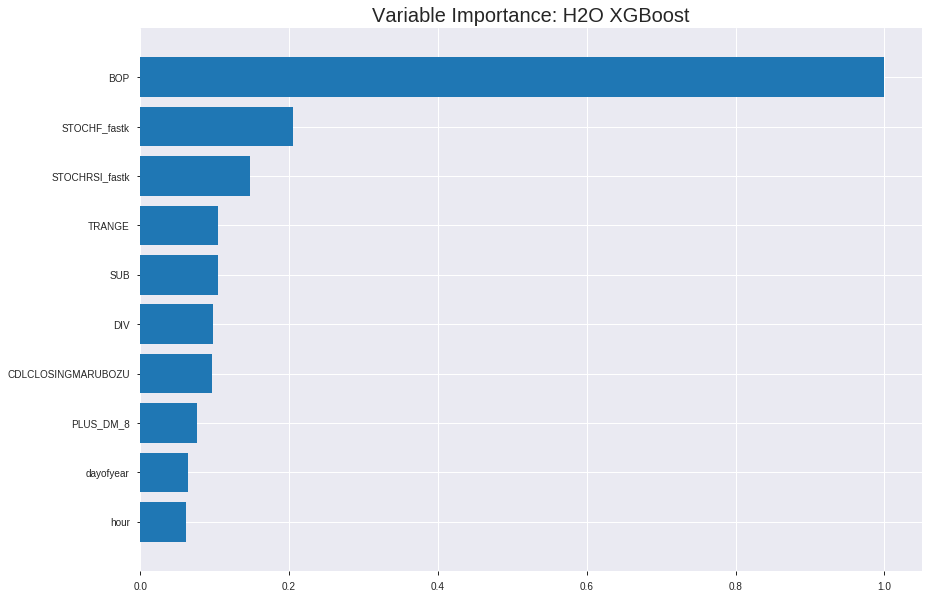

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_134659


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16085102976327778
RMSE: 0.40106237639957926
LogLoss: 0.49122522947807407
Mean Per-Class Error: 0.22930137348238333
AUC: 0.8595260543385743
pr_auc: 0.8511670243656146
Gini: 0.7190521086771486
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4711126254664527: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1590  664   0.2946   (664.0/2254.0)
1      357   1705  0.1731   (357.0/2062.0)
Total  1947  2369  0.2366   (1021.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471113     0.769578  211
max f2                       0.305575     0.865924  284
max f0point5                 0.590581     0.77723   151
max accuracy                 0.502451     0.769926  195
max precision                0.953156     1         0
max recall                   0.130079     1         361
max specificity              0.953156     1         0
max absolute_mcc             0.502451     0.540892  195
max min_per_class_accuracy   0.514418     0.767524  190
max mean_per_class_accuracy  0.502451     0.770699  195

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 47.79 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.918916           2.09311    2.09311            1                0.933323  1                           0.933323            0.0213385       0.0213385                  109.311   109.311
    2        0.0201576                   0.89005            2.04444    2.06905            0.976744         0.903186  0.988506                    0.918428            0.0203686       0.0417071                  104.444   106.905
    3        0.0301205                   0.874305           2.09311    2.07701            1                0.882133  0.992308                    0.906422            0.0208535       0.0625606                  109.311   107.701
    4        0.0400834                   0.85639            2.09311    2.08101            1                0.865502  0.99422                     0.896251            0.0208535       0.0834142                  109.311   108.101
    5        0.0500463                   0.837778           2.04444    2.07373            0.976744         0.847731  0.990741                    0.886592            0.0203686       0.103783                   104.444   107.373
    6        0.100093                    0.759915           2.02528    2.04951            0.967593         0.79591   0.979167                    0.841251            0.101358        0.205141                   102.528   104.951
    7        0.150139                    0.716565           1.87993    1.99298            0.898148         0.737521  0.95216                     0.806674            0.0940834       0.299224                   87.9926   99.298
    8        0.200185                    0.681289           1.72488    1.92596            0.824074         0.698575  0.920139                    0.779649            0.086324        0.385548                   72.4881   92.5955
    9        0.300046                    0.626087           1.56862    1.80703            0.74942          0.652595  0.86332                     0.737363            0.156644        0.542192                   56.8621   80.7028
    10       0.400139                    0.567473           1.22583    1.66164            0.585648         0.596708  0.793862                    0.702179            0.122696        0.664888                   22.5828   66.1644
    11       0.5                         0.50529            1.16554    1.56256            0.556845         0.536929  0.746525                    0.669175            0.116392        0.78128                    16.5539   56.2561
    12       0.600093                    0.431036           0.838214   1.44174            0.400463         0.468976  0.688803                    0.635783            0.0838991       0.865179                   -16.1786  44.1743
    13       0.699954                    0.336266           0.743031   1.34206            0.354988         0.383566  0.641178                    0.599799            0.0741998       0.939379                   -25.6969  34.2059
    14       0.800046                    0.238054           0.387614   1.22265            0.185185         0.285465  0.58413                     0.560474            0.0387973       0.978177                   -61.2386  22.265
    15       0.899907                    0.148439           0.203969   1.10961            0.0974478        0.1913    0.530124                    0.519507            0.0203686       0.998545                   -79.6031  10.9609
    16       1                           0.0406432          0.0145355  1                  0.00694444       0.104241  0.477757                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19491583317990574
RMSE: 0.44149273287326685
LogLoss: 0.5713388107057197
Mean Per-Class Error: 0.299697531157458
AUC: 0.7741064500292967
pr_auc: 0.7400007786020615
Gini: 0.5482129000585934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3188982129096985: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      321  330  0.5069   (330.0/651.0)
1      75   507  0.1289   (75.0/582.0)
Total  396  837  0.3285   (405.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318898     0.714588  269
max f2                       0.143203     0.834785  360
max f0point5                 0.527863     0.686747  163
max accuracy                 0.486359     0.699919  186
max precision                0.940408     1         0
max recall                   0.0841558    1         388
max specificity              0.940408     1         0
max absolute_mcc             0.416245     0.402062  223
max min_per_class_accuracy   0.466687     0.694316  198
max mean_per_class_accuracy  0.450499     0.700302  205

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 44.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.90491            1.79262   1.79262            0.846154         0.921535  0.846154                    0.921535            0.0189003       0.0189003                  79.2625   79.2625
    2        0.0202758                   0.88217            2.11856   1.94907            1                0.894415  0.92                        0.908518            0.0206186       0.0395189                  111.856   94.9072
    3        0.0300081                   0.856048           1.76546   1.88952            0.833333         0.867382  0.891892                    0.895176            0.0171821       0.056701                   76.5464   88.9524
    4        0.0405515                   0.817867           1.79262   1.86433            0.846154         0.834179  0.88                        0.879317            0.0189003       0.0756014                  79.2625   86.433
    5        0.0502839                   0.796927           1.58892   1.81102            0.75             0.807994  0.854839                    0.865513            0.0154639       0.0910653                  58.8918   81.1024
    6        0.100568                    0.717455           1.87936   1.84519            0.887097         0.749504  0.870968                    0.807508            0.0945017       0.185567                   87.9365   84.5195
    7        0.150041                    0.66111            1.77125   1.82081            0.836066         0.687004  0.859459                    0.767775            0.0876289       0.273196                   77.1252   82.0814
    8        0.200324                    0.621304           1.43515   1.72401            0.677419         0.640796  0.813765                    0.735901            0.0721649       0.345361                   43.5151   72.4008
    9        0.300081                    0.572814           1.37792   1.60896            0.650407         0.594323  0.759459                    0.688836            0.137457        0.482818                   37.7923   60.8958
    10       0.399838                    0.515443           1.15401   1.49545            0.544715         0.544444  0.705882                    0.652811            0.11512         0.597938                   15.4011   49.5452
    11       0.500406                    0.457452           1.12762   1.42153            0.532258         0.487914  0.670989                    0.619672            0.113402        0.71134                    12.7619   42.1528
    12       0.600162                    0.378438           0.861202  1.32839            0.406504         0.419904  0.627027                    0.586467            0.0859107       0.797251                   -13.8798  32.8392
    13       0.699919                    0.30365            0.843978  1.25935            0.398374         0.338745  0.594438                    0.55116             0.0841924       0.881443                   -15.6022  25.9351
    14       0.799676                    0.223266           0.620065  1.1796             0.292683         0.264478  0.556795                    0.515398            0.0618557       0.943299                   -37.9935  17.9602
    15       0.899432                    0.144988           0.413377  1.09462            0.195122         0.184427  0.516682                    0.478689            0.0412371       0.984536                   -58.6623  9.46195
    16       1                           0.0456391          0.153766  1                  0.0725806        0.105625  0.472019                    0.441171          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:47:15  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.522243                         0.5                0.693147              0.5               0                    1                  0.527981
    2019-08-24 13:47:15  0.095 sec   5                  0.478196         0.650222            0.793609        0.751217           2.00404          0.284986                         0.481075           0.655778              0.762431          0.720849             1.95559            0.340633
    2019-08-24 13:47:15  0.170 sec   10                 0.462081         0.618736            0.799298        0.772477           2.0466           0.281974                         0.467878           0.629755              0.766386          0.734049             1.95559            0.323601
    2019-08-24 13:47:15  0.267 sec   15                 0.450277         0.595295            0.80595         0.784909           2.04554          0.284754                         0.459561           0.612852              0.766881          0.735562             1.95559            0.325223
    2019-08-24 13:47:15  0.356 sec   20                 0.441795         0.577865            0.80973         0.790564           2.09311          0.286376                         0.453888           0.600869              0.767662          0.736179             1.95559            0.343066
    2019-08-24 13:47:15  0.440 sec   25                 0.434884         0.563234            0.814271        0.797017           2.09311          0.27734                          0.449951           0.592139              0.767912          0.734657             1.95559            0.341444
    2019-08-24 13:47:15  0.526 sec   30                 0.429616         0.551892            0.819587        0.804125           2.09311          0.27595                          0.447653           0.586723              0.767686          0.732808             1.79262            0.321168
    2019-08-24 13:47:16  0.610 sec   35                 0.424891         0.541684            0.824906        0.81121            2.09311          0.274096                         0.44551            0.581714              0.769081          0.734919             1.95559            0.341444
    2019-08-24 13:47:16  0.695 sec   40                 0.420905         0.532961            0.829898        0.816364           2.09311          0.272011                         0.444401           0.578766              0.769716          0.735333             1.79262            0.334955
    2019-08-24 13:47:16  0.782 sec   45                 0.417412         0.525517            0.835185        0.82066            2.09311          0.269926                         0.443989           0.577627              0.769924          0.735699             1.79262            0.333333
    2019-08-24 13:47:16  0.875 sec   50                 0.41457          0.519213            0.83866         0.826957           2.09311          0.264597                         0.442747           0.574665              0.771769          0.73837              1.79262            0.331711
    2019-08-24 13:47:16  0.970 sec   55                 0.411081         0.511907            0.84419         0.832552           2.09311          0.265292                         0.442039           0.572865              0.772298          0

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                5221.85302734375       1.0                    0.32674530160356563
STOCHF_fastk       1069.8675537109375     0.20488273953875666    0.06694447252395583
STOCHRSI_fastk     769.3523559570312      0.1473332075660477     0.04814043334238899
TRANGE             547.0113525390625      0.10475426054212714    0.03422796245509582
SUB                542.9462890625         0.10397578909621011    0.0339736005677099
---                ---                    ---                    ---
HT_TRENDMODE       20.883285522460938     0.003999209746637361   0.001306722994840944
month              17.799278259277344     0.0034086134110004763  0.0011137484170273093
CDLHANGINGMAN      8.974592208862305      0.0017186604375626206  0.0005615642230255146
CDLLONGLEGGEDDOJI  8.459268569946289      0.001619974466085145   0.0005293190455110658
CDLENGULFING       2.081531524658203      0.0003986193241668151  0.0001302469912998955


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7017828200972447)

('F1', 0.7259684361549498)

('auc', 0.7575013667521763)

('logloss', 0.5873101478501312)

('mean_per_class_error', 0.2971319231254468)

('rmse', 0.4485536434344455)

('mse', 0.20120037103831567)

xgboost prediction progress: |████████████████████████████████████████████| 100%


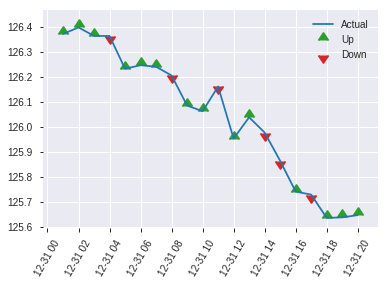


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20120037103831567
RMSE: 0.4485536434344455
LogLoss: 0.5873101478501312
Mean Per-Class Error: 0.2971319231254468
AUC: 0.7575013667521763
pr_auc: 0.7227858871228904
Gini: 0.5150027335043526
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37566469609737396: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      173  143  0.4525   (143.0/316.0)
1      48   253  0.1595   (48.0/301.0)
Total  221  396  0.3096   (191.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375665     0.725968  255
max f2                       0.18939      0.842923  343
max f0point5                 0.49038      0.691739  191
max accuracy                 0.457954     0.701783  214
max precision                0.947373     1         0
max recall                   0.100109     1         388
max specificity              0.947373     1         0
max absolute_mcc             0.457954     0.406901  214
max min_per_class_accuracy   0.486172     0.69103   195
max mean_per_class_accuracy  0.457954     0.702868  214

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 45.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.906412           1.46417   1.46417            0.714286         0.923542  0.714286                    0.923542            0.0166113       0.0166113                  46.4167   46.4167
    2        0.0210697                   0.880738           2.04983   1.73447            1                0.891137  0.846154                    0.908586            0.0199336       0.0365449                  104.983   73.4475
    3        0.0307942                   0.861332           2.04983   1.83406            1                0.872501  0.894737                    0.89719             0.0199336       0.0564784                  104.983   83.4062
    4        0.0405186                   0.838454           1.70819   1.80385            0.833333         0.849985  0.88                        0.885861            0.0166113       0.0730897                  70.8195   80.3854
    5        0.0502431                   0.825472           1.02492   1.65309            0.5              0.831499  0.806452                    0.875339            0.00996678      0.0830565                  2.49169   65.3092
    6        0.100486                    0.727044           1.78534   1.71922            0.870968         0.777983  0.83871                     0.826661            0.089701        0.172757                   78.5339   71.9216
    7        0.150729                    0.673049           1.45472   1.63105            0.709677         0.695706  0.795699                    0.783009            0.0730897       0.245847                   45.4721   63.1051
    8        0.200972                    0.636741           1.45472   1.58697            0.709677         0.654463  0.774194                    0.750873            0.0730897       0.318937                   45.4721   58.6968
    9        0.299838                    0.578372           1.37776   1.51799            0.672131         0.602611  0.740541                    0.701987            0.136213        0.45515                    37.7757   51.7985
    10       0.400324                    0.531069           1.32247   1.46891            0.645161         0.551515  0.716599                    0.664217            0.13289         0.58804                    32.2473   46.8909
    11       0.50081                     0.483576           1.09104   1.39309            0.532258         0.507155  0.679612                    0.632703            0.109635        0.697674                   9.10406   39.3091
    12       0.599676                    0.415432           1.00812   1.32962            0.491803         0.45123   0.648649                    0.602784            0.0996678       0.797342                   0.811503  32.9622
    13       0.700162                    0.322646           0.72736   1.24319            0.354839         0.368726  0.606481                    0.569192            0.0730897       0.870432                   -27.264   24.3186
    14       0.799028                    0.243828           0.638473  1.16836            0.311475         0.281323  0.56998                     0.533574            0.0631229       0.933555                   -36.1527  16.8364
    15       0.899514                    0.158949           0.462866  1.08955            0.225806         0.20289   0.531532                    0.496632            0.0465116       0.980066                   -53.7134  8.95513
    16       1                           0.0589939          0.198371  1                  0.0967742        0.12265   0.487844                    0.459052         

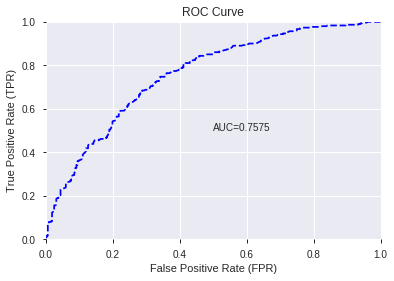

This function is available for GLM models only


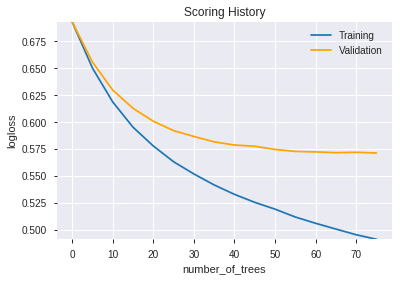

--2019-08-24 13:47:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_134659',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_134659',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_baad',
   'type

['BOP',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'TRANGE',
 'SUB',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DM_8',
 'dayofyear',
 'hour',
 'ADOSC',
 'OBV',
 'HT_DCPERIOD',
 'STOCH_slowd',
 'WILLR_8',
 'aroonup_14',
 'CORREL_8',
 'WILLR_14',
 'PLUS_DI_12',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'SAREXT',
 'aroonup_8',
 'PLUS_DM_12',
 'BETA_14',
 'CDLHAMMER',
 'PLUS_DM_14',
 'WILLR_12',
 'ULTOSC',
 'WILLR_20',
 'aroondown_24',
 'CDLHIKKAKE',
 'CMO_8',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'RSI_8',
 'CDLRICKSHAWMAN',
 'CDLBELTHOLD',
 'CDLDOJI',
 'HT_TRENDMODE',
 'month',
 'CDLHANGINGMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLENGULFING']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_134846_model_1  0.743503  0.60745              0.339391  0.458186  0.209935

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.399370           1.000000  4.638755e-02
1           CDLCLOSINGMARUBOZU             0.164870           0.412826  1.915000e-02
2                       TRANGE             0.104759           0.262312  1.216801e-02
3                    CDLHAMMER             0.103236           0.258496  1.199100e-02
4                   CDLHIKKAKE             0.101050           0.253023  1.173714e-02
...                        ...                  ...                ...           ...
1031  BBANDS_middleband_14_1_2             0.000036           0.000090  4.193044e-06
1032             MINMAX_min_24             0.000034           0.000086  3.980679e-06
1033              LINEARREG_30             0.000024           0.000059  2.739032e-06
1034                    SUM_20             0.000005           0.000011  5.284533e-07
1035                    T3_8_8             0.000001           0.000003  1.294783e-07

[1036 rows x 4 columns]

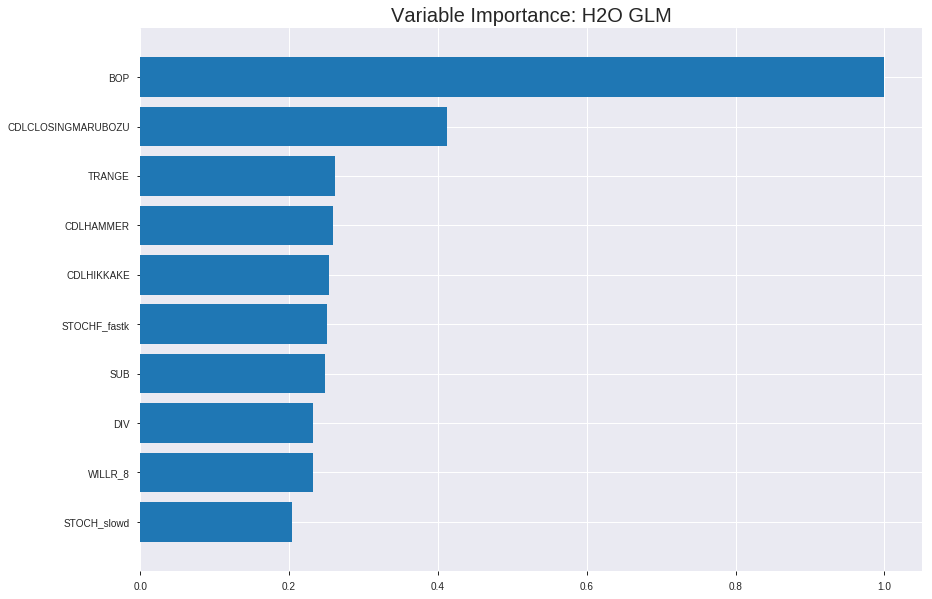

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_134846_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19029868139073838
RMSE: 0.4362323708652745
LogLoss: 0.5619668101582196
Null degrees of freedom: 4315
Residual degrees of freedom: 3279
Null deviance: 5974.702401324418
Residual deviance: 4850.897505285751
AIC: 6924.897505285751
AUC: 0.7842047374341293
pr_auc: 0.7503376222735715
Gini: 0.5684094748682587
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39101109206823703: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1243  1011  0.4485   (1011.0/2254.0)
1      289   1773  0.1402   (289.0/2062.0)
Total  1532  2784  0.3012   (1300.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391011     0.731738  244
max f2                       0.264343     0.83674   304
max f0point5                 0.56051      0.705948  158
max accuracy                 0.519544     0.715477  180
max precision                0.959495     1         0
max recall                   0.0348185    1         395
max specificity              0.959495     1         0
max absolute_mcc             0.438167     0.433393  220
max min_per_class_accuracy   0.496077     0.709406  191
max mean_per_class_accuracy  0.459857     0.715184  210

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 47.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.890231           1.90283   1.90283            0.909091         0.913134  0.909091                    0.913134            0.0193986       0.0193986                  90.283    90.283
    2        0.0201576                   0.868007           1.89841   1.90064            0.906977         0.877613  0.908046                    0.895577            0.0189137       0.0383123                  89.8405   90.0643
    3        0.0301205                   0.845914           1.89841   1.8999             0.906977         0.855737  0.907692                    0.8824              0.0189137       0.057226                   89.8405   89.9903
    4        0.0400834                   0.825085           1.89841   1.89953            0.906977         0.835362  0.907514                    0.870708            0.0189137       0.0761397                  89.8405   89.9531
    5        0.0500463                   0.805898           1.65502   1.85085            0.790698         0.814636  0.884259                    0.859546            0.0164888       0.0926285                  65.502    85.0855
    6        0.100093                    0.75185            1.71519   1.78302            0.819444         0.777529  0.851852                    0.818537            0.085839        0.178468                   71.519    78.3023
    7        0.150139                    0.713156           1.58922   1.71842            0.759259         0.732493  0.820988                    0.789856            0.0795344       0.258002                   58.9216   71.842
    8        0.200185                    0.675142           1.47293   1.65705            0.703704         0.693697  0.791667                    0.765816            0.0737148       0.331717                   47.2932   65.7048
    9        0.300046                    0.614097           1.46178   1.59206            0.698376         0.643476  0.760618                    0.725099            0.145975        0.477692                   46.178    59.2059
    10       0.400139                    0.557434           1.35665   1.53317            0.648148         0.586255  0.732484                    0.690368            0.13579         0.613482                   35.6648   53.3172
    11       0.5                         0.48909            1.07327   1.44132            0.512761         0.523966  0.688601                    0.657134            0.107177        0.72066                    7.3267    44.1319
    12       0.600093                    0.420391           0.978724  1.36416            0.467593         0.455491  0.651737                    0.623501            0.0979631       0.818623                   -2.12756  36.416
    13       0.699954                    0.350071           0.747887  1.27624            0.357309         0.385604  0.609732                    0.589561            0.0746848       0.893307                   -25.2113  27.6238
    14       0.800046                    0.272157           0.542659  1.18446            0.259259         0.311482  0.565885                    0.554771            0.0543162       0.947624                   -45.7341  18.4461
    15       0.899907                    0.179131           0.364231  1.09344            0.174014         0.226091  0.5224                      0.518298            0.0363725       0.983996                   -63.5769  9.34416
    16       1                           0.00915687         0.159891  1                  0.0763889        0.113269  0.477757                    0.477757            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2019331074107748
RMSE: 0.449369677894242
LogLoss: 0.5869036449843633
Null degrees of freedom: 1232
Residual degrees of freedom: 196
Null deviance: 1705.6003649118566
Residual deviance: 1447.30438853144
AIC: 3521.30438853144
AUC: 0.7627665077781473
pr_auc: 0.7237043694879278
Gini: 0.5255330155562945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30303852722990354: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      331  320  0.4916   (320.0/651.0)
1      82   500  0.1409   (82.0/582.0)
Total  413  820  0.326    (402.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303039     0.713267  270
max f2                       0.167129     0.837004  343
max f0point5                 0.47297      0.682546  175
max accuracy                 0.47297      0.69262   175
max precision                0.94191      1         0
max recall                   0.0504594    1         391
max specificity              0.94191      1         0
max absolute_mcc             0.346398     0.396956  248
max min_per_class_accuracy   0.409596     0.678955  211
max mean_per_class_accuracy  0.351144     0.694506  245

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 41.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.864516           1.95559   1.95559            0.923077         0.89235    0.923077                    0.89235             0.0206186       0.0206186                  95.5591   95.5591
    2        0.0202758                   0.838228           1.76546   1.86433            0.833333         0.85159    0.88                        0.872785            0.0171821       0.0378007                  76.5464   86.433
    3        0.0300081                   0.80239            1.76546   1.83227            0.833333         0.818251   0.864865                    0.855098            0.0171821       0.0549828                  76.5464   83.2265
    4        0.0405515                   0.780199           1.79262   1.82196            0.846154         0.79145    0.86                        0.83855             0.0189003       0.0738832                  79.2625   82.1959
    5        0.0502839                   0.7614             1.94201   1.84519            0.916667         0.771464   0.870968                    0.825565            0.0189003       0.0927835                  94.201    84.5195
    6        0.100568                    0.683333           1.81102   1.82811            0.854839         0.717072   0.862903                    0.771319            0.0910653       0.183849                   81.1024   82.8109
    7        0.150041                    0.634863           1.56287   1.74065            0.737705         0.659088   0.821622                    0.734313            0.0773196       0.261168                   56.287    74.0652
    8        0.200324                    0.598332           1.29847   1.62966            0.612903         0.614114   0.769231                    0.704142            0.0652921       0.32646                    29.847    62.9659
    9        0.300081                    0.531461           1.41237   1.55743            0.666667         0.563675   0.735135                    0.657446            0.140893        0.467354                   41.2371   55.7425
    10       0.399838                    0.463606           1.2918    1.49115            0.609756         0.497755   0.703854                    0.617604            0.128866        0.59622                    29.1803   49.1155
    11       0.500406                    0.405212           0.973853  1.38719            0.459677         0.435072   0.654781                    0.58092             0.0979381       0.694158                   -2.61473  38.7191
    12       0.600162                    0.347586           1.10234   1.33984            0.520325         0.378184   0.632432                    0.547222            0.109966        0.804124                   10.2338   33.9844
    13       0.699919                    0.280665           0.72341   1.25199            0.341463         0.314172   0.590962                    0.514006            0.0721649       0.876289                   -27.659   25.1986
    14       0.799676                    0.217842           0.671737  1.1796             0.317073         0.249347   0.556795                    0.480991            0.0670103       0.943299                   -32.8263  17.9602
    15       0.899432                    0.139915           0.396153  1.09271            0.186992         0.182824   0.51578                     0.447921            0.0395189       0.982818                   -60.3847  9.27091
    16       1                           0.0244217          0.170851  1                  0.0806452        0.0870911  0.472019                    


Scoring History: 


timestamp            duration          iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 13:48:54  0.000 sec         2            .21E2     1003          1.3583632641194008  1.362033384727033
     2019-08-24 13:48:59  5.107 sec         4            .15E2     1005          1.351361945861771   1.3557576663474786
     2019-08-24 13:49:04  10.249 sec        6            .11E2     1011          1.3427548318300637  1.347857745256773
     2019-08-24 13:49:10  15.613 sec        8            .8E1      1021          1.3323383790724657  1.3381659501709187
     2019-08-24 13:49:15  20.748 sec        10           .58E1     1032          1.3199827597712432  1.3265480446446056
---  ---                  ---               ---          ---       ---           ---                 ---
     2019-08-24 13:50:38  1 min 43.503 sec  40           .49E-1    1037          1.1179845451869623  1.1747458431569429
     2019-08-24 13:50:43  1 min 48.879 sec  42           .36E-1    1037          1.1127621350933692  1.1769099071887212
     2019-08-24 13:50:48  1 min 54.290 sec  44           .26E-1    1037          1.1081437036298383  1.1799936964699944
     2019-08-24 13:50:54  1 min 59.578 sec  46           .19E-1    1037          1.1040320745804137  1.1838845252338488
     2019-08-24 13:50:59  2 min  4.870 sec  48           .14E-1    1037          1.100328862309307   1.1882351971434515


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7050243111831442)

('F1', 0.7178807947019867)

('auc', 0.743502670423483)

('logloss', 0.6074504359603556)

('mean_per_class_error', 0.29499243029563904)

('rmse', 0.45818635792753387)

('mse', 0.20993473859089817)

glm prediction progress: |████████████████████████████████████████████████| 100%


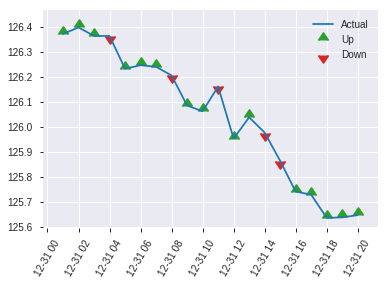


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20993473859089817
RMSE: 0.45818635792753387
LogLoss: 0.6074504359603556
Null degrees of freedom: 616
Residual degrees of freedom: -420
Null deviance: 855.2304056881629
Residual deviance: 749.5938379750789
AIC: 2823.5938379750787
AUC: 0.743502670423483
pr_auc: 0.7254308133995409
Gini: 0.4870053408469659
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26150367890563686: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  183  0.5791   (183.0/316.0)
1      30   271  0.0997   (30.0/301.0)
Total  163  454  0.3452   (213.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.261504     0.717881  295
max f2                       0.0762136    0.83472   384
max f0point5                 0.421438     0.69729   208
max accuracy                 0.421438     0.705024  208
max precision                0.910736     1         0
max recall                   0.0762136    1         384
max specificity              0.910736     1         0
max absolute_mcc             0.419338     0.40992   210
max min_per_class_accuracy   0.419338     0.704319  210
max mean_per_class_accuracy  0.419338     0.705008  210

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 42.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.841906           2.04983   2.04983            1                0.871776   1                           0.871776            0.0232558       0.0232558                  104.983   104.983
    2        0.0210697                   0.812111           2.04983   2.04983            1                0.826331   1                           0.850801            0.0199336       0.0431894                  104.983   104.983
    3        0.0307942                   0.798089           2.04983   2.04983            1                0.808217   1                           0.837354            0.0199336       0.0631229                  104.983   104.983
    4        0.0405186                   0.779722           1.36656   1.88585            0.666667         0.791032   0.92                        0.826236            0.013289        0.076412                   36.6556   88.5847
    5        0.0502431                   0.769485           1.70819   1.85146            0.833333         0.776429   0.903226                    0.816596            0.0166113       0.0930233                  70.8195   85.1463
    6        0.100486                    0.706338           1.65309   1.75228            0.806452         0.733798   0.854839                    0.775197            0.0830565       0.17608                    65.3092   75.2277
    7        0.150729                    0.663576           1.52084   1.67513            0.741935         0.685158   0.817204                    0.745184            0.076412        0.252492                   52.0844   67.5133
    8        0.200972                    0.62712            1.05798   1.52084            0.516129         0.642687   0.741935                    0.71956             0.0531561       0.305648                   5.79788   52.0844
    9        0.299838                    0.543112           1.41136   1.48474            0.688525         0.58035    0.724324                    0.673658            0.139535        0.445183                   41.1361   48.4745
    10       0.400324                    0.474493           1.1241    1.39422            0.548387         0.509016   0.680162                    0.632331            0.112957        0.55814                    12.4102   39.4219
    11       0.50081                     0.414286           1.48778   1.41299            0.725806         0.443039   0.68932                     0.59435             0.149502        0.707641                   48.7783   41.2992
    12       0.599676                    0.357004           0.772888  1.30746            0.377049         0.389083   0.637838                    0.560509            0.076412        0.784053                   -22.7112  30.7462
    13       0.700162                    0.294779           0.826546  1.23844            0.403226         0.329198   0.604167                    0.527311            0.0830565       0.86711                    -17.3454  23.8441
    14       0.799028                    0.211064           0.604869  1.16005            0.295082         0.247387   0.565923                    0.492676            0.0598007       0.92691                    -39.5131  16.0048
    15       0.899514                    0.139054           0.36368   1.07108            0.177419         0.179009   0.522523                    0.457636            0.0365449       0.963455                   -63.632   7.10844
    16       1                           0.0221726          0.36368   1                  0.177419         0.0925238  0.487844                   

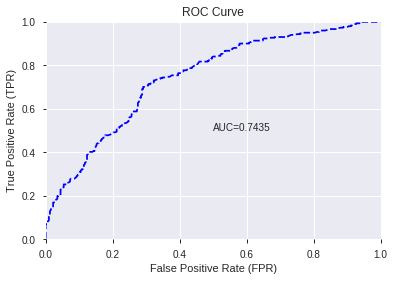

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


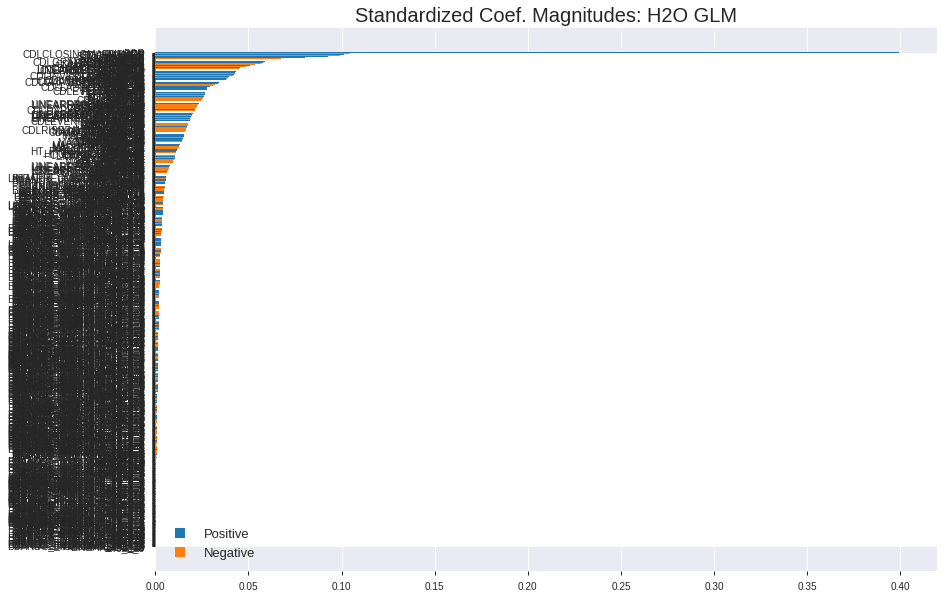

'log_likelihood'
--2019-08-24 13:51:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.230.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.230.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_134846_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_134846_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

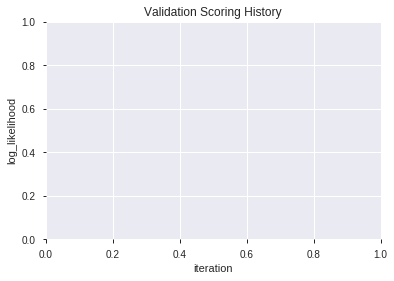

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_135224_model_6  0.750946  0.590058              0.343586  0.450217  0.202695
1  XGBoost_grid_1_AutoML_20190824_135224_model_2  0.746467  0.596209              0.315651  0.452335  0.204607
2  XGBoost_grid_1_AutoML_20190824_135224_model_1  0.741926  0.596022              0.317870  0.452734  0.204968
3  XGBoost_grid_1_AutoML_20190824_135224_model_3  0.741037  0.599160              0.312960  0.453823  0.205956
4  XGBoost_grid_1_AutoML_20190824_135224_model_4  0.739928  0.598313              0.318343  0.453936  0.206058
5               XGBoost_3_AutoML_20190824_135224  0.736264  0.603969              0.327363  0.455654  0.207621
6  XGBoost_grid_1_AutoML_20190824_135224_model_7  0.730550  0.611279              0.315651  0.458882  0.210573
7               XGBoost_2_AutoML_20190824_135224  0.727338  0.611956              0.341289  0.459423  0.211069
8               XGBoost_1_AutoML_20190824_135224  0.726597  0.613948              0.312881  0.460040  0.211637
9  XGBoost_grid_1_AutoML_20190824_135224_model_5  0.714811  0.629312              0.324509  0.467049  0.218135

variable  relative_importance  scaled_importance  percentage
0               BOP          4598.984863           1.000000    0.241058
1    STOCHRSI_fastk           674.074951           0.146570    0.035332
2            TRANGE           662.705566           0.144098    0.034736
3      STOCHF_fastk           615.418152           0.133816    0.032257
4               SUB           259.562378           0.056439    0.013605
..              ...                  ...                ...         ...
318  CDLRICKSHAWMAN             3.803257           0.000827    0.000199
319        SAR_0.08             3.418850           0.000743    0.000179
320         weekday             3.214869           0.000699    0.000169
321      AROONOSC_8             3.034107           0.000660    0.000159
322       MACDFIX_8             2.779492           0.000604    0.000146

[323 rows x 4 columns]

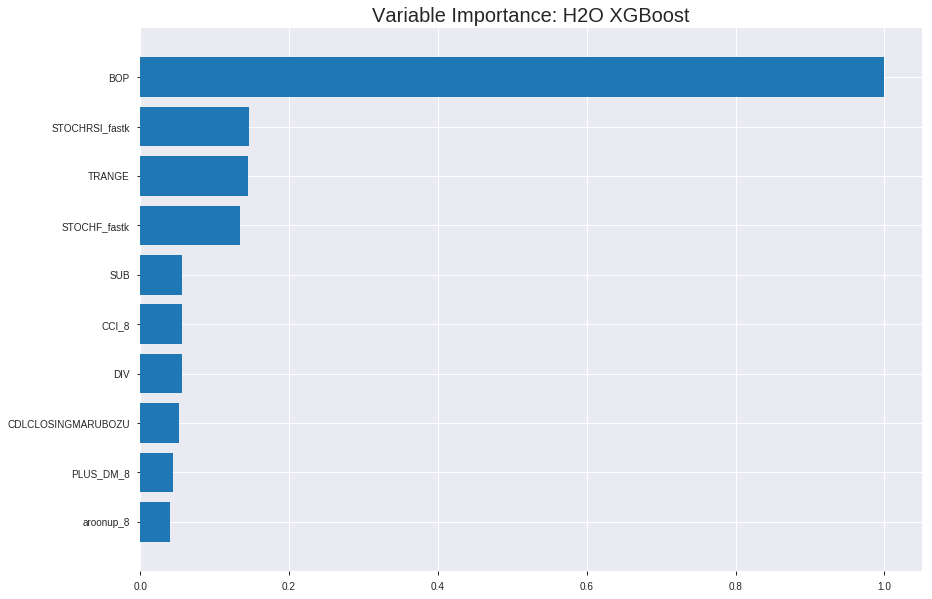

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_135224_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15109764169280512
RMSE: 0.3887128010405692
LogLoss: 0.4705811677163165
Mean Per-Class Error: 0.20220072172587678
AUC: 0.8866624223172168
pr_auc: 0.8809574076428632
Gini: 0.7733248446344336
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4891174516894601: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1708  546   0.2422   (546.0/2254.0)
1      339   1723  0.1644   (339.0/2062.0)
Total  2047  2269  0.2051   (885.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489117     0.795659  202
max f2                       0.305129     0.877193  287
max f0point5                 0.584852     0.809563  151
max accuracy                 0.49672      0.796571  198
max precision                0.947795     1         0
max recall                   0.131687     1         364
max specificity              0.947795     1         0
max absolute_mcc             0.49672      0.595255  198
max min_per_class_accuracy   0.516813     0.793404  188
max mean_per_class_accuracy  0.49672      0.797799  198

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 47.62 %



group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.900893           2.09311     2.09311            1                0.918157  1                           0.918157            0.0213385       0.0213385                  109.311   109.311
    2        0.0201576                   0.874684           2.09311     2.09311            1                0.888216  1                           0.903359            0.0208535       0.042192                   109.311   109.311
    3        0.0301205                   0.853227           2.09311     2.09311            1                0.864108  1                           0.890376            0.0208535       0.0630456                  109.311   109.311
    4        0.0400834                   0.839241           2.09311     2.09311            1                0.845406  1                           0.879198            0.0208535       0.0838991                  109.311   109.311
    5        0.0500463                   0.821994           2.09311     2.09311            1                0.831805  1                           0.869763            0.0208535       0.104753                   109.311   109.311
    6        0.100093                    0.754668           2.03497     2.06404            0.972222         0.785983  0.986111                    0.827873            0.101843        0.206596                   103.497   106.404
    7        0.150139                    0.71577            1.94776     2.02528            0.930556         0.733869  0.967593                    0.796539            0.0974782       0.304074                   94.7758   102.528
    8        0.200185                    0.687468           1.85085     1.98167            0.884259         0.7009    0.946759                    0.772629            0.0926285       0.396702                   85.0855   98.1675
    9        0.300046                    0.627876           1.67061     1.87815            0.798144         0.657084  0.897297                    0.734174            0.166828        0.563531                   67.0606   87.8145
    10       0.400139                    0.570557           1.35665     1.7477             0.648148         0.599051  0.834974                    0.700373            0.13579         0.699321                   35.6648   74.7695
    11       0.5                         0.506283           1.09269     1.61688            0.522042         0.539005  0.772475                    0.668145            0.109117        0.808438                   9.26927   61.6877
    12       0.600093                    0.424981           0.755847    1.47326            0.361111         0.466804  0.703861                    0.634562            0.0756547       0.884093                   -24.4153  47.3261
    13       0.699954                    0.335509           0.694467    1.36215            0.331787         0.379378  0.650778                    0.598155            0.0693501       0.953443                   -30.5533  36.2152
    14       0.800046                    0.23264            0.319781    1.23174            0.152778         0.284708  0.588474                    0.55894             0.0320078       0.985451                   -68.0219  23.1742
    15       0.899907                    0.141646           0.140836    1.11069            0.0672854        0.185737  0.530639                    0.517527            0.014064        0.999515                   -85.9164  11.0687
    16       1                           0.0560843          0.00484517  1                  0.00231481       0.10441   0.477757 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19528790307480506
RMSE: 0.44191390912122813
LogLoss: 0.5726599387569309
Mean Per-Class Error: 0.2994520721491123
AUC: 0.7711041960293706
pr_auc: 0.7358228882996243
Gini: 0.5422083920587413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35717348754405975: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      353  298  0.4578   (298.0/651.0)
1      92   490  0.1581   (92.0/582.0)
Total  445  788  0.3163   (390.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.357173     0.715328  257
max f2                       0.141459     0.83406   360
max f0point5                 0.558587     0.693604  150
max accuracy                 0.558587     0.697486  150
max precision                0.752375     0.911111  49
max recall                   0.083873     1         390
max specificity              0.939359     0.998464  0
max absolute_mcc             0.420087     0.403188  227
max min_per_class_accuracy   0.471971     0.685567  200
max mean_per_class_accuracy  0.420087     0.700548  227

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 44.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.885917           1.79262   1.79262            0.846154         0.903056  0.846154                    0.903056            0.0189003       0.0189003                  79.2625   79.2625
    2        0.0202758                   0.861813           1.76546   1.77959            0.833333         0.877041  0.84                        0.890569            0.0171821       0.0360825                  76.5464   77.9588
    3        0.0300081                   0.835536           2.11856   1.88952            1                0.85113   0.891892                    0.877778            0.0206186       0.056701                   111.856   88.9524
    4        0.0405515                   0.812979           1.95559   1.9067             0.923077         0.826524  0.9                         0.864452            0.0206186       0.0773196                  95.5591   90.6701
    5        0.0502839                   0.791106           1.76546   1.87936            0.833333         0.802055  0.887097                    0.852375            0.0171821       0.0945017                  76.5464   87.9365
    6        0.100568                    0.719178           1.77685   1.82811            0.83871          0.753365  0.862903                    0.80287             0.0893471       0.183849                   77.6854   82.8109
    7        0.150041                    0.671013           1.63233   1.76356            0.770492         0.693479  0.832432                    0.7668              0.080756        0.264605                   63.2331   76.3555
    8        0.200324                    0.642774           1.50349   1.69828            0.709677         0.65491   0.801619                    0.738715            0.0756014       0.340206                   50.3492   69.8276
    9        0.300081                    0.586493           1.4296    1.60896            0.674797         0.611105  0.759459                    0.696293            0.142612        0.482818                   42.9595   60.8958
    10       0.399838                    0.524505           1.10234   1.48256            0.520325         0.556486  0.699797                    0.661412            0.109966        0.592784                   10.2338   48.256
    11       0.500406                    0.463986           1.09345   1.40436            0.516129         0.494819  0.662885                    0.627932            0.109966        0.702749                   9.34486   40.4359
    12       0.600162                    0.384926           0.964546  1.33126            0.455285         0.425964  0.628378                    0.594361            0.0962199       0.798969                   -3.54539  33.1255
    13       0.699919                    0.310145           0.843978  1.26181            0.398374         0.347235  0.595597                    0.559139            0.0841924       0.883162                   -15.6022  26.1805
    14       0.799676                    0.216303           0.551169  1.17316            0.260163         0.261563  0.553753                    0.522018            0.0549828       0.938144                   -44.8831  17.3156
    15       0.899432                    0.141552           0.465049  1.09462            0.219512         0.181041  0.516682                    0.4842              0.0463918       0.984536                   -53.4951  9.46195
    16       1                           0.0593231          0.153766  1                  0.0725806        0.104191  0.472019                    0.445983          


Scoring History: 


timestamp            duration          number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:54:27  1 min 10.583 sec  0                  0.5              0.693147            0.5             0                  1                0.522243                         0.5                0.693147              0.5               0                    1                  0.527981
    2019-08-24 13:54:28  1 min 11.733 sec  5                  0.474929         0.643921            0.805939        0.771858           2.09311          0.293559                         0.480177           0.654005              0.746676          0.703988             1.81591            0.321979
    2019-08-24 13:54:29  1 min 12.161 sec  10                 0.45684          0.608796            0.817708        0.795664           2.09311          0.285449                         0.467071           0.628073              0.757428          0.726116             1.79262            0.339011
    2019-08-24 13:54:29  1 min 12.560 sec  15                 0.44462          0.584601            0.8223          0.801958           2.09311          0.27734                          0.458498           0.610597              0.760353          0.726555             1.79262            0.327656
    2019-08-24 13:54:29  1 min 12.950 sec  20                 0.434475         0.564211            0.83001         0.813419           2.09311          0.282669                         0.452565           0.598158              0.764928          0.729906             1.79262            0.3382
    2019-08-24 13:54:30  1 min 13.395 sec  25                 0.427298         0.549315            0.835811        0.821338           2.09311          0.262048                         0.449344           0.59103               0.76588           0.729329             1.79262            0.34631
    2019-08-24 13:54:30  1 min 13.847 sec  30                 0.42051          0.535133            0.842987        0.831657           2.09311          0.257646                         0.446772           0.585035              0.766142          0.73084              1.79262            0.34631
    2019-08-24 13:54:31  1 min 14.267 sec  35                 0.415294         0.524176            0.849553        0.83829            2.09311          0.24861                          0.445452           0.58173               0.766925          0.733529             1.95559            0.347121
    2019-08-24 13:54:31  1 min 14.701 sec  40                 0.41046          0.513703            0.854918        0.845639           2.09311          0.237952                         0.444667           0.579762              0.766927          0.730651             1.79262            0.326034
    2019-08-24 13:54:31  1 min 15.114 sec  45                 0.405813         0.504209            0.861074        0.852854           2.09311          0.2405                           0.443951           0.577919              0.767364          0.730323             1.62966            0.325223
    2019-08-24 13:54:32  1 min 15.569 sec  50                 0.401952         0.496513            0.867089        0.859113           2.09311          0.224282                         0.443683           0.576938              0.767282          0.730443             1.79262            0.332522
    2019-08-24 13:54:32  1 min 15.996 sec  55                 0.399075         0.49042             0.870741        0.863818           2.09311          0.22127      

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ----------------------
BOP             4598.98486328125       1.0                    0.2410578373286023
STOCHRSI_fastk  674.074951171875       0.14657037829233927    0.03533193840758642
TRANGE          662.70556640625        0.14409822734955202    0.03473600704776827
STOCHF_fastk    615.4181518554688      0.1338160855385779     0.03225741617970884
SUB             259.5623779296875      0.056439058976266526   0.013605077497680248
---             ---                    ---                    ---
CDLRICKSHAWMAN  3.8032569885253906     0.000826977496466877   0.00019934940681772722
SAR_0.08        3.4188497066497803     0.0007433922503085875  0.00017920052814623111
weekday         3.2148685455322266     0.0006990387316122858  0.0001685087648513869
AROONOSC_8      3.034107208251953      0.0006597341149079583  0.00015903407895161205
MACDFIX_8       2.7794923782348633     0.0006043708472333983  0.00014568832937853808


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6888168557536467)

('F1', 0.7202072538860104)

('auc', 0.7509462130451238)

('logloss', 0.5900583468095572)

('mean_per_class_error', 0.31049981075739097)

('rmse', 0.45021696378695125)

('mse', 0.20269531448154096)

xgboost prediction progress: |████████████████████████████████████████████| 100%


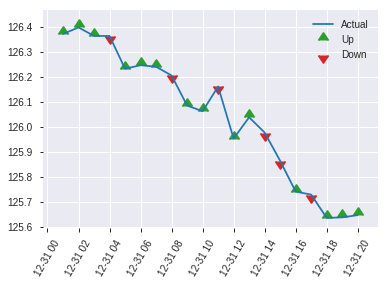


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20269531448154096
RMSE: 0.45021696378695125
LogLoss: 0.5900583468095572
Mean Per-Class Error: 0.31049981075739097
AUC: 0.7509462130451238
pr_auc: 0.711058496225562
Gini: 0.5018924260902475
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29183411598205566: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  193  0.6108   (193.0/316.0)
1      23   278  0.0764   (23.0/301.0)
Total  146  471  0.3501   (216.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.291834     0.720207  299
max f2                       0.191144     0.845231  347
max f0point5                 0.51802      0.681661  184
max accuracy                 0.484847     0.688817  204
max precision                0.856644     0.846154  11
max recall                   0.113751     1         382
max specificity              0.919045     0.996835  0
max absolute_mcc             0.484847     0.379308  204
max min_per_class_accuracy   0.504881     0.681063  195
max mean_per_class_accuracy  0.484847     0.6895    204

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 47.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.889968           1.46417   1.46417            0.714286         0.902875  0.714286                    0.902875            0.0166113       0.0166113                  46.4167   46.4167
    2        0.0210697                   0.85567            2.04983   1.73447            1                0.868481  0.846154                    0.887001            0.0199336       0.0365449                  104.983   73.4475
    3        0.0307942                   0.837245           1.36656   1.61829            0.666667         0.84645   0.789474                    0.874195            0.013289        0.0498339                  36.6556   61.829
    4        0.0405186                   0.826039           2.04983   1.72186            1                0.832072  0.84                        0.864086            0.0199336       0.0697674                  104.983   72.186
    5        0.0502431                   0.816713           1.70819   1.71922            0.833333         0.821554  0.83871                     0.855854            0.0166113       0.0863787                  70.8195   71.9216
    6        0.100486                    0.745096           1.65309   1.68615            0.806452         0.784593  0.822581                    0.820224            0.0830565       0.169435                   65.3092   68.6154
    7        0.150729                    0.688525           1.65309   1.67513            0.806452         0.71626   0.817204                    0.785569            0.0830565       0.252492                   65.3092   67.5133
    8        0.200972                    0.647404           1.3886    1.6035             0.677419         0.664347  0.782258                    0.755264            0.0697674       0.322259                   38.8597   60.3499
    9        0.299838                    0.591491           1.31055   1.5069             0.639344         0.620962  0.735135                    0.71098             0.129568        0.451827                   31.055    50.6905
    10       0.400324                    0.548752           1.1241    1.41082            0.548387         0.568823  0.688259                    0.675297            0.112957        0.564784                   12.4102   41.0817
    11       0.50081                     0.501933           1.22329   1.37319            0.596774         0.524899  0.669903                    0.64512             0.122924        0.687708                   22.3288   37.319
    12       0.599676                    0.425086           0.907304  1.29638            0.442623         0.464718  0.632432                    0.615378            0.089701        0.777409                   -9.26965  29.6381
    13       0.700162                    0.341277           0.859608  1.2337             0.419355         0.387417  0.601852                    0.582662            0.0863787       0.863787                   -14.0392  23.3696
    14       0.799028                    0.249424           0.739284  1.17252            0.360656         0.297412  0.572008                    0.547367            0.0730897       0.936877                   -26.0716  17.2522
    15       0.899514                    0.18154            0.462866  1.09324            0.225806         0.217313  0.533333                    0.510496            0.0465116       0.983389                   -53.7134  9.32447
    16       1                           0.0684942          0.165309  1                  0.0806452        0.131469  0.487844                    0.472409            

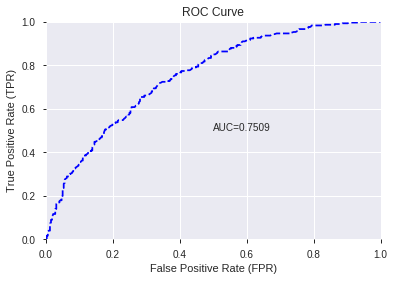

This function is available for GLM models only


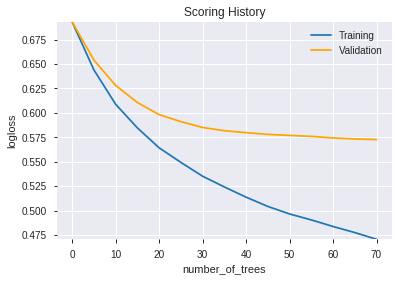

--2019-08-24 13:54:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_135224_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_135224_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_135550_model_8  0.744191  0.597589              0.304970  0.453825  0.205957
1  DeepLearning_grid_1_AutoML_20190824_135550_model_6  0.741994  0.601056              0.300381  0.454993  0.207018
2  DeepLearning_grid_1_AutoML_20190824_135550_model_9  0.741768  0.607553              0.316125  0.457327  0.209148
3  DeepLearning_grid_1_AutoML_20190824_135550_model_5  0.731459  0.608832              0.319920  0.458733  0.210436
4               DeepLearning_1_AutoML_20190824_135550  0.726418  0.623391              0.357979  0.462564  0.213965
5  DeepLearning_grid_1_AutoML_20190824_135550_model_2  0.715479  0.829065              0.367793  0.510406  0.260515
6  DeepLearning_grid_1_AutoML_20190824_135550_model_7  0.714853  0.665671              0.363125  0.479548  0.229966
7  DeepLearning_grid_1_AutoML_20190824_135550_model_3  0.695519  0.692147              0.395722  0.483094  0.233379
8  DeepLearning_grid_1_AutoML_20190824_135550_model_4  0.691393  0.673160              0.394928  0.481510  0.231852
9  DeepLearning_grid_1_AutoML_20190824_135550_model_1  0.651736  0.849830              0.425628  0.526522  0.277225

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.048059
1     CDLCLOSINGMARUBOZU             0.752289           0.752289    0.036154
2           CDLSHORTLINE             0.516474           0.516474    0.024821
3                 TRANGE             0.514726           0.514726    0.024737
4           HT_TRENDMODE             0.497086           0.497086    0.023889
5             aroonup_14             0.495202           0.495202    0.023799
6                    OBV             0.491194           0.491194    0.023606
7                    SUB             0.489032           0.489032    0.023502
8                 SAREXT             0.480515           0.480515    0.023093
9            CDLMARUBOZU             0.464124           0.464124    0.022305
10              CORREL_8             0.449287           0.449287    0.021592
11        CDLRICKSHAWMAN             0.448445           0.448445    0.021552
12           STOCH_slowd             0.444021           0.444021    0.021339
13            PLUS_DI_12             0.423803           0.423803    0.020368
14                  hour             0.419787           0.419787    0.020175
15               CDLDOJI             0.419321           0.419321    0.020152
16           HT_DCPERIOD             0.415696           0.415696    0.019978
17                   DIV             0.415592           0.415592    0.019973
18           CDLLONGLINE             0.415240           0.415240    0.019956
19                 month             0.413546           0.413546    0.019875
20          aroondown_24             0.411470           0.411470    0.019775
21             dayofyear             0.410034           0.410034    0.019706
22                ULTOSC             0.402970           0.402970    0.019366
23          STOCHF_fastk             0.398850           0.398850    0.019168
24              WILLR_14             0.390710           0.390710    0.018777
25        STOCHRSI_fastk             0.389097           0.389097    0.018700
26             aroonup_8             0.387181           0.387181    0.018608
27               BETA_14             0.375755           0.375755    0.018058
28             CDLHAMMER             0.375135           0.375135    0.018029
29           CDLBELTHOLD             0.374178           0.374178    0.017983
30     CDLLONGLEGGEDDOJI             0.370671           0.370671    0.017814
31                 ADOSC             0.370556           0.370556    0.017809
32      CDLDRAGONFLYDOJI             0.367213           0.367213    0.017648
33              WILLR_20             0.366489           0.366489    0.017613
34             CDLTAKURI             0.358460           0.358460    0.017227
35            CDLHIKKAKE             0.358235           0.358235    0.017216
36         CDLHANGINGMAN             0.357352           0.357352    0.017174
37             PLUS_DM_8             0.355159           0.355159    0.017069
38                BETA_8             0.351053           0.351053    0.016871
39  HT_PHASOR_quadrature             0.350701           0.350701    0.016854
40          CDLENGULFING             0.350418           0.350418    0.016841
41     CDLGRAVESTONEDOJI             0.349050           0.349050    0.016775
42              WILLR_12             0.342794           0.342794    0.016474
43            PLUS_DM_12             0.338249           0.338249    0.016256
44               WILLR_8             0.334083           0.334083    0.016056
45            PLUS_DM_14             0.333230           0.333230    0.016015
46     CDLINVERTEDHAMMER             0.331368           0.331368    0.015925
47             CDLHARAMI             0.329658           0.329658    0.015843
48                 RSI_8             0.317224           0.317224    0.015245
49                 CMO_8             0.295031           0.295031    0.014179

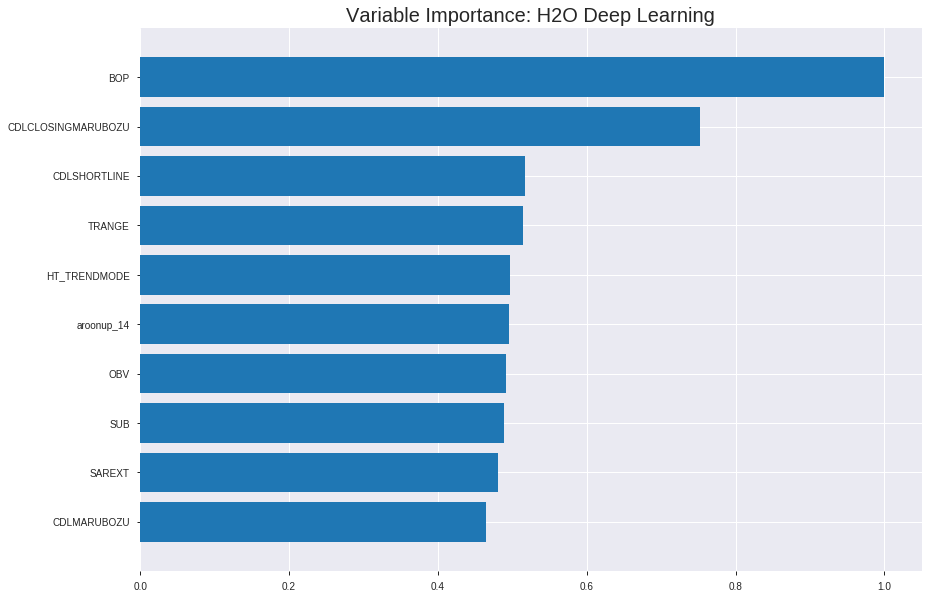

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_135550_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19171946501944967
RMSE: 0.43785781370149107
LogLoss: 0.5632371173120384
Mean Per-Class Error: 0.29316262413538774
AUC: 0.781136907594818
pr_auc: 0.7507057810602887
Gini: 0.562273815189636
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4151963047029076: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1122  1132  0.5022   (1132.0/2254.0)
1      254   1808  0.1232   (254.0/2062.0)
Total  1376  2940  0.3211   (1386.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415196     0.722911  240
max f2                       0.185404     0.839927  331
max f0point5                 0.543077     0.699733  170
max accuracy                 0.522594     0.706673  184
max precision                0.981901     1         0
max recall                   0.031705     1         392
max specificity              0.981901     1         0
max absolute_mcc             0.496692     0.416385  202
max min_per_class_accuracy   0.52172      0.703686  185
max mean_per_class_accuracy  0.507754     0.706837  196

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.952193           1.90283   1.90283            0.909091         0.963552   0.909091                    0.963552            0.0193986       0.0193986                  90.283    90.283
    2        0.0201576                   0.938              1.80105   1.85253            0.860465         0.945814   0.885057                    0.954785            0.0179437       0.0373424                  80.1051   85.2526
    3        0.0301205                   0.91274            1.84973   1.8516             0.883721         0.923807   0.884615                    0.944538            0.0184287       0.0557711                  84.9728   85.16
    4        0.0400834                   0.895075           2.09311   1.91163            1                0.90319    0.913295                    0.934261            0.0208535       0.0766246                  109.311   91.163
    5        0.0500463                   0.875044           1.80105   1.88962            0.860465         0.885306   0.902778                    0.924515            0.0179437       0.0945684                  80.1051   88.9616
    6        0.100093                    0.774395           1.79271   1.84116            0.856481         0.822494   0.87963                     0.873505            0.0897187       0.184287                   79.2713   84.1165
    7        0.150139                    0.721001           1.63767   1.77333            0.782407         0.744072   0.847222                    0.83036             0.0819593       0.266246                   63.7667   77.3332
    8        0.200185                    0.67757            1.48262   1.70065            0.708333         0.698507   0.8125                      0.797397            0.0741998       0.340446                   48.2622   70.0655
    9        0.300046                    0.60376            1.35494   1.58559            0.647332         0.640168   0.757529                    0.745068            0.135306        0.475752                   35.4939   58.5594
    10       0.400139                    0.54242            1.31789   1.51863            0.62963          0.571452   0.725536                    0.701639            0.131911        0.607662                   31.7886   51.8628
    11       0.5                         0.519715           1.07327   1.42968            0.512761         0.528547   0.68304                     0.667069            0.107177        0.71484                    7.3267    42.968
    12       0.600093                    0.484863           0.944808  1.34881            0.451389         0.506489   0.644402                    0.640285            0.0945684       0.809408                   -5.51918  34.8806
    13       0.699954                    0.396067           0.767313  1.26585            0.366589         0.442078   0.604767                    0.612007            0.0766246       0.886033                   -23.2687  26.5845
    14       0.800046                    0.273035           0.600801  1.18264            0.287037         0.336841   0.565016                    0.577581            0.0601358       0.946169                   -39.9199  18.2642
    15       0.899907                    0.141044           0.398226  1.0956             0.190255         0.2091     0.523429                    0.536692            0.0397672       0.985936                   -60.1774  9.55972
    16       1                           0.00815773         0.14051   1                  0.0671296        0.0827686  0.477757                    0.49



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19930870661271635
RMSE: 0.44644003697329426
LogLoss: 0.5844045595821595
Mean Per-Class Error: 0.308850776758991
AUC: 0.760457081624358
pr_auc: 0.7199845637836721
Gini: 0.520914163248716
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4497761295403184: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      366  285  0.4378   (285.0/651.0)
1      105  477  0.1804   (105.0/582.0)
Total  471  762  0.3163   (390.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449776     0.709821  223
max f2                       0.160036     0.833817  351
max f0point5                 0.515719     0.673943  182
max accuracy                 0.515719     0.691809  182
max precision                0.97766      1         0
max recall                   0.0480727    1         394
max specificity              0.97766      1         0
max absolute_mcc             0.449776     0.392283  223
max min_per_class_accuracy   0.512213     0.689003  185
max mean_per_class_accuracy  0.487268     0.691149  204

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 48.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.955443           1.62966   1.62966            0.769231         0.962891  0.769231                    0.962891            0.0171821       0.0171821                  62.9659    62.9659
    2        0.0202758                   0.94035            1.94201   1.77959            0.916667         0.946512  0.84                        0.955029            0.0189003       0.0360825                  94.201     77.9588
    3        0.0300081                   0.925682           1.76546   1.77501            0.833333         0.9354    0.837838                    0.948663            0.0171821       0.0532646                  76.5464    77.5007
    4        0.0405515                   0.908716           1.79262   1.77959            0.846154         0.91873   0.84                        0.940881            0.0189003       0.0721649                  79.2625    77.9588
    5        0.0502839                   0.884478           1.58892   1.74268            0.75             0.89831   0.822581                    0.932641            0.0154639       0.0876289                  58.8918    74.2684
    6        0.100568                    0.754928           1.84519   1.79394            0.870968         0.825161  0.846774                    0.878901            0.0927835       0.180412                   84.5195    79.3939
    7        0.150041                    0.679356           1.66706   1.7521             0.786885         0.714527  0.827027                    0.824702            0.0824742       0.262887                   66.7061    75.2104
    8        0.200324                    0.638889           1.53766   1.69828            0.725806         0.659225  0.801619                    0.783165            0.0773196       0.340206                   53.7662    69.8276
    9        0.300081                    0.566265           1.24013   1.54597            0.585366         0.597377  0.72973                     0.721403            0.123711        0.463918                   24.0131    54.5974
    10       0.399838                    0.526225           1.18846   1.45678            0.560976         0.543374  0.687627                    0.676986            0.118557        0.582474                   18.8459    45.6776
    11       0.500406                    0.508202           1.12762   1.39062            0.532258         0.517546  0.656402                    0.644943            0.113402        0.695876                   12.7619    39.0625
    12       0.600162                    0.461494           0.998994  1.32553            0.471545         0.489331  0.625676                    0.619078            0.0996564       0.795533                   -0.100578  32.5529
    13       0.699919                    0.391414           0.843978  1.2569             0.398374         0.428069  0.593279                    0.591854            0.0841924       0.879725                   -15.6022   25.6896
    14       0.799676                    0.286245           0.533945  1.16671            0.252033         0.339473  0.55071                     0.560371            0.0532646       0.93299                    -46.6055   16.671
    15       0.899432                    0.168114           0.465049  1.08889            0.219512         0.229975  0.513977                    0.523726            0.0463918       0.979381                   -53.4951   8.88885
    16       1                           0.0201104          0.205022  1                  0.0967742        0.105631  0.472019                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:10:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 14:10:05  4 min  7.122 sec  483 obs/sec       0.242354  1             1046       0.492728         0.714043            0.0269524      0.719086        0.684773           1.9504           0.380213                         0.505432           0.756055              -0.0250567       0.703404          0.668661             1.95559            0.402271
    2019-08-24 14:10:42  4 min 44.301 sec  983 obs/sec       8.13554   34            35113      0.437858         0.563237            0.231602       0.781137        0.750706           1.90283          0.321131                         0.44644            0.584405              0.200261         0.760457          0.719985             1.62966            0.316302
    2019-08-24 14:11:19  5 min 21.209 sec  1096 obs/sec      17.4928   73            75499      0.434237         0.555755            0.244257       0.797616        0.766391           1.90283          0.284986                         0.453649           0.596762              0.174224         0.750408          0.713864             1.79262            0.323601
    2019-08-24 14:11:57  5 min 58.421 sec  1166 obs/sec      27.6557   115           119362     0.428351         0.545013            0.264605       0.80909         0.780835           1.90283          0.286608                         0.451336           0.59759               0.182624         0.756408          0.713544             2.11856            0.334144
    2019-08-24 14:12:34  6 min 35.757 sec  1212 obs/sec      38.2111   159           164919     0.422231         0.529307            0.28547        0.822555        0.799368           2.09311          0.282669                         0.452875           0.596288              0.177038         0.758971          0.716678             1.95559            0.335766
    2019-08-24 14:13:11  7 min 13.216 sec  1246 obs/sec      49.0331   204           211627     0.409351         0.501651            0.328398       0.835902        0.81447            2.04554          0.264365                         0.456604           0.610063              0.163433         0.751799          0.719448             2.11856            0.309813
    2019-08-24 14:13:48  7 min 50.389 sec  1271 obs/sec      59.8839   249           258459     0.39615          0.470805            0.371017       0.855211        0.836604           2.04554          0.243976                         0.455057           0.610667              0.169091         0.756564          0.72208              1.95559            0.349554
    2019-08-24 14:13:52  7 min 54.110 sec  1271 obs/sec      59.8839   249           258459     0.437858         0.563237            0.231602       0.781137        0.750706           1.90283          0.321131                         0.44644            0.584405              0.200261         0.760457          0.719985             1.62966            0.316302

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04805901285488997
CDLCLOSINGMARUBOZU  0.7522890567779541     0.7522890567779541   0.03615426945028474
CDLSHORTLINE        0.5164743661880493     0.5164743661880493   0.02482124820385261
TRANGE              0.5147258639335632     0.5147258639335632   0.02473721691152746
HT_TRENDMODE        0.4970860183238983     0.4970860183238983   0.0238894633446143
---                 ---                    ---                  ---
PLUS_DM_14          0.33322951197624207    0.33322951197624207  0.01601468139969493
CDLINVERTEDHAMMER   0.3313678503036499     0.3313678503036499   0.015925211777440364
CDLHARAMI           0.3296584486961365     0.3296584486961365   0.015843059623610708
RSI_8               0.3172241747379303     0.3172241747379303   0.015245480691612053
CMO_8               0.2950308918952942     0.2950308918952942   0.014178893426185595


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6920583468395461)

('F1', 0.7214076246334311)

('auc', 0.7441913032507674)

('logloss', 0.5975890306594647)

('mean_per_class_error', 0.30496972118255594)

('rmse', 0.45382478733920817)

('mse', 0.2059569376034775)

deeplearning prediction progress: |███████████████████████████████████████| 100%


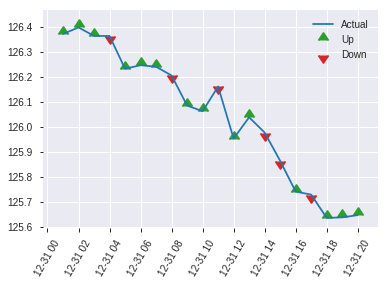


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2059569376034775
RMSE: 0.45382478733920817
LogLoss: 0.5975890306594647
Mean Per-Class Error: 0.30496972118255594
AUC: 0.7441913032507674
pr_auc: 0.7208223093589637
Gini: 0.48838260650153487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47817824639636775: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      181  135  0.4272   (135.0/316.0)
1      55   246  0.1827   (55.0/301.0)
Total  236  381  0.3079   (190.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478178     0.721408  218
max f2                       0.272547     0.834296  329
max f0point5                 0.478178     0.673973  218
max accuracy                 0.478178     0.692058  218
max precision                0.960666     1         0
max recall                   0.0587254    1         392
max specificity              0.960666     1         0
max absolute_mcc             0.478178     0.401181  218
max min_per_class_accuracy   0.510899     0.674419  188
max mean_per_class_accuracy  0.478178     0.69503   218

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 49.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.944899           2.04983   2.04983            1                0.955572  1                           0.955572            0.0232558       0.0232558                  104.983   104.983
    2        0.0210697                   0.932963           1.70819   1.89215            0.833333         0.939447  0.923077                    0.94813             0.0166113       0.0398671                  70.8195   89.2154
    3        0.0307942                   0.902497           2.04983   1.94195            1                0.91886   0.947368                    0.938887            0.0199336       0.0598007                  104.983   94.1948
    4        0.0405186                   0.897089           1.36656   1.80385            0.666667         0.899703  0.88                        0.929483            0.013289        0.0730897                  36.6556   80.3854
    5        0.0502431                   0.870178           1.70819   1.78534            0.833333         0.887126  0.870968                    0.921285            0.0166113       0.089701                   70.8195   78.5339
    6        0.100486                    0.740297           1.65309   1.71922            0.806452         0.808985  0.83871                     0.865135            0.0830565       0.172757                   65.3092   71.9216
    7        0.150729                    0.671238           1.58697   1.67513            0.774194         0.695056  0.817204                    0.808442            0.0797342       0.252492                   58.6968   67.5133
    8        0.200972                    0.627383           1.05798   1.52084            0.516129         0.648387  0.741935                    0.768428            0.0531561       0.305648                   5.79788   52.0844
    9        0.299838                    0.55241            1.44496   1.49582            0.704918         0.584545  0.72973                     0.707796            0.142857        0.448505                   44.4965   49.5825
    10       0.400324                    0.520971           1.09104   1.39422            0.532258         0.53126   0.680162                    0.663484            0.109635        0.55814                    9.10406   39.4219
    11       0.50081                     0.509361           1.22329   1.35992            0.596774         0.515293  0.66343                     0.63375             0.122924        0.681063                   22.3288   35.9922
    12       0.599676                    0.483775           1.07532   1.313              0.52459          0.498258  0.640541                    0.611412            0.106312        0.787375                   7.53227   31.3002
    13       0.700162                    0.419873           0.72736   1.22895            0.354839         0.453432  0.599537                    0.588739            0.0730897       0.860465                   -27.264   22.8951
    14       0.799028                    0.314966           0.638473  1.15589            0.311475         0.369075  0.563895                    0.561559            0.0631229       0.923588                   -36.1527  15.589
    15       0.899514                    0.227188           0.462866  1.07847            0.225806         0.274721  0.526126                    0.529516            0.0465116       0.9701                     -53.7134  7.84712
    16       1                           0.030018           0.297557  1                  0.145161         0.144688  0.487844                    0.490846          

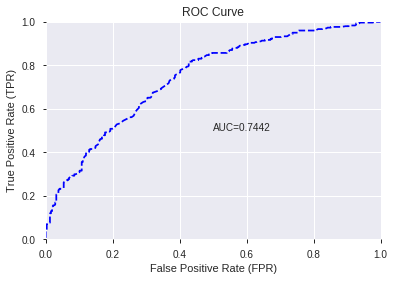

This function is available for GLM models only


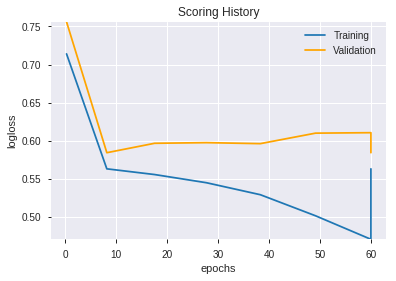

--2019-08-24 14:20:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_135550_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_135550_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'TRANGE',
 'HT_TRENDMODE',
 'aroonup_14',
 'OBV',
 'SUB',
 'SAREXT',
 'CDLMARUBOZU',
 'CORREL_8',
 'CDLRICKSHAWMAN',
 'STOCH_slowd',
 'PLUS_DI_12',
 'hour',
 'CDLDOJI',
 'HT_DCPERIOD',
 'DIV',
 'CDLLONGLINE',
 'month',
 'aroondown_24',
 'dayofyear',
 'ULTOSC',
 'STOCHF_fastk',
 'WILLR_14',
 'STOCHRSI_fastk',
 'aroonup_8',
 'BETA_14',
 'CDLHAMMER',
 'CDLBELTHOLD',
 'CDLLONGLEGGEDDOJI',
 'ADOSC',
 'CDLDRAGONFLYDOJI',
 'WILLR_20',
 'CDLTAKURI',
 'CDLHIKKAKE',
 'CDLHANGINGMAN',
 'PLUS_DM_8',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'CDLENGULFING',
 'CDLGRAVESTONEDOJI',
 'WILLR_12',
 'PLUS_DM_12',
 'WILLR_8',
 'PLUS_DM_14',
 'CDLINVERTEDHAMMER',
 'CDLHARAMI',
 'RSI_8',
 'CMO_8']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190824_142121_model_1  0.748649  0.596206              0.316209  0.45246  0.20472

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.773230           1.000000    0.190151
1             PLUS_DI_12             0.235781           0.304930    0.057983
2     CDLCLOSINGMARUBOZU             0.211517           0.273550    0.052016
3            STOCH_slowd             0.195799           0.253222    0.048150
4                 ULTOSC             0.157359           0.203509    0.038697
5                WILLR_8             0.148801           0.192440    0.036593
6                 TRANGE             0.143072           0.185032    0.035184
7              CDLHAMMER             0.138977           0.179735    0.034177
8                    SUB             0.131907           0.170592    0.032438
9             CDLHIKKAKE             0.130994           0.169412    0.032214
10                SAREXT             0.109570           0.141705    0.026945
11              WILLR_14             0.099699           0.128939    0.024518
12             PLUS_DM_8             0.093516           0.120942    0.022997
13          STOCHF_fastk             0.089032           0.115143    0.021895
14     CDLGRAVESTONEDOJI             0.087691           0.113409    0.021565
15             CDLTAKURI             0.083578           0.108089    0.020553
16          aroondown_24             0.075578           0.097743    0.018586
17           CDLBELTHOLD             0.073349           0.094861    0.018038
18         CDLHANGINGMAN             0.072324           0.093535    0.017786
19             aroonup_8             0.069004           0.089241    0.016969
20               CDLDOJI             0.066624           0.086163    0.016384
21            PLUS_DM_14             0.065876           0.085196    0.016200
22        CDLRICKSHAWMAN             0.049888           0.064519    0.012268
23     CDLINVERTEDHAMMER             0.049186           0.063611    0.012096
24               BETA_14             0.048439           0.062644    0.011912
25                 ADOSC             0.046460           0.060086    0.011425
26                BETA_8             0.046183           0.059727    0.011357
27        STOCHRSI_fastk             0.045380           0.058688    0.011160
28           CDLMARUBOZU             0.043997           0.056900    0.010820
29                   DIV             0.043628           0.056423    0.010729
30              CORREL_8             0.041230           0.053322    0.010139
31             dayofyear             0.040842           0.052819    0.010044
32          CDLSHORTLINE             0.039217           0.050718    0.009644
33                  hour             0.034029           0.044009    0.008368
34          CDLENGULFING             0.032508           0.042042    0.007994
35                 month             0.031984           0.041364    0.007865
36            aroonup_14             0.026338           0.034062    0.006477
37            PLUS_DM_12             0.025663           0.033189    0.006311
38     CDLLONGLEGGEDDOJI             0.024442           0.031610    0.006011
39      CDLDRAGONFLYDOJI             0.022710           0.029371    0.005585
40           CDLLONGLINE             0.021806           0.028201    0.005362
41              WILLR_12             0.018474           0.023892    0.004543
42             CDLHARAMI             0.018341           0.023720    0.004510
43              WILLR_20             0.015933           0.020605    0.003918
44           HT_DCPERIOD             0.014870           0.019231    0.003657
45          HT_TRENDMODE             0.012975           0.016781    0.003191
46                   OBV             0.007093           0.009173    0.001744
47                 CMO_8             0.005523           0.007143    0.001358
48                 RSI_8             0.004523           0.005849    0.001112
49  HT_PHASOR_quadrature             0.001466           0.001896    0.000360

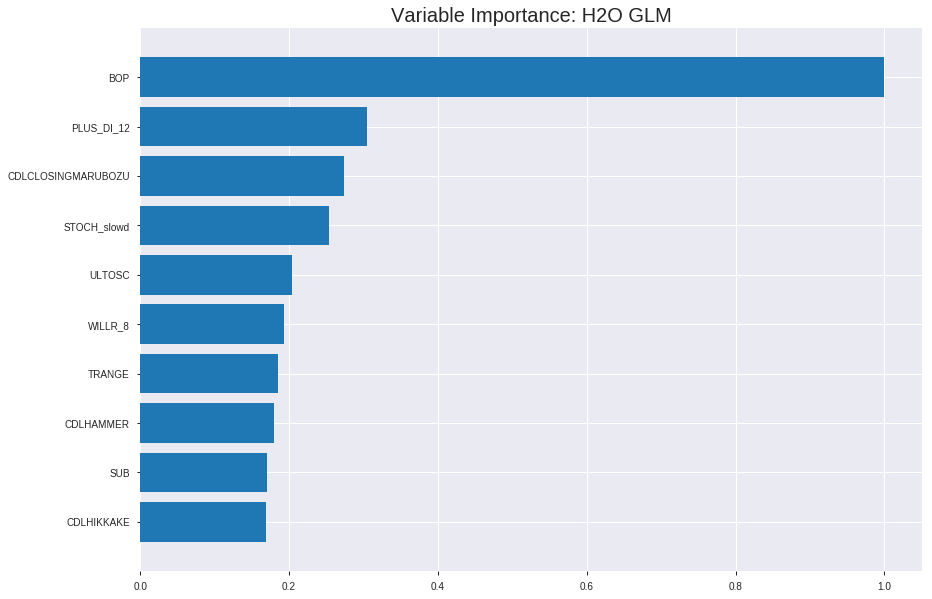

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_142121_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19275879936172105
RMSE: 0.4390430495540512
LogLoss: 0.5668178526502503
Null degrees of freedom: 4315
Residual degrees of freedom: 4265
Null deviance: 5974.702401324418
Residual deviance: 4892.77170407696
AIC: 4994.77170407696
AUC: 0.7750953795257401
pr_auc: 0.7435033112993242
Gini: 0.5501907590514803
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34439399107718804: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1124  1130  0.5013   (1130.0/2254.0)
1      253   1809  0.1227   (253.0/2062.0)
Total  1377  2939  0.3204   (1383.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344394     0.723455  261
max f2                       0.217842     0.838043  319
max f0point5                 0.557302     0.696624  165
max accuracy                 0.543664     0.705283  172
max precision                0.953377     1         0
max recall                   0.0354749    1         393
max specificity              0.953377     1         0
max absolute_mcc             0.412889     0.411275  232
max min_per_class_accuracy   0.507328     0.700976  190
max mean_per_class_accuracy  0.541337     0.703252  173

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 47.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101946                   0.905944           1.90283   1.90283            0.909091         0.921829   0.909091                    0.921829            0.0193986       0.0193986                  90.283     90.283
    2        0.0201576                   0.885977           1.89841   1.90064            0.906977         0.893638   0.908046                    0.907896            0.0189137       0.0383123                  89.8405    90.0643
    3        0.0301205                   0.873587           1.84973   1.8838             0.883721         0.879764   0.9                         0.898591            0.0184287       0.056741                   84.9728    88.3802
    4        0.0400834                   0.856193           1.89841   1.88743            0.906977         0.865758   0.901734                    0.89043             0.0189137       0.0756547                  89.8405    88.7432
    5        0.0500463                   0.833164           1.99576   1.909              0.953488         0.845327   0.912037                    0.881451            0.0198836       0.0955383                  99.5759    90.8997
    6        0.100093                    0.770086           1.69581   1.8024             0.810185         0.799534   0.861111                    0.840493            0.0848691       0.180407                   69.581     80.2403
    7        0.150139                    0.723196           1.56984   1.72488            0.75             0.744522   0.824074                    0.808502            0.0785645       0.258972                   56.9835    72.4881
    8        0.200185                    0.693396           1.42448   1.64978            0.680556         0.709326   0.788194                    0.783708            0.07129         0.330262                   42.448     64.978
    9        0.300046                    0.63273            1.42779   1.5759             0.682135         0.663107   0.752896                    0.74357             0.14258         0.472842                   42.7785    57.5896
    10       0.400139                    0.566779           1.31304   1.51014            0.627315         0.600079   0.721482                    0.707677            0.131426        0.604268                   31.3041    51.0144
    11       0.5                         0.501238           1.06355   1.42095            0.508121         0.53616    0.678869                    0.673421            0.106208        0.710475                   6.35542    42.0951
    12       0.600093                    0.410572           0.998105  1.35042            0.476852         0.454931   0.645174                    0.636978            0.099903        0.810378                   -0.189496  35.0422
    13       0.699954                    0.330446           0.777026  1.26862            0.37123          0.369276   0.606091                    0.598785            0.0775946       0.887973                   -22.2974   26.8617
    14       0.800046                    0.246684           0.586266  1.18325            0.280093         0.289266   0.565306                    0.560062            0.0586809       0.946654                   -41.3734   18.3249
    15       0.899907                    0.153264           0.335092  1.08913            0.160093         0.20263    0.52034                     0.520398            0.0334627       0.980116                   -66.4908   8.91304
    16       1                           0.00433131         0.198652  1                  0.0949074        0.0943823  0.477757    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19786600504334145
RMSE: 0.4448213181080033
LogLoss: 0.5784179941803964
Null degrees of freedom: 1232
Residual degrees of freedom: 1182
Null deviance: 1705.6003649118566
Residual deviance: 1426.378773648857
AIC: 1528.378773648857
AUC: 0.7633827946431871
pr_auc: 0.7307308630758859
Gini: 0.5267655892863743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3170601484670836: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      318  333  0.5115   (333.0/651.0)
1      78   504  0.134    (78.0/582.0)
Total  396  837  0.3333   (411.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.31706      0.710359  266
max f2                       0.192531     0.837533  329
max f0point5                 0.514607     0.682844  171
max accuracy                 0.514607     0.695864  171
max precision                0.957315     1         0
max recall                   0.0356646    1         395
max specificity              0.957315     1         0
max absolute_mcc             0.499213     0.388541  180
max min_per_class_accuracy   0.471841     0.687285  194
max mean_per_class_accuracy  0.499213     0.693406  180

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 44.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.899372           1.79262   1.79262            0.846154         0.920259   0.846154                    0.920259            0.0189003       0.0189003                  79.2625   79.2625
    2        0.0202758                   0.872254           1.94201   1.86433            0.916667         0.885913   0.88                        0.903773            0.0189003       0.0378007                  94.201    86.433
    3        0.0300081                   0.853314           1.76546   1.83227            0.833333         0.866164   0.864865                    0.891576            0.0171821       0.0549828                  76.5464   83.2265
    4        0.0405515                   0.83743            1.62966   1.77959            0.769231         0.845007   0.84                        0.879468            0.0171821       0.0721649                  62.9659   77.9588
    5        0.0502839                   0.828584           1.94201   1.81102            0.916667         0.833344   0.854839                    0.870541            0.0189003       0.0910653                  94.201    81.1024
    6        0.100568                    0.743935           1.87936   1.84519            0.887097         0.781695   0.870968                    0.826118            0.0945017       0.185567                   87.9365   84.5195
    7        0.150041                    0.688958           1.70179   1.79791            0.803279         0.714016   0.848649                    0.789154            0.0841924       0.269759                   70.1791   79.791
    8        0.200324                    0.651279           1.46932   1.71543            0.693548         0.670899   0.809717                    0.759471            0.0738832       0.343643                   46.9322   71.5431
    9        0.300081                    0.593958           1.22291   1.5517             0.577236         0.622087   0.732432                    0.7138              0.121993        0.465636                   22.2907   55.17
    10       0.399838                    0.528563           1.27458   1.48256            0.601626         0.560365   0.699797                    0.675519            0.127148        0.592784                   27.4579   48.256
    11       0.500406                    0.463354           1.02511   1.39062            0.483871         0.496387   0.656402                    0.639518            0.103093        0.695876                   2.51081   39.0625
    12       0.600162                    0.374857           0.964546  1.3198             0.455285         0.422036   0.622973                    0.603369            0.0962199       0.792096                   -3.54539  31.9804
    13       0.699919                    0.29914            0.843978  1.25199            0.398374         0.335182   0.590962                    0.565146            0.0841924       0.876289                   -15.6022  25.1986
    14       0.799676                    0.225937           0.671737  1.1796             0.317073         0.262653   0.556795                    0.527411            0.0670103       0.943299                   -32.8263  17.9602
    15       0.899432                    0.140522           0.378929  1.0908             0.178862         0.187642   0.514878                    0.489727            0.0378007       0.9811                     -62.1071  9.07988
    16       1                           0.0127485          0.187936  1                  0.0887097        0.0857498  0.472019                    0.44


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 14:21:22  0.000 sec   2            .21E2     51            1.3647279959382106  1.364897536420544
     2019-08-24 14:21:22  0.026 sec   4            .13E2     51            1.3546956746835226  1.3554331179129877
     2019-08-24 14:21:22  0.053 sec   6            .8E1      51            1.3407679982907899  1.3422417503308868
     2019-08-24 14:21:22  0.078 sec   8            .49E1     51            1.3225199145456805  1.324864409958923
     2019-08-24 14:21:22  0.105 sec   10           .31E1     51            1.3002052449876862  1.3034964502980526
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 14:21:22  0.477 sec   36           .63E-2    51            1.1324478075374211  1.1568968386342497
     2019-08-24 14:21:22  0.505 sec   38           .39E-2    51            1.131755001941175   1.1572268958528396
     2019-08-24 14:21:22  0.519 sec   39           .24E-2    51            1.1313137998472012  1.1576542842336048
     2019-08-24 14:21:22  0.535 sec   40           .15E-2    51            1.1309707038210413  1.1581185206599915
     2019-08-24 14:21:22  0.552 sec   41           .93E-3    51            1.1306299114630396  1.1586221865479767


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6888168557536467)

('F1', 0.7272727272727274)

('auc', 0.7486490180411287)

('logloss', 0.5962058562316731)

('mean_per_class_error', 0.31057866184448457)

('rmse', 0.45245980612270115)

('mse', 0.20471987615659232)

glm prediction progress: |████████████████████████████████████████████████| 100%


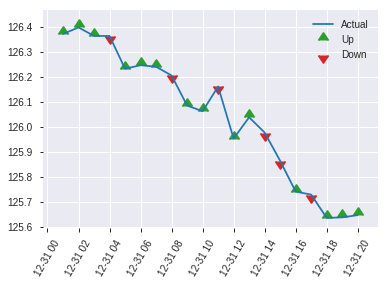


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20471987615659232
RMSE: 0.45245980612270115
LogLoss: 0.5962058562316731
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.2304056881629
Residual deviance: 735.7180265898846
AIC: 837.7180265898846
AUC: 0.7486490180411287
pr_auc: 0.7346411720764486
Gini: 0.4972980360822574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30728497002637584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      155  161  0.5095   (161.0/316.0)
1      37   264  0.1229   (37.0/301.0)
Total  192  425  0.3209   (198.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.307285     0.727273  273
max f2                       0.0638399    0.833333  389
max f0point5                 0.439248     0.678233  203
max accuracy                 0.439248     0.688817  203
max precision                0.941269     1         0
max recall                   0.0638399    1         389
max specificity              0.941269     1         0
max absolute_mcc             0.307285     0.39686   273
max min_per_class_accuracy   0.451207     0.683544  196
max mean_per_class_accuracy  0.439248     0.689421  203

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 44.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.885702           2.04983   2.04983            1                0.90274    1                           0.90274             0.0232558       0.0232558                  104.983   104.983
    2        0.0210697                   0.869974           2.04983   2.04983            1                0.877629   1                           0.89115             0.0199336       0.0431894                  104.983   104.983
    3        0.0307942                   0.849366           1.70819   1.94195            0.833333         0.856982   0.947368                    0.88036             0.0166113       0.0598007                  70.8195   94.1948
    4        0.0405186                   0.83326            1.70819   1.88585            0.833333         0.841595   0.92                        0.871057            0.0166113       0.076412                   70.8195   88.5847
    5        0.0502431                   0.818977           2.04983   1.91759            1                0.82561    0.935484                    0.86226             0.0199336       0.0963455                  104.983   91.7587
    6        0.100486                    0.738942           1.71922   1.8184             0.83871          0.780079   0.887097                    0.82117             0.0863787       0.182724                   71.9216   81.8401
    7        0.150729                    0.686891           1.45472   1.69717            0.709677         0.706904   0.827957                    0.783081            0.0730897       0.255814                   45.4721   69.7174
    8        0.200972                    0.652699           1.25635   1.58697            0.612903         0.668464   0.774194                    0.754427            0.0631229       0.318937                   25.635    58.6968
    9        0.299838                    0.585399           1.27695   1.48474            0.622951         0.616286   0.724324                    0.708878            0.126246        0.445183                   27.6946   48.4745
    10       0.400324                    0.521848           1.22329   1.41912            0.596774         0.54782    0.692308                    0.66845             0.122924        0.568106                   22.3288   41.9116
    11       0.50081                     0.44896            1.22329   1.37982            0.596774         0.486007   0.673139                    0.631843            0.122924        0.69103                    22.3288   37.9823
    12       0.599676                    0.381012           1.00812   1.31854            0.491803         0.414444   0.643243                    0.596002            0.0996678       0.790698                   0.811503  31.8542
    13       0.700162                    0.299518           0.89267   1.25742            0.435484         0.335318   0.613426                    0.558589            0.089701        0.880399                   -10.733   25.7421
    14       0.799028                    0.206625           0.537661  1.16836            0.262295         0.254695   0.56998                     0.520988            0.0531561       0.933555                   -46.2339  16.8364
    15       0.899514                    0.124805           0.297557  1.07108            0.145161         0.171294   0.522523                    0.481923            0.0299003       0.963455                   -70.2443  7.10844
    16       1                           0.0233098          0.36368   1                  0.177419         0.0819425  0.487844                   

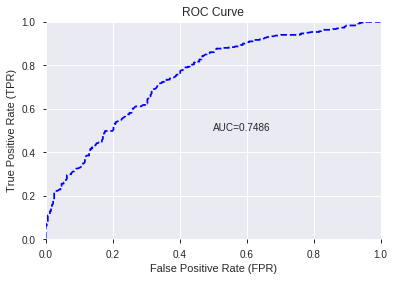

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


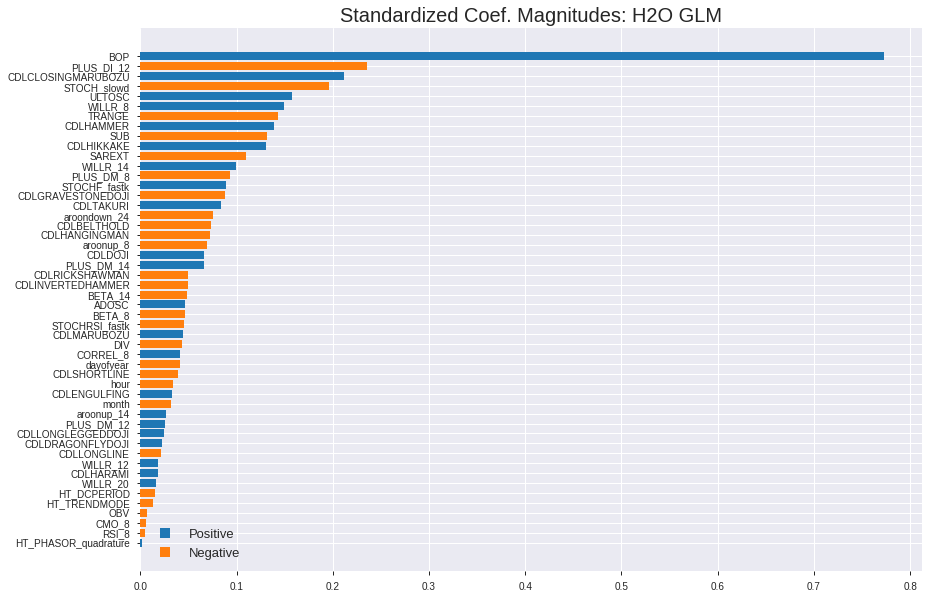

'log_likelihood'
--2019-08-24 14:21:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_142121_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_142121_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'PLUS_DI_12',
 'CDLCLOSINGMARUBOZU',
 'STOCH_slowd',
 'ULTOSC',
 'WILLR_8',
 'TRANGE',
 'CDLHAMMER',
 'SUB',
 'CDLHIKKAKE',
 'SAREXT',
 'WILLR_14',
 'PLUS_DM_8',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'aroondown_24',
 'CDLBELTHOLD',
 'CDLHANGINGMAN',
 'aroonup_8',
 'CDLDOJI',
 'PLUS_DM_14',
 'CDLRICKSHAWMAN',
 'CDLINVERTEDHAMMER',
 'BETA_14',
 'ADOSC',
 'BETA_8',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'DIV',
 'CORREL_8',
 'dayofyear',
 'CDLSHORTLINE',
 'hour',
 'CDLENGULFING',
 'month',
 'aroonup_14',
 'PLUS_DM_12',
 'CDLLONGLEGGEDDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLINE',
 'WILLR_12',
 'CDLHARAMI',
 'WILLR_20',
 'HT_DCPERIOD',
 'HT_TRENDMODE',
 'OBV',
 'CMO_8',
 'RSI_8',
 'HT_PHASOR_quadrature']

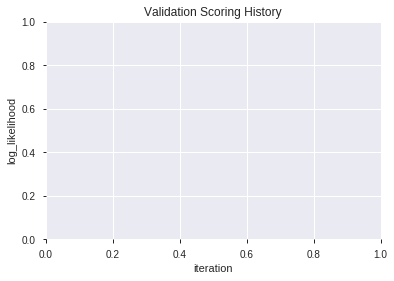

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_142229  0.757501  0.587310              0.306000  0.448554  0.201200
1  XGBoost_grid_1_AutoML_20190824_142229_model_2  0.754552  0.592099              0.298798  0.450727  0.203155
2               XGBoost_1_AutoML_20190824_142229  0.753522  0.592498              0.335117  0.450281  0.202753
3  XGBoost_grid_1_AutoML_20190824_142229_model_1  0.752118  0.590408              0.315178  0.450215  0.202693
4  XGBoost_grid_1_AutoML_20190824_142229_model_6  0.751540  0.591342              0.317313  0.450479  0.202932
5  XGBoost_grid_1_AutoML_20190824_142229_model_3  0.748943  0.595883              0.336147  0.452947  0.205161
6  XGBoost_grid_1_AutoML_20190824_142229_model_4  0.746488  0.594313              0.309322  0.451808  0.204130
7  XGBoost_grid_1_AutoML_20190824_142229_model_7  0.742309  0.603150              0.318022  0.455615  0.207585
8               XGBoost_2_AutoML_20190824_142229  0.739902  0.602857              0.333535  0.455320  0.207316
9  XGBoost_grid_1_AutoML_20190824_142229_model_5  0.718276  0.632591              0.336379  0.468042  0.219063

variable  relative_importance  scaled_importance  percentage
0                    BOP          5221.853027           1.000000    0.326745
1           STOCHF_fastk          1069.867554           0.204883    0.066944
2         STOCHRSI_fastk           769.352356           0.147333    0.048140
3                 TRANGE           547.011353           0.104754    0.034228
4                    SUB           542.946289           0.103976    0.033974
5                    DIV           513.456238           0.098328    0.032128
6     CDLCLOSINGMARUBOZU           502.854706           0.096298    0.031465
7              PLUS_DM_8           400.996246           0.076792    0.025091
8              dayofyear           334.502106           0.064058    0.020931
9                   hour           321.238342           0.061518    0.020101
10                 ADOSC           306.464600           0.058689    0.019176
11                   OBV           288.432098           0.055236    0.018048
12           HT_DCPERIOD           279.299377           0.053487    0.017477
13           STOCH_slowd           278.836456           0.053398    0.017448
14               WILLR_8           275.400269           0.052740    0.017233
15            aroonup_14           271.384735           0.051971    0.016981
16              CORREL_8           262.226227           0.050217    0.016408
17              WILLR_14           255.780869           0.048983    0.016005
18            PLUS_DI_12           254.600754           0.048757    0.015931
19                BETA_8           243.952332           0.046718    0.015265
20  HT_PHASOR_quadrature           238.104828           0.045598    0.014899
21                SAREXT           232.943268           0.044609    0.014576
22             aroonup_8           231.236343           0.044282    0.014469
23            PLUS_DM_12           218.321259           0.041809    0.013661
24               BETA_14           217.381271           0.041629    0.013602
25             CDLHAMMER           203.724564           0.039014    0.012748
26            PLUS_DM_14           192.789673           0.036920    0.012063
27              WILLR_12           185.016251           0.035431    0.011577
28                ULTOSC           163.034058           0.031221    0.010201
29              WILLR_20           155.533325           0.029785    0.009732
30          aroondown_24           137.592743           0.026349    0.008610
31            CDLHIKKAKE           130.168442           0.024928    0.008145
32                 CMO_8           103.719757           0.019863    0.006490
33             CDLTAKURI            96.830261           0.018543    0.006059
34      CDLDRAGONFLYDOJI            95.144424           0.018220    0.005953
35     CDLGRAVESTONEDOJI            73.811874           0.014135    0.004619
36          CDLSHORTLINE            71.755455           0.013741    0.004490
37           CDLLONGLINE            68.585266           0.013134    0.004292
38                 RSI_8            56.294540           0.010781    0.003522
39        CDLRICKSHAWMAN            53.555862           0.010256    0.003351
40           CDLBELTHOLD            35.928402           0.006880    0.002248
41               CDLDOJI            21.291580           0.004077    0.001332
42          HT_TRENDMODE            20.883286           0.003999    0.001307
43                 month            17.799278           0.003409    0.001114
44         CDLHANGINGMAN             8.974592           0.001719    0.000562
45     CDLLONGLEGGEDDOJI             8.459269           0.001620    0.000529
46          CDLENGULFING             2.081532           0.000399    0.000130

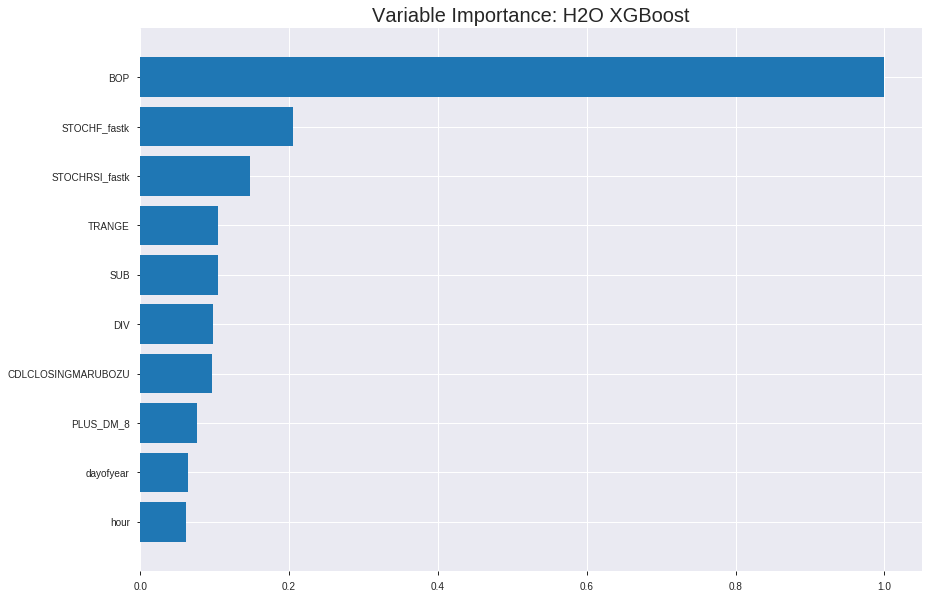

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_142229


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16085102976327778
RMSE: 0.40106237639957926
LogLoss: 0.49122522947807407
Mean Per-Class Error: 0.22930137348238333
AUC: 0.8595260543385743
pr_auc: 0.8511670243656146
Gini: 0.7190521086771486
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4711126254664527: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1590  664   0.2946   (664.0/2254.0)
1      357   1705  0.1731   (357.0/2062.0)
Total  1947  2369  0.2366   (1021.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471113     0.769578  211
max f2                       0.305575     0.865924  284
max f0point5                 0.590581     0.77723   151
max accuracy                 0.502451     0.769926  195
max precision                0.953156     1         0
max recall                   0.130079     1         361
max specificity              0.953156     1         0
max absolute_mcc             0.502451     0.540892  195
max min_per_class_accuracy   0.514418     0.767524  190
max mean_per_class_accuracy  0.502451     0.770699  195

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 47.79 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.918916           2.09311    2.09311            1                0.933323  1                           0.933323            0.0213385       0.0213385                  109.311   109.311
    2        0.0201576                   0.89005            2.04444    2.06905            0.976744         0.903186  0.988506                    0.918428            0.0203686       0.0417071                  104.444   106.905
    3        0.0301205                   0.874305           2.09311    2.07701            1                0.882133  0.992308                    0.906422            0.0208535       0.0625606                  109.311   107.701
    4        0.0400834                   0.85639            2.09311    2.08101            1                0.865502  0.99422                     0.896251            0.0208535       0.0834142                  109.311   108.101
    5        0.0500463                   0.837778           2.04444    2.07373            0.976744         0.847731  0.990741                    0.886592            0.0203686       0.103783                   104.444   107.373
    6        0.100093                    0.759915           2.02528    2.04951            0.967593         0.79591   0.979167                    0.841251            0.101358        0.205141                   102.528   104.951
    7        0.150139                    0.716565           1.87993    1.99298            0.898148         0.737521  0.95216                     0.806674            0.0940834       0.299224                   87.9926   99.298
    8        0.200185                    0.681289           1.72488    1.92596            0.824074         0.698575  0.920139                    0.779649            0.086324        0.385548                   72.4881   92.5955
    9        0.300046                    0.626087           1.56862    1.80703            0.74942          0.652595  0.86332                     0.737363            0.156644        0.542192                   56.8621   80.7028
    10       0.400139                    0.567473           1.22583    1.66164            0.585648         0.596708  0.793862                    0.702179            0.122696        0.664888                   22.5828   66.1644
    11       0.5                         0.50529            1.16554    1.56256            0.556845         0.536929  0.746525                    0.669175            0.116392        0.78128                    16.5539   56.2561
    12       0.600093                    0.431036           0.838214   1.44174            0.400463         0.468976  0.688803                    0.635783            0.0838991       0.865179                   -16.1786  44.1743
    13       0.699954                    0.336266           0.743031   1.34206            0.354988         0.383566  0.641178                    0.599799            0.0741998       0.939379                   -25.6969  34.2059
    14       0.800046                    0.238054           0.387614   1.22265            0.185185         0.285465  0.58413                     0.560474            0.0387973       0.978177                   -61.2386  22.265
    15       0.899907                    0.148439           0.203969   1.10961            0.0974478        0.1913    0.530124                    0.519507            0.0203686       0.998545                   -79.6031  10.9609
    16       1                           0.0406432          0.0145355  1                  0.00694444       0.104241  0.477757                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19491583317990574
RMSE: 0.44149273287326685
LogLoss: 0.5713388107057197
Mean Per-Class Error: 0.299697531157458
AUC: 0.7741064500292967
pr_auc: 0.7400007786020615
Gini: 0.5482129000585934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3188982129096985: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      321  330  0.5069   (330.0/651.0)
1      75   507  0.1289   (75.0/582.0)
Total  396  837  0.3285   (405.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318898     0.714588  269
max f2                       0.143203     0.834785  360
max f0point5                 0.527863     0.686747  163
max accuracy                 0.486359     0.699919  186
max precision                0.940408     1         0
max recall                   0.0841558    1         388
max specificity              0.940408     1         0
max absolute_mcc             0.416245     0.402062  223
max min_per_class_accuracy   0.466687     0.694316  198
max mean_per_class_accuracy  0.450499     0.700302  205

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 44.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.90491            1.79262   1.79262            0.846154         0.921535  0.846154                    0.921535            0.0189003       0.0189003                  79.2625   79.2625
    2        0.0202758                   0.88217            2.11856   1.94907            1                0.894415  0.92                        0.908518            0.0206186       0.0395189                  111.856   94.9072
    3        0.0300081                   0.856048           1.76546   1.88952            0.833333         0.867382  0.891892                    0.895176            0.0171821       0.056701                   76.5464   88.9524
    4        0.0405515                   0.817867           1.79262   1.86433            0.846154         0.834179  0.88                        0.879317            0.0189003       0.0756014                  79.2625   86.433
    5        0.0502839                   0.796927           1.58892   1.81102            0.75             0.807994  0.854839                    0.865513            0.0154639       0.0910653                  58.8918   81.1024
    6        0.100568                    0.717455           1.87936   1.84519            0.887097         0.749504  0.870968                    0.807508            0.0945017       0.185567                   87.9365   84.5195
    7        0.150041                    0.66111            1.77125   1.82081            0.836066         0.687004  0.859459                    0.767775            0.0876289       0.273196                   77.1252   82.0814
    8        0.200324                    0.621304           1.43515   1.72401            0.677419         0.640796  0.813765                    0.735901            0.0721649       0.345361                   43.5151   72.4008
    9        0.300081                    0.572814           1.37792   1.60896            0.650407         0.594323  0.759459                    0.688836            0.137457        0.482818                   37.7923   60.8958
    10       0.399838                    0.515443           1.15401   1.49545            0.544715         0.544444  0.705882                    0.652811            0.11512         0.597938                   15.4011   49.5452
    11       0.500406                    0.457452           1.12762   1.42153            0.532258         0.487914  0.670989                    0.619672            0.113402        0.71134                    12.7619   42.1528
    12       0.600162                    0.378438           0.861202  1.32839            0.406504         0.419904  0.627027                    0.586467            0.0859107       0.797251                   -13.8798  32.8392
    13       0.699919                    0.30365            0.843978  1.25935            0.398374         0.338745  0.594438                    0.55116             0.0841924       0.881443                   -15.6022  25.9351
    14       0.799676                    0.223266           0.620065  1.1796             0.292683         0.264478  0.556795                    0.515398            0.0618557       0.943299                   -37.9935  17.9602
    15       0.899432                    0.144988           0.413377  1.09462            0.195122         0.184427  0.516682                    0.478689            0.0412371       0.984536                   -58.6623  9.46195
    16       1                           0.0456391          0.153766  1                  0.0725806        0.105625  0.472019                    0.441171          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:22:36  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.522243                         0.5                0.693147              0.5               0                    1                  0.527981
    2019-08-24 14:22:36  0.087 sec   5                  0.478196         0.650222            0.793609        0.751217           2.00404          0.284986                         0.481075           0.655778              0.762431          0.720849             1.95559            0.340633
    2019-08-24 14:22:36  0.147 sec   10                 0.462081         0.618736            0.799298        0.772477           2.0466           0.281974                         0.467878           0.629755              0.766386          0.734049             1.95559            0.323601
    2019-08-24 14:22:36  0.215 sec   15                 0.450277         0.595295            0.80595         0.784909           2.04554          0.284754                         0.459561           0.612852              0.766881          0.735562             1.95559            0.325223
    2019-08-24 14:22:36  0.288 sec   20                 0.441795         0.577865            0.80973         0.790564           2.09311          0.286376                         0.453888           0.600869              0.767662          0.736179             1.95559            0.343066
    2019-08-24 14:22:36  0.382 sec   25                 0.434884         0.563234            0.814271        0.797017           2.09311          0.27734                          0.449951           0.592139              0.767912          0.734657             1.95559            0.341444
    2019-08-24 14:22:36  0.459 sec   30                 0.429616         0.551892            0.819587        0.804125           2.09311          0.27595                          0.447653           0.586723              0.767686          0.732808             1.79262            0.321168
    2019-08-24 14:22:36  0.546 sec   35                 0.424891         0.541684            0.824906        0.81121            2.09311          0.274096                         0.44551            0.581714              0.769081          0.734919             1.95559            0.341444
    2019-08-24 14:22:36  0.629 sec   40                 0.420905         0.532961            0.829898        0.816364           2.09311          0.272011                         0.444401           0.578766              0.769716          0.735333             1.79262            0.334955
    2019-08-24 14:22:36  0.714 sec   45                 0.417412         0.525517            0.835185        0.82066            2.09311          0.269926                         0.443989           0.577627              0.769924          0.735699             1.79262            0.333333
    2019-08-24 14:22:37  0.798 sec   50                 0.41457          0.519213            0.83866         0.826957           2.09311          0.264597                         0.442747           0.574665              0.771769          0.73837              1.79262            0.331711
    2019-08-24 14:22:37  0.891 sec   55                 0.411081         0.511907            0.84419         0.832552           2.09311          0.265292                         0.442039           0.572865              0.772298          0

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                5221.85302734375       1.0                    0.32674530160356563
STOCHF_fastk       1069.8675537109375     0.20488273953875666    0.06694447252395583
STOCHRSI_fastk     769.3523559570312      0.1473332075660477     0.04814043334238899
TRANGE             547.0113525390625      0.10475426054212714    0.03422796245509582
SUB                542.9462890625         0.10397578909621011    0.0339736005677099
---                ---                    ---                    ---
HT_TRENDMODE       20.883285522460938     0.003999209746637361   0.001306722994840944
month              17.799278259277344     0.0034086134110004763  0.0011137484170273093
CDLHANGINGMAN      8.974592208862305      0.0017186604375626206  0.0005615642230255146
CDLLONGLEGGEDDOJI  8.459268569946289      0.001619974466085145   0.0005293190455110658
CDLENGULFING       2.081531524658203      0.0003986193241668151  0.0001302469912998955


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7017828200972447)

('F1', 0.7259684361549498)

('auc', 0.7575013667521763)

('logloss', 0.5873101478501312)

('mean_per_class_error', 0.2971319231254468)

('rmse', 0.4485536434344455)

('mse', 0.20120037103831567)

xgboost prediction progress: |████████████████████████████████████████████| 100%


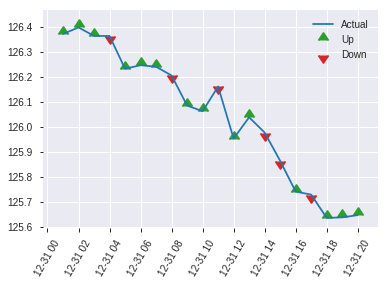


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20120037103831567
RMSE: 0.4485536434344455
LogLoss: 0.5873101478501312
Mean Per-Class Error: 0.2971319231254468
AUC: 0.7575013667521763
pr_auc: 0.7227858871228904
Gini: 0.5150027335043526
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37566469609737396: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      173  143  0.4525   (143.0/316.0)
1      48   253  0.1595   (48.0/301.0)
Total  221  396  0.3096   (191.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375665     0.725968  255
max f2                       0.18939      0.842923  343
max f0point5                 0.49038      0.691739  191
max accuracy                 0.457954     0.701783  214
max precision                0.947373     1         0
max recall                   0.100109     1         388
max specificity              0.947373     1         0
max absolute_mcc             0.457954     0.406901  214
max min_per_class_accuracy   0.486172     0.69103   195
max mean_per_class_accuracy  0.457954     0.702868  214

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 45.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.906412           1.46417   1.46417            0.714286         0.923542  0.714286                    0.923542            0.0166113       0.0166113                  46.4167   46.4167
    2        0.0210697                   0.880738           2.04983   1.73447            1                0.891137  0.846154                    0.908586            0.0199336       0.0365449                  104.983   73.4475
    3        0.0307942                   0.861332           2.04983   1.83406            1                0.872501  0.894737                    0.89719             0.0199336       0.0564784                  104.983   83.4062
    4        0.0405186                   0.838454           1.70819   1.80385            0.833333         0.849985  0.88                        0.885861            0.0166113       0.0730897                  70.8195   80.3854
    5        0.0502431                   0.825472           1.02492   1.65309            0.5              0.831499  0.806452                    0.875339            0.00996678      0.0830565                  2.49169   65.3092
    6        0.100486                    0.727044           1.78534   1.71922            0.870968         0.777983  0.83871                     0.826661            0.089701        0.172757                   78.5339   71.9216
    7        0.150729                    0.673049           1.45472   1.63105            0.709677         0.695706  0.795699                    0.783009            0.0730897       0.245847                   45.4721   63.1051
    8        0.200972                    0.636741           1.45472   1.58697            0.709677         0.654463  0.774194                    0.750873            0.0730897       0.318937                   45.4721   58.6968
    9        0.299838                    0.578372           1.37776   1.51799            0.672131         0.602611  0.740541                    0.701987            0.136213        0.45515                    37.7757   51.7985
    10       0.400324                    0.531069           1.32247   1.46891            0.645161         0.551515  0.716599                    0.664217            0.13289         0.58804                    32.2473   46.8909
    11       0.50081                     0.483576           1.09104   1.39309            0.532258         0.507155  0.679612                    0.632703            0.109635        0.697674                   9.10406   39.3091
    12       0.599676                    0.415432           1.00812   1.32962            0.491803         0.45123   0.648649                    0.602784            0.0996678       0.797342                   0.811503  32.9622
    13       0.700162                    0.322646           0.72736   1.24319            0.354839         0.368726  0.606481                    0.569192            0.0730897       0.870432                   -27.264   24.3186
    14       0.799028                    0.243828           0.638473  1.16836            0.311475         0.281323  0.56998                     0.533574            0.0631229       0.933555                   -36.1527  16.8364
    15       0.899514                    0.158949           0.462866  1.08955            0.225806         0.20289   0.531532                    0.496632            0.0465116       0.980066                   -53.7134  8.95513
    16       1                           0.0589939          0.198371  1                  0.0967742        0.12265   0.487844                    0.459052         

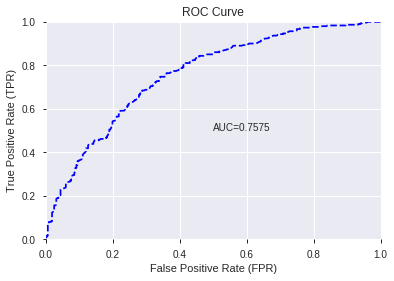

This function is available for GLM models only


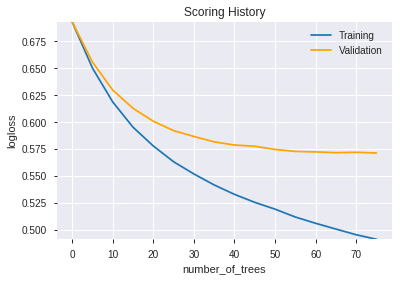

--2019-08-24 14:23:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_142229',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_142229',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_baad',
   'type

['BOP',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'TRANGE',
 'SUB',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DM_8',
 'dayofyear',
 'hour',
 'ADOSC',
 'OBV',
 'HT_DCPERIOD',
 'STOCH_slowd',
 'WILLR_8',
 'aroonup_14',
 'CORREL_8',
 'WILLR_14',
 'PLUS_DI_12',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'SAREXT',
 'aroonup_8',
 'PLUS_DM_12',
 'BETA_14',
 'CDLHAMMER',
 'PLUS_DM_14',
 'WILLR_12',
 'ULTOSC',
 'WILLR_20',
 'aroondown_24',
 'CDLHIKKAKE',
 'CMO_8',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'RSI_8',
 'CDLRICKSHAWMAN',
 'CDLBELTHOLD',
 'CDLDOJI',
 'HT_TRENDMODE',
 'month',
 'CDLHANGINGMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLENGULFING']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 892 924 935] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


91

['Volume',
 'BOP',
 'aroondown_8',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'aroondown_12',
 'CCI_12',
 'CMO_12',
 'MINUS_DI_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'aroondown_14',
 'CCI_14',
 'CMO_14',
 'MINUS_DI_14',
 'MINUS_DM_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MINUS_DI_20',
 'MOM_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'MINUS_DI_24',
 'MOM_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'MINUS_DI_30',
 'MOM_30',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'ATR_8',
 'NATR_8',
 'TRANGE',
 'CDLBELTHOLD',

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_142405_model_6  0.742446  0.607037              0.306473  0.455609  0.207579
1  DeepLearning_grid_1_AutoML_20190824_142405_model_9  0.738477  0.606364              0.310742  0.456736  0.208608
2  DeepLearning_grid_1_AutoML_20190824_142405_model_3  0.734808  0.638274              0.316839  0.459945  0.211549
3  DeepLearning_grid_1_AutoML_20190824_142405_model_8  0.733962  0.610011              0.336778  0.456747  0.208618
4  DeepLearning_grid_1_AutoML_20190824_142405_model_5  0.728326  0.619098              0.331238  0.459689  0.211314
5               DeepLearning_1_AutoML_20190824_142405  0.714375  0.622996              0.370563  0.465595  0.216779
6  DeepLearning_grid_1_AutoML_20190824_142405_model_7  0.707878  0.678879              0.352128  0.476230  0.226795
7  DeepLearning_grid_1_AutoML_20190824_142405_model_4  0.703657  0.649523              0.398729  0.474303  0.224963
8  DeepLearning_grid_1_AutoML_20190824_142405_model_2  0.695619  0.639108              0.388126  0.472450  0.223209
9  DeepLearning_grid_1_AutoML_20190824_142405_model_1  0.626093  1.108981              0.402761  0.563540  0.317577

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.032730
1   CDLCLOSINGMARUBOZU             0.649184           0.649184    0.021248
2          CDLLONGLINE             0.517614           0.517614    0.016941
3         CDLSHORTLINE             0.491645           0.491645    0.016092
4               TRANGE             0.485836           0.485836    0.015901
..                 ...                  ...                ...         ...
86              ROCR_8             0.283158           0.283158    0.009268
87         MINUS_DI_20             0.282706           0.282706    0.009253
88          ROCR100_12             0.282701           0.282701    0.009253
89              ROC_24             0.275761           0.275761    0.009026
90              CMO_20             0.273914           0.273914    0.008965

[91 rows x 4 columns]

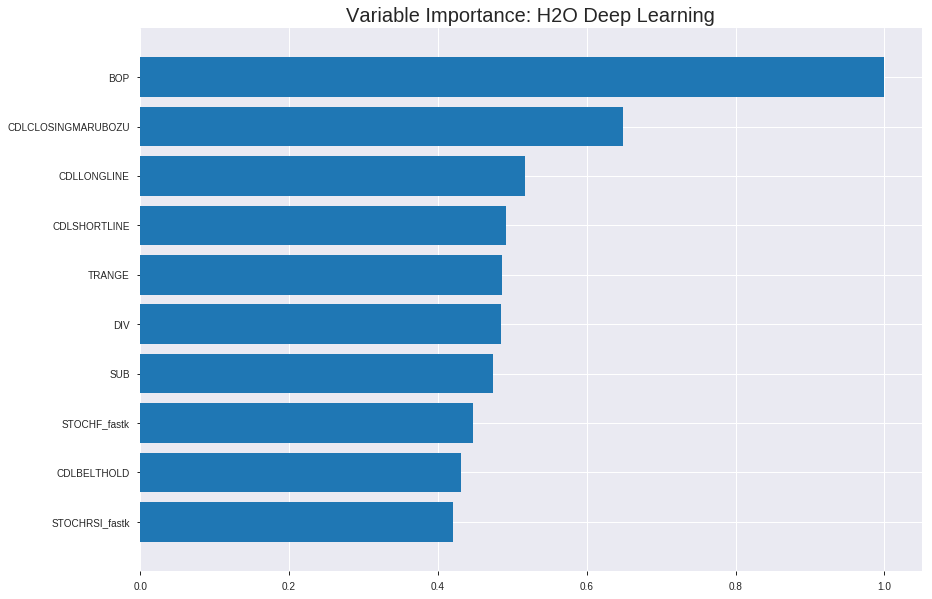

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_142405_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19489272697471227
RMSE: 0.4414665638241613
LogLoss: 0.5726875729637212
Mean Per-Class Error: 0.295595630399927
AUC: 0.7699668742797587
pr_auc: 0.7343652902414936
Gini: 0.5399337485595175
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.367024385655992: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1240  1014  0.4499   (1014.0/2254.0)
1      317   1745  0.1537   (317.0/2062.0)
Total  1557  2759  0.3084   (1331.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367024     0.723916  249
max f2                       0.0993579    0.836306  357
max f0point5                 0.456658     0.680868  213
max accuracy                 0.456658     0.701112  213
max precision                0.972779     1         0
max recall                   0.0130531    1         397
max specificity              0.972779     1         0
max absolute_mcc             0.403924     0.418011  235
max min_per_class_accuracy   0.505645     0.692103  190
max mean_per_class_accuracy  0.403924     0.704404  235

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 45.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.925551           1.85526   1.85526            0.886364         0.94505   0.886364                    0.94505             0.0189137       0.0189137                  85.526    85.526
    2        0.0201576                   0.900641           1.89841   1.87658            0.906977         0.913914  0.896552                    0.929661            0.0189137       0.0378274                  89.8405   87.6585
    3        0.0301205                   0.882061           1.94708   1.8999             0.930233         0.891865  0.907692                    0.917159            0.0193986       0.057226                   94.7082   89.9903
    4        0.0400834                   0.861232           1.94708   1.91163            0.930233         0.870946  0.913295                    0.905673            0.0193986       0.0766246                  94.7082   91.163
    5        0.0500463                   0.839522           1.75237   1.87993            0.837209         0.850057  0.898148                    0.894601            0.0174588       0.0940834                  75.2374   87.9926
    6        0.100093                    0.760128           1.64736   1.76364            0.787037         0.793063  0.842593                    0.843832            0.0824442       0.176528                   64.7358   76.3642
    7        0.150139                    0.715006           1.61829   1.71519            0.773148         0.736571  0.819444                    0.808078            0.0809893       0.257517                   61.8287   71.519
    8        0.200185                    0.674692           1.52138   1.66674            0.726852         0.693967  0.796296                    0.77955             0.0761397       0.333657                   52.1383   66.6739
    9        0.300046                    0.614394           1.35494   1.56297            0.647332         0.643916  0.746718                    0.734409            0.135306        0.468962                   35.4939   56.2966
    10       0.400139                    0.55733            1.18707   1.46894            0.56713          0.584505  0.701795                    0.696911            0.118817        0.587779                   18.7067   46.8937
    11       0.5                         0.498238           1.16068   1.40737            0.554524         0.531468  0.672382                    0.663868            0.115907        0.703686                   16.0682   40.7371
    12       0.600093                    0.411922           1.09016   1.35446            0.520833         0.453314  0.647104                    0.628749            0.109117        0.812803                   9.01633   35.4463
    13       0.699954                    0.295129           0.733318  1.26585            0.350348         0.353306  0.604767                    0.589452            0.0732299       0.886033                   -26.6682  26.5845
    14       0.800046                    0.180904           0.576575  1.17961            0.275463         0.237586  0.563568                    0.545431            0.057711        0.943744                   -42.3425  17.9612
    15       0.899907                    0.0833351          0.393369  1.09236            0.187935         0.128462  0.521885                    0.49916             0.0392823       0.983026                   -60.6631  9.23638
    16       1                           0.00614541         0.169581  1                  0.0810185        0.047366  0.477757                    0.453939            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19912593991618682
RMSE: 0.44623529658262895
LogLoss: 0.5815195284173407
Mean Per-Class Error: 0.3073542686113355
AUC: 0.7607408111232521
pr_auc: 0.7159272758098889
Gini: 0.5214816222465042
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30309737632557443: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      310  341  0.5238   (341.0/651.0)
1      70   512  0.1203   (70.0/582.0)
Total  380  853  0.3333   (411.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303097     0.713589  278
max f2                       0.129732     0.84101   342
max f0point5                 0.577452     0.669528  151
max accuracy                 0.413819     0.687753  229
max precision                0.973514     1         0
max recall                   0.0240529    1         392
max specificity              0.973514     1         0
max absolute_mcc             0.413819     0.389288  229
max min_per_class_accuracy   0.487177     0.680492  195
max mean_per_class_accuracy  0.413819     0.692646  229

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 45.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.939502           1.46669   1.46669            0.692308         0.951828   0.692308                    0.951828            0.0154639       0.0154639                  46.6693    46.6693
    2        0.0202758                   0.920215           2.11856   1.77959            1                0.928204   0.84                        0.940489            0.0206186       0.0360825                  111.856    77.9588
    3        0.0300081                   0.898728           1.76546   1.77501            0.833333         0.909841   0.837838                    0.930549            0.0171821       0.0532646                  76.5464    77.5007
    4        0.0405515                   0.878557           1.95559   1.82196            0.923077         0.890038   0.86                        0.920016            0.0206186       0.0738832                  95.5591    82.1959
    5        0.0502839                   0.854466           1.94201   1.84519            0.916667         0.867022   0.870968                    0.909759            0.0189003       0.0927835                  94.201     84.5195
    6        0.100568                    0.768449           1.70851   1.77685            0.806452         0.810719   0.83871                     0.860239            0.0859107       0.178694                   70.8513    77.6854
    7        0.150041                    0.724273           1.70179   1.7521             0.803279         0.745996   0.827027                    0.822569            0.0841924       0.262887                   70.1791    75.2104
    8        0.200324                    0.68098            1.29847   1.63824            0.612903         0.699638   0.773279                    0.791712            0.0652921       0.328179                   29.847     63.8236
    9        0.300081                    0.611421           1.39515   1.55743            0.658537         0.643442   0.735135                    0.742423            0.139175        0.467354                   39.5147    55.7425
    10       0.399838                    0.554463           1.17123   1.46107            0.552846         0.581384   0.689655                    0.702244            0.116838        0.584192                   17.1235    46.1074
    11       0.500406                    0.477792           1.07636   1.38376            0.508065         0.521488   0.65316                     0.665917            0.108247        0.69244                    7.63635    38.3757
    12       0.600162                    0.394349           0.998994  1.3198             0.471545         0.436445   0.622973                    0.627775            0.0996564       0.792096                   -0.100578  31.9804
    13       0.699919                    0.292587           0.930098  1.26426            0.439024         0.345555   0.596756                    0.587552            0.0927835       0.88488                    -6.99019   26.426
    14       0.799676                    0.173915           0.602841  1.18175            0.284553         0.235109   0.557809                    0.543586            0.0601375       0.945017                   -39.7159   18.1751
    15       0.899432                    0.0784677          0.396153  1.09462            0.186992         0.121072   0.516682                    0.496724            0.0395189       0.984536                   -60.3847   9.46195
    16       1                           0.00600494         0.153766  1                  0.0725806        0.0447542  0.472019   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:31:58  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 14:32:01  5 min 17.529 sec  722 obs/sec       0.47405   1             2046       0.49442          0.791578            0.0202574      0.728224        0.67657            1.90283          0.35241                          0.485868           0.745782              0.0527629        0.744544          0.701511             2.11856            0.389294
    2019-08-24 14:32:23  5 min 39.992 sec  1685 obs/sec      9.03406   19            38991      0.441467         0.572688            0.218883       0.769967        0.734365           1.85526          0.308387                         0.446235           0.58152               0.200994         0.760741          0.715927             1.46669            0.333333
    2019-08-24 14:32:46  6 min  2.249 sec  1900 obs/sec      19.0137   40            82063      0.438483         0.567094            0.229404       0.778369        0.740823           1.76012          0.310936                         0.447492           0.592774              0.196487         0.757852          0.702909             1.46669            0.349554
    2019-08-24 14:33:08  6 min 24.571 sec  2005 obs/sec      29.408    62            126925     0.436222         0.564044            0.237332       0.783833        0.748696           1.80769          0.307924                         0.448889           0.603389              0.191463         0.756386          0.715408             1.62966            0.334955
    2019-08-24 14:33:31  6 min 47.214 sec  2078 obs/sec      40.326    85            174047     0.433233         0.555809            0.247749       0.790004        0.759307           1.85526          0.3019                           0.451609           0.602104              0.181635         0.750468          0.702305             1.46669            0.326845
    2019-08-24 14:33:53  7 min  9.436 sec  2128 obs/sec      51.1969   108           220966     0.429018         0.546255            0.262315       0.798001        0.768794           1.85526          0.295876                         0.451528           0.605323              0.181928         0.750471          0.698947             1.46669            0.328467
    2019-08-24 14:34:15  7 min 31.716 sec  2177 obs/sec      62.51     132           269793     0.431292         0.552309            0.254475       0.798553        0.767614           1.80769          0.288925                         0.456984           0.622626              0.162037         0.742954          0.706199             1.79262            0.339822
    2019-08-24 14:34:17  7 min 33.923 sec  2177 obs/sec      62.51     132           269793     0.441467         0.572688            0.218883       0.769967        0.734365           1.85526          0.308387                         0.446235           0.58152               0.200994         0.760741          0.715927             1.46669            0.333333

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.032729917270965976
CDLCLOSINGMARUBOZU  0.6491838693618774     0.6491838693618774   0.021247734337859835
CDLLONGLINE         0.5176140666007996     0.5176140666007996   0.016941465578132444
CDLSHORTLINE        0.49164506793022156    0.49164506793022156  0.0160915024000346
TRANGE              0.4858361780643463     0.4858361780643463   0.01590137791528835
---                 ---                    ---                  ---
ROCR_8              0.2831580936908722     0.2831580936908722   0.00926774098110668
MINUS_DI_20         0.2827059030532837     0.2827059030532837   0.009252940818947704
ROCR100_12          0.28270119428634644    0.28270119428634644  0.009252786701395399
ROC_24              0.27576085925102234    0.27576085925102234  0.009025630109856454
CMO_20              0.27391374111175537    0.27391374111175537  0.008965174085968546


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6952998379254457)

('F1', 0.7211678832116788)

('auc', 0.7424460658564279)

('logloss', 0.6070371095979885)

('mean_per_class_error', 0.3029879305269355)

('rmse', 0.45560892834690403)

('mse', 0.20757949558941433)

deeplearning prediction progress: |███████████████████████████████████████| 100%


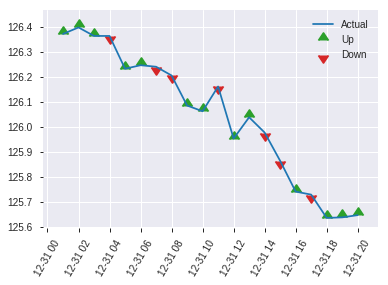


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20757949558941433
RMSE: 0.45560892834690403
LogLoss: 0.6070371095979885
Mean Per-Class Error: 0.3029879305269355
AUC: 0.7424460658564279
pr_auc: 0.7084870436320778
Gini: 0.48489213171285583
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38097712630136854: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      179  137  0.4335   (137.0/316.0)
1      54   247  0.1794   (54.0/301.0)
Total  233  384  0.3096   (191.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380977     0.721168  245
max f2                       0.0630543    0.834734  377
max f0point5                 0.464826     0.68253   208
max accuracy                 0.433863     0.6953    221
max precision                0.94738      1         0
max recall                   0.0357797    1         393
max specificity              0.94738      1         0
max absolute_mcc             0.380977     0.399075  245
max min_per_class_accuracy   0.487852     0.686709  197
max mean_per_class_accuracy  0.433863     0.697012  221

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 45.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.921453           1.757     1.757              0.857143         0.931281   0.857143                    0.931281            0.0199336       0.0199336                  75.7      75.7
    2        0.0210697                   0.903097           1.70819   1.73447            0.833333         0.912611   0.846154                    0.922664            0.0166113       0.0365449                  70.8195   73.4475
    3        0.0307942                   0.886477           1.70819   1.72618            0.833333         0.896245   0.842105                    0.914321            0.0166113       0.0531561                  70.8195   72.6176
    4        0.0405186                   0.864753           2.04983   1.80385            1                0.874542   0.88                        0.904774            0.0199336       0.0730897                  104.983   80.3854
    5        0.0502431                   0.848325           2.04983   1.85146            1                0.854822   0.903226                    0.895106            0.0199336       0.0930233                  104.983   85.1463
    6        0.100486                    0.77096            1.52084   1.68615            0.741935         0.802318   0.822581                    0.848712            0.076412        0.169435                   52.0844   68.6154
    7        0.150729                    0.723396           1.3886    1.58697            0.677419         0.744866   0.774194                    0.814097            0.0697674       0.239203                   38.8597   58.6968
    8        0.200972                    0.665858           1.32247   1.52084            0.645161         0.690287   0.741935                    0.783144            0.0664452       0.305648                   32.2473   52.0844
    9        0.299838                    0.592056           1.27695   1.44042            0.622951         0.624284   0.702703                    0.730763            0.126246        0.431894                   27.6946   44.0424
    10       0.400324                    0.54006            1.42166   1.43571            0.693548         0.567263   0.700405                    0.689723            0.142857        0.574751                   42.1659   43.5714
    11       0.50081                     0.48695            1.19023   1.38646            0.580645         0.512215   0.676375                    0.654106            0.119601        0.694352                   19.0226   38.6457
    12       0.599676                    0.39685            0.940907  1.313              0.459016         0.443475   0.640541                    0.619381            0.0930233       0.787375                   -5.90926  31.3002
    13       0.700162                    0.304198           0.72736   1.22895            0.354839         0.353505   0.599537                    0.581223            0.0730897       0.860465                   -27.264   22.8951
    14       0.799028                    0.174402           0.604869  1.15173            0.295082         0.246767   0.561866                    0.53984             0.0598007       0.920266                   -39.5131  15.1732
    15       0.899514                    0.100692           0.462866  1.07478            0.225806         0.140271   0.524324                    0.495203            0.0465116       0.966777                   -53.7134  7.47778
    16       1                           0.0120105          0.330618  1                  0.16129          0.0574209  0.487844                    0.

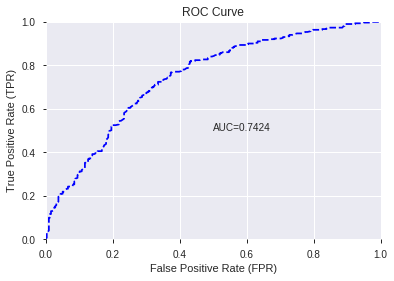

This function is available for GLM models only


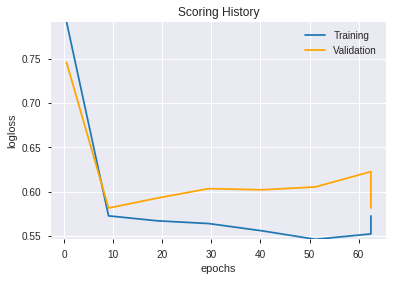

--2019-08-24 14:50:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.12
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.12|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_142405_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_142405_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'TRANGE',
 'DIV',
 'SUB',
 'STOCHF_fastk',
 'CDLBELTHOLD',
 'STOCHRSI_fastk',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLENGULFING',
 'WILLR_8',
 'CDLTAKURI',
 'CCI_8',
 'CDLMARUBOZU',
 'WILLR_30',
 'ADOSC',
 'ATR_8',
 'CDLHIKKAKE',
 'CCI_20',
 'CCI_12',
 'aroondown_14',
 'WILLR_14',
 'ROCR100_20',
 'NATR_8',
 'CCI_24',
 'MINUS_DM_14',
 'WILLR_12',
 'ROCR_20',
 'CCI_14',
 'STOCH_slowk',
 'STOCHRSI_fastd',
 'WILLR_24',
 'ULTOSC',
 'aroondown_8',
 'STOCHF_fastd',
 'ROC_20',
 'Volume',
 'ROC_14',
 'ROCP_20',
 'ROCR_14',
 'ROCR100_24',
 'RSI_24',
 'aroondown_12',
 'MINUS_DI_8',
 'ROCP_24',
 'ROCR100_30',
 'CMO_12',
 'MINUS_DI_24',
 'ROCP_14',
 'MINUS_DI_30',
 'ROCR_30',
 'ROC_30',
 'MINUS_DM_8',
 'MOM_20',
 'MOM_30',
 'RSI_12',
 'WILLR_20',
 'ROC_12',
 'RSI_8',
 'MINUS_DI_12',
 'ROCP_12',
 'MINUS_DM_12',
 'CMO_8',
 'CMO_24',
 'MOM_12',
 'ROCR_12',
 'CCI_30',
 'ROCR100_14',
 'CMO_14',
 'RSI_20',
 'ROC_8',
 'RSI_

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_145156_model_1  0.73996  0.59991               0.33037  0.454519  0.206587

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.708202           1.000000    0.148915
1   CDLCLOSINGMARUBOZU             0.204263           0.288425    0.042951
2         STOCHF_fastk             0.182853           0.258194    0.038449
3                CCI_8             0.174804           0.246827    0.036756
4               TRANGE             0.151183           0.213475    0.031790
..                 ...                  ...                ...         ...
86              ROC_24             0.002252           0.003180    0.000474
87          ROCR100_24             0.002203           0.003110    0.000463
88            WILLR_20             0.000683           0.000965    0.000144
89              MOM_20             0.000497           0.000702    0.000105
90         CDLLONGLINE             0.000055           0.000078    0.000012

[91 rows x 4 columns]

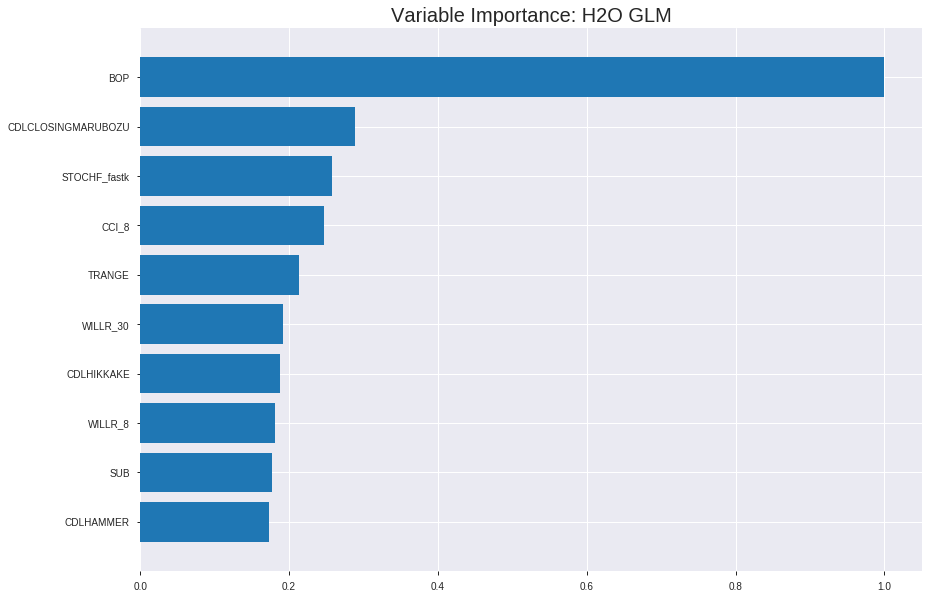

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_145156_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19287398206834944
RMSE: 0.43917420469370627
LogLoss: 0.5677109625927504
Null degrees of freedom: 4315
Residual degrees of freedom: 4224
Null deviance: 5974.702401324418
Residual deviance: 4900.4810291006215
AIC: 5084.4810291006215
AUC: 0.7750215803438569
pr_auc: 0.742098729527024
Gini: 0.5500431606877139
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38238068069175196: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1239  1015  0.4503   (1015.0/2254.0)
1      308   1754  0.1494   (308.0/2062.0)
Total  1547  2769  0.3065   (1323.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382381     0.726144  249
max f2                       0.232533     0.836578  318
max f0point5                 0.505677     0.691275  189
max accuracy                 0.50196      0.706209  191
max precision                0.952109     1         0
max recall                   0.0310999    1         397
max specificity              0.952109     1         0
max absolute_mcc             0.435906     0.420685  223
max min_per_class_accuracy   0.50196      0.705626  191
max mean_per_class_accuracy  0.441469     0.708484  220

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 47.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101946                   0.901569           1.85526   1.85526            0.886364         0.918135  0.886364                    0.918135            0.0189137       0.0189137                  85.526     85.526
    2        0.0201576                   0.881943           1.89841   1.87658            0.906977         0.891415  0.896552                    0.904929            0.0189137       0.0378274                  89.8405    87.6585
    3        0.0301205                   0.862394           1.80105   1.8516             0.860465         0.872713  0.884615                    0.894273            0.0179437       0.0557711                  80.1051    85.16
    4        0.0400834                   0.850958           1.99576   1.88743            0.953488         0.856376  0.901734                    0.884853            0.0198836       0.0756547                  99.5759    88.7432
    5        0.0500463                   0.83175            1.89841   1.88962            0.906977         0.841091  0.902778                    0.876141            0.0189137       0.0945684                  89.8405    88.9616
    6        0.100093                    0.764297           1.72488   1.80725            0.824074         0.793209  0.863426                    0.834675            0.086324        0.180892                   72.4881    80.7248
    7        0.150139                    0.723983           1.58922   1.73457            0.759259         0.743206  0.828704                    0.804185            0.0795344       0.260427                   58.9216    73.4571
    8        0.200185                    0.689987           1.48262   1.67158            0.708333         0.707435  0.798611                    0.779998            0.0741998       0.334627                   48.2622    67.1584
    9        0.300046                    0.626532           1.34523   1.56297            0.642691         0.657171  0.746718                    0.739119            0.134336        0.468962                   34.5226    56.2966
    10       0.400139                    0.562903           1.27428   1.49075            0.608796         0.595611  0.712218                    0.703221            0.127546        0.596508                   27.428     49.0753
    11       0.5                         0.49372            1.1704    1.42677            0.559165         0.527308  0.68165                     0.668087            0.116877        0.713385                   17.0395    42.677
    12       0.600093                    0.413806           0.998105  1.35527            0.476852         0.454727  0.64749                     0.6325              0.099903        0.813288                   -0.189496  35.5271
    13       0.699954                    0.335948           0.791595  1.27485            0.37819          0.375077  0.60907                     0.595774            0.0790495       0.892338                   -20.8405   27.4852
    14       0.800046                    0.254539           0.552349  1.18446            0.263889         0.29687   0.565885                    0.558378            0.0552861       0.947624                   -44.7651   18.4461
    15       0.899907                    0.159181           0.296241  1.0859             0.141531         0.209223  0.518795                    0.519633            0.0295829       0.977207                   -70.3759   8.58969
    16       1                           0.00830194         0.227723  1                  0.108796         0.101259  0.477757                    0.47



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19606936806880224
RMSE: 0.4427972087409791
LogLoss: 0.5743880322457918
Null degrees of freedom: 1232
Residual degrees of freedom: 1141
Null deviance: 1705.6003649118566
Residual deviance: 1416.4408875181225
AIC: 1600.4408875181225
AUC: 0.7664589502800344
pr_auc: 0.7272838028602224
Gini: 0.5329179005600688
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33633503900962236: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      294  357  0.5484   (357.0/651.0)
1      58   524  0.0997   (58.0/582.0)
Total  352  881  0.3366   (415.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336335     0.716336  272
max f2                       0.241291     0.840311  317
max f0point5                 0.572701     0.683903  154
max accuracy                 0.572701     0.691809  154
max precision                0.955254     1         0
max recall                   0.0465402    1         394
max specificity              0.955254     1         0
max absolute_mcc             0.351244     0.391582  263
max min_per_class_accuracy   0.491184     0.689003  193
max mean_per_class_accuracy  0.486347     0.691165  195

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 47.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.905043           1.79262   1.79262            0.846154         0.92338   0.846154                    0.92338             0.0189003       0.0189003                  79.2625   79.2625
    2        0.0202758                   0.892725           1.94201   1.86433            0.916667         0.89885   0.88                        0.911605            0.0189003       0.0378007                  94.201    86.433
    3        0.0300081                   0.873114           1.76546   1.83227            0.833333         0.880472  0.864865                    0.901508            0.0171821       0.0549828                  76.5464   83.2265
    4        0.0405515                   0.862841           1.62966   1.77959            0.769231         0.867836  0.84                        0.892753            0.0171821       0.0721649                  62.9659   77.9588
    5        0.0502839                   0.834466           1.94201   1.81102            0.916667         0.845174  0.854839                    0.883545            0.0189003       0.0910653                  94.201    81.1024
    6        0.100568                    0.763203           1.77685   1.79394            0.83871          0.799665  0.846774                    0.841605            0.0893471       0.180412                   77.6854   79.3939
    7        0.150041                    0.717245           1.56287   1.71775            0.737705         0.737545  0.810811                    0.807293            0.0773196       0.257732                   56.287    71.7749
    8        0.200324                    0.684142           1.64017   1.69828            0.774194         0.700101  0.801619                    0.780387            0.0824742       0.340206                   64.0173   69.8276
    9        0.300081                    0.616923           1.2918    1.56315            0.609756         0.650044  0.737838                    0.737057            0.128866        0.469072                   29.1803   56.3151
    10       0.399838                    0.550692           1.25735   1.48686            0.593496         0.583056  0.701826                    0.698635            0.12543         0.594502                   25.7355   48.6857
    11       0.500406                    0.481947           1.04219   1.39749            0.491935         0.519259  0.659643                    0.662585            0.104811        0.699313                   4.21932   39.7492
    12       0.600162                    0.407361           0.912874  1.31694            0.430894         0.443308  0.621622                    0.626138            0.0910653       0.790378                   -8.7126   31.6941
    13       0.699919                    0.342088           0.98177   1.26917            0.463415         0.374107  0.599073                    0.590217            0.0979381       0.888316                   -1.82298  26.917
    14       0.799676                    0.264786           0.654513  1.19249            0.308943         0.306417  0.56288                     0.554814            0.0652921       0.953608                   -34.5487  19.2494
    15       0.899432                    0.16431            0.310033  1.09462            0.146341         0.21742   0.516682                    0.517393            0.0309278       0.984536                   -68.9967  9.46195
    16       1                           0.029823           0.153766  1                  0.0725806        0.102706  0.472019                    0.475689           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 14:51:57  0.000 sec   2            .21E2     92            1.3605217173549018  1.3637331263704853
     2019-08-24 14:51:57  0.062 sec   4            .13E2     92            1.3509886326997085  1.3552796875888216
     2019-08-24 14:51:57  0.129 sec   6            .8E1      92            1.338608884684292   1.3438150237878776
     2019-08-24 14:51:57  0.193 sec   8            .49E1     92            1.3227291218958712  1.328566756303081
     2019-08-24 14:51:57  0.256 sec   10           .31E1     92            1.3030454395730844  1.3091305204141566
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 14:51:58  1.031 sec   34           .1E-1     92            1.1327747615337496  1.1488343227839204
     2019-08-24 14:51:58  1.100 sec   36           .63E-2    92            1.130882845901051   1.1494664640372232
     2019-08-24 14:51:58  1.171 sec   38           .39E-2    92            1.1295027321910807  1.150347325372
     2019-08-24 14:51:58  1.236 sec   40           .24E-2    92            1.1285391018501028  1.1512812677081115
     2019-08-24 14:51:58  1.311 sec   42           .15E-2    92            1.1278093269802885  1.1521868538993802


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6888168557536467)

('F1', 0.7191316146540027)

('auc', 0.7399596282434081)

('logloss', 0.5999103933362767)

('mean_per_class_error', 0.3108152151057656)

('rmse', 0.4545188626842352)

('mse', 0.20658739653577063)

glm prediction progress: |████████████████████████████████████████████████| 100%


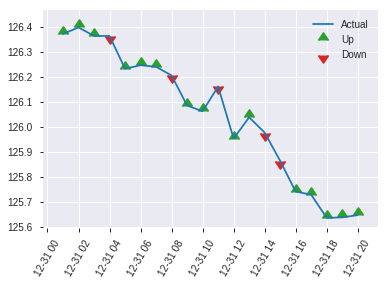


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20658739653577063
RMSE: 0.4545188626842352
LogLoss: 0.5999103933362767
Null degrees of freedom: 616
Residual degrees of freedom: 525
Null deviance: 855.2304056881629
Residual deviance: 740.2894253769655
AIC: 924.2894253769655
AUC: 0.7399596282434081
pr_auc: 0.7208809403364005
Gini: 0.4799192564868162
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33484846108298294: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      145  171  0.5411   (171.0/316.0)
1      36   265  0.1196   (36.0/301.0)
Total  181  436  0.3355   (207.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.334848     0.719132  276
max f2                       0.237514     0.834309  322
max f0point5                 0.466797     0.679052  204
max accuracy                 0.466797     0.688817  204
max precision                0.945322     1         0
max recall                   0.0750112    1         388
max specificity              0.945322     1         0
max absolute_mcc             0.431523     0.378967  221
max min_per_class_accuracy   0.482938     0.681063  195
max mean_per_class_accuracy  0.466797     0.689185  204

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 46.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.894542           2.04983   2.04983            1                0.914977   1                           0.914977            0.0232558       0.0232558                  104.983   104.983
    2        0.0210697                   0.880825           2.04983   2.04983            1                0.885986   1                           0.901597            0.0199336       0.0431894                  104.983   104.983
    3        0.0307942                   0.861161           1.70819   1.94195            0.833333         0.869662   0.947368                    0.891512            0.0166113       0.0598007                  70.8195   94.1948
    4        0.0405186                   0.850609           1.70819   1.88585            0.833333         0.856248   0.92                        0.883049            0.0166113       0.076412                   70.8195   88.5847
    5        0.0502431                   0.835342           1.70819   1.85146            0.833333         0.843954   0.903226                    0.875482            0.0166113       0.0930233                  70.8195   85.1463
    6        0.100486                    0.756802           1.58697   1.71922            0.774194         0.796124   0.83871                     0.835803            0.0797342       0.172757                   58.6968   71.9216
    7        0.150729                    0.710816           1.32247   1.58697            0.645161         0.73234    0.774194                    0.801315            0.0664452       0.239203                   32.2473   58.6968
    8        0.200972                    0.676687           1.45472   1.55391            0.709677         0.694231   0.758065                    0.774544            0.0730897       0.312292                   45.4721   55.3906
    9        0.299838                    0.61549            1.34415   1.48474            0.655738         0.647526   0.724324                    0.732663            0.13289         0.445183                   34.4153   48.4745
    10       0.400324                    0.538769           1.05798   1.37762            0.516129         0.577688   0.672065                    0.693762            0.106312        0.551495                   5.79788   37.7621
    11       0.50081                     0.474674           1.35554   1.37319            0.66129          0.508711   0.669903                    0.656632            0.136213        0.687708                   35.5535   37.319
    12       0.599676                    0.401928           0.907304  1.29638            0.442623         0.434653   0.632432                    0.620036            0.089701        0.777409                   -9.26965  29.6381
    13       0.700162                    0.338738           0.958793  1.24793            0.467742         0.368037   0.608796                    0.583869            0.0963455       0.873754                   -4.12067  24.7931
    14       0.799028                    0.247444           0.604869  1.16836            0.295082         0.28763    0.56998                     0.547215            0.0598007       0.933555                   -39.5131  16.8364
    15       0.899514                    0.150906           0.231433  1.0637             0.112903         0.200864   0.518919                    0.508523            0.0232558       0.956811                   -76.8567  6.36976
    16       1                           0.026896           0.429804  1                  0.209677         0.0982546  0.487844                    

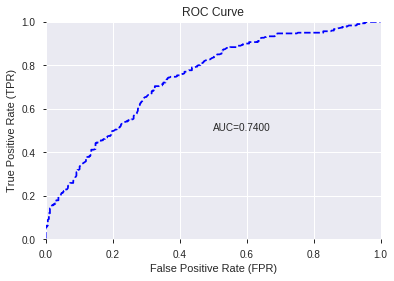

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


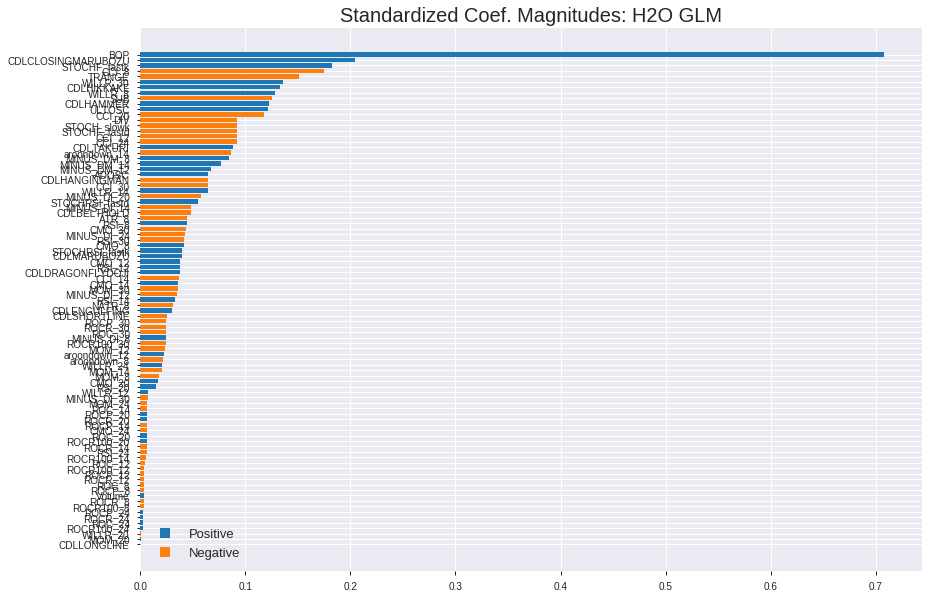

'log_likelihood'
--2019-08-24 14:52:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_145156_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_145156_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CCI_8',
 'TRANGE',
 'WILLR_30',
 'CDLHIKKAKE',
 'WILLR_8',
 'SUB',
 'CDLHAMMER',
 'ULTOSC',
 'CCI_20',
 'DIV',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CCI_12',
 'CCI_24',
 'CDLTAKURI',
 'aroondown_14',
 'MINUS_DM_8',
 'MINUS_DM_14',
 'MINUS_DM_12',
 'ADOSC',
 'CDLHANGINGMAN',
 'CCI_30',
 'WILLR_14',
 'MINUS_DI_20',
 'STOCHRSI_fastd',
 'MINUS_DI_14',
 'CDLBELTHOLD',
 'ATR_8',
 'RSI_8',
 'CMO_30',
 'MINUS_DI_24',
 'RSI_30',
 'CMO_8',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'CMO_12',
 'RSI_12',
 'CDLDRAGONFLYDOJI',
 'CCI_14',
 'CMO_14',
 'MOM_30',
 'MINUS_DI_12',
 'RSI_14',
 'NATR_8',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'ROCP_30',
 'ROCR_30',
 'ROC_30',
 'MINUS_DI_8',
 'ROCR100_30',
 'MOM_12',
 'aroondown_12',
 'aroondown_8',
 'WILLR_24',
 'MOM_14',
 'MOM_8',
 'CMO_20',
 'RSI_20',
 'WILLR_12',
 'MINUS_DI_30',
 'MOM_24',
 'ROC_14',
 'ROCP_20',
 'ROCR_20',
 'ROCP_14',
 'CMO_24',
 'ROC_20',
 'ROCR100_20',
 'ROCR_14',
 'RSI_24',
 'ROCR100_14',
 'ROC_12'

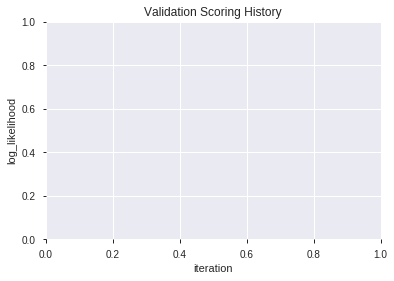

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_145306_model_3  0.754642  0.592571              0.330449  0.450019  0.202517
1  XGBoost_grid_1_AutoML_20190824_145306_model_1  0.746341  0.595003              0.312166  0.452201  0.204486
2  XGBoost_grid_1_AutoML_20190824_145306_model_2  0.745074  0.596491              0.331558  0.452754  0.204986
3               XGBoost_3_AutoML_20190824_145306  0.741573  0.599102              0.355056  0.454280  0.206371
4  XGBoost_grid_1_AutoML_20190824_145306_model_4  0.740480  0.598844              0.321665  0.454315  0.206402
5  XGBoost_grid_1_AutoML_20190824_145306_model_6  0.738488  0.601783              0.317786  0.455174  0.207183
6               XGBoost_1_AutoML_20190824_145306  0.735849  0.605820              0.348648  0.457356  0.209175
7  XGBoost_grid_1_AutoML_20190824_145306_model_7  0.733767  0.608103              0.329577  0.458097  0.209853
8               XGBoost_2_AutoML_20190824_145306  0.728568  0.610155              0.342792  0.459868  0.211478
9  XGBoost_grid_1_AutoML_20190824_145306_model_5  0.715600  0.635951              0.378159  0.469988  0.220889

variable  relative_importance  scaled_importance  percentage
0              BOP          4123.674805           1.000000    0.276882
1     STOCHF_fastk           862.943298           0.209266    0.057942
2           TRANGE           631.664124           0.153180    0.042413
3            CCI_8           505.033203           0.122472    0.033910
4   STOCHRSI_fastk           425.833771           0.103266    0.028592
..             ...                  ...                ...         ...
81         ROCR_20             9.846581           0.002388    0.000661
82      ROCR100_30             9.062624           0.002198    0.000609
83         ROCR_14             7.031178           0.001705    0.000472
84      ROCR100_24             5.335456           0.001294    0.000358
85     CDLLONGLINE             0.758247           0.000184    0.000051

[86 rows x 4 columns]

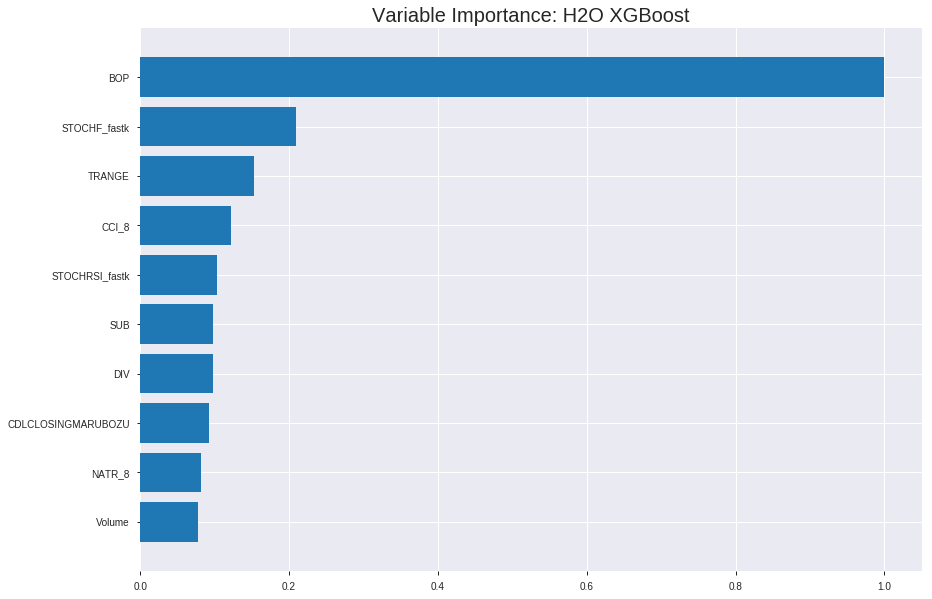

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_145306_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15793558437605432
RMSE: 0.3974111024821203
LogLoss: 0.4848185080968183
Mean Per-Class Error: 0.22359753583886222
AUC: 0.8668828430457074
pr_auc: 0.8582499165518916
Gini: 0.7337656860914148
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.423322098950545: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1452  802   0.3558   (802.0/2254.0)
1      243   1819  0.1178   (243.0/2062.0)
Total  1695  2621  0.2421   (1045.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423322     0.776852  235
max f2                       0.287417     0.865452  294
max f0point5                 0.588847     0.789725  152
max accuracy                 0.537039     0.777804  179
max precision                0.961471     1         0
max recall                   0.100107     1         375
max specificity              0.961471     1         0
max absolute_mcc             0.55562      0.555456  169
max min_per_class_accuracy   0.514773     0.772066  191
max mean_per_class_accuracy  0.533918     0.776402  181

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 47.73 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.918723           2.09311    2.09311            1                0.93369    1                           0.93369             0.0213385       0.0213385                  109.311   109.311
    2        0.0201576                   0.895143           2.09311    2.09311            1                0.905842   1                           0.919926            0.0208535       0.042192                   109.311   109.311
    3        0.0301205                   0.875368           2.09311    2.09311            1                0.885981   1                           0.908698            0.0208535       0.0630456                  109.311   109.311
    4        0.0400834                   0.857039           2.09311    2.09311            1                0.86559    1                           0.897983            0.0208535       0.0838991                  109.311   109.311
    5        0.0500463                   0.839573           2.04444    2.08342            0.976744         0.847765   0.99537                     0.887986            0.0203686       0.104268                   104.444   108.342
    6        0.100093                    0.765824           2.0059     2.04466            0.958333         0.799283   0.976852                    0.843635            0.100388        0.204656                   100.59    104.466
    7        0.150139                    0.720787           1.87993    1.98975            0.898148         0.741679   0.950617                    0.809649            0.0940834       0.298739                   87.9926   98.975
    8        0.200185                    0.684704           1.68612    1.91384            0.805556         0.701173   0.914352                    0.78253             0.0843841       0.383123                   68.6119   91.3842
    9        0.300046                    0.623593           1.66089    1.82966            0.793503         0.654255   0.874131                    0.739838            0.165858        0.548982                   66.0893   82.9656
    10       0.400139                    0.567579           1.33727    1.70649            0.638889         0.595822   0.815287                    0.703813            0.133851        0.682832                   33.7267   70.6487
    11       0.5                         0.503199           1.02956    1.57129            0.491879         0.536848   0.750695                    0.670466            0.102813        0.785645                   2.95593   57.129
    12       0.600093                    0.429517           0.901202   1.45952            0.430556         0.468703   0.697297                    0.636813            0.0902037       0.875849                   -9.87984  45.9522
    13       0.699954                    0.330902           0.650759   1.34414            0.310905         0.379666   0.642171                    0.600126            0.0649855       0.940834                   -34.9241  34.4138
    14       0.800046                    0.236049           0.377923   1.22326            0.180556         0.283473   0.584419                    0.56051             0.0378274       0.978661                   -62.2077  22.3256
    15       0.899907                    0.144375           0.1894     1.10853            0.0904872        0.189623   0.529609                    0.519354            0.0189137       0.997575                   -81.06    10.8531
    16       1                           0.0350127          0.0242259  1                  0.0115741        0.0993464  0.477757   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19236762283916928
RMSE: 0.4385973356498752
LogLoss: 0.5655454512717283
Mean Per-Class Error: 0.29795160498519335
AUC: 0.7778899499052475
pr_auc: 0.740656040605519
Gini: 0.555779899810495
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30567707121372223: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      283  368  0.5653   (368.0/651.0)
1      55   527  0.0945   (55.0/582.0)
Total  338  895  0.3431   (423.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305677     0.713609  288
max f2                       0.202083     0.838039  334
max f0point5                 0.600426     0.69583   140
max accuracy                 0.541754     0.704785  172
max precision                0.874634     0.9375    19
max recall                   0.0850183    1         385
max specificity              0.958338     0.998464  0
max absolute_mcc             0.541754     0.406376  172
max min_per_class_accuracy   0.502452     0.69278   194
max mean_per_class_accuracy  0.51653      0.702048  187

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 47.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.913201           1.79262   1.79262            0.846154         0.935445  0.846154                    0.935445            0.0189003       0.0189003                  79.2625    79.2625
    2        0.0202758                   0.886901           2.11856   1.94907            1                0.899565  0.92                        0.918223            0.0206186       0.0395189                  111.856    94.9072
    3        0.0300081                   0.866682           1.58892   1.83227            0.75             0.876202  0.864865                    0.904594            0.0154639       0.0549828                  58.8918    83.2265
    4        0.0405515                   0.849519           1.46669   1.73722            0.692308         0.858723  0.82                        0.892668            0.0154639       0.0704467                  46.6693    73.7216
    5        0.0502839                   0.832979           1.94201   1.77685            0.916667         0.841346  0.83871                     0.882735            0.0189003       0.0893471                  94.201     77.6854
    6        0.100568                    0.759179           1.81102   1.79394            0.854839         0.789801  0.846774                    0.836268            0.0910653       0.180412                   81.1024    79.3939
    7        0.150041                    0.709751           1.77125   1.78646            0.836066         0.731889  0.843243                    0.801851            0.0876289       0.268041                   77.1252    78.6459
    8        0.200324                    0.6673             1.77685   1.78405            0.83871          0.689492  0.842105                    0.773648            0.0893471       0.357388                   77.6854    78.4048
    9        0.300081                    0.614593           1.30903   1.62614            0.617886         0.64082   0.767568                    0.729491            0.130584        0.487973                   30.9027    62.6135
    10       0.399838                    0.55575            1.15401   1.50834            0.544715         0.584921  0.711968                    0.693422            0.11512         0.603093                   15.4011    50.8344
    11       0.500406                    0.495473           0.990938  1.40436            0.467742         0.526507  0.662885                    0.659877            0.0996564       0.702749                   -0.906219  40.4359
    12       0.600162                    0.422445           0.998994  1.33698            0.471545         0.461009  0.631081                    0.626822            0.0996564       0.802405                   -0.100578  33.6981
    13       0.699919                    0.338463           0.80953   1.26181            0.382114         0.38219   0.595597                    0.591955            0.080756        0.883162                   -19.047    26.1805
    14       0.799676                    0.234946           0.637289  1.1839             0.300813         0.281143  0.558824                    0.553183            0.0635739       0.946735                   -36.2711   18.3899
    15       0.899432                    0.144178           0.396153  1.09653            0.186992         0.193542  0.517583                    0.513295            0.0395189       0.986254                   -60.3847   9.65298
    16       1                           0.043017           0.136681  1                  0.0645161        0.102099  0.472019                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:53:19  3.918 sec   0                  0.5              0.693147            0.5             0                  1                0.522243                         0.5                0.693147              0.5               0                    1                  0.527981
    2019-08-24 14:53:20  4.106 sec   5                  0.476732         0.647354            0.79628         0.767966           2.09311          0.280352                         0.480416           0.654454              0.753776          0.714962             1.79262            0.349554
    2019-08-24 14:53:20  4.221 sec   10                 0.460144         0.614955            0.806435        0.785404           2.09311          0.309082                         0.467125           0.628184              0.763131          0.72048              1.79262            0.336577
    2019-08-24 14:53:20  4.353 sec   15                 0.449641         0.593938            0.809701        0.790486           2.09311          0.305607                         0.459408           0.612378              0.763143          0.721465             1.95559            0.34631
    2019-08-24 14:53:20  4.496 sec   20                 0.440749         0.575798            0.814309        0.796167           2.09311          0.287071                         0.453224           0.599302              0.765218          0.728251             1.95559            0.343066
    2019-08-24 14:53:20  4.631 sec   25                 0.433707         0.561022            0.820405        0.804471           2.09311          0.27595                          0.449938           0.591683              0.765121          0.728937             1.95559            0.339822
    2019-08-24 14:53:20  4.778 sec   30                 0.428122         0.549146            0.825378        0.810003           2.09311          0.275023                         0.447382           0.585797              0.766807          0.730585             1.79262            0.339822
    2019-08-24 14:53:20  4.925 sec   35                 0.423572         0.539173            0.829673        0.815639           2.09311          0.271316                         0.445333           0.581089              0.768701          0.731506             1.79262            0.344688
    2019-08-24 14:53:21  5.106 sec   40                 0.419688         0.530721            0.834061        0.820569           2.09311          0.270853                         0.443602           0.576979              0.770737          0.732879             1.79262            0.334955
    2019-08-24 14:53:21  5.343 sec   45                 0.416764         0.524227            0.837836        0.824241           2.09311          0.262743                         0.442899           0.575075              0.771055          0.735439             1.79262            0.3382
    2019-08-24 14:53:21  5.605 sec   50                 0.41372          0.51764             0.841551        0.827445           2.09311          0.263207                         0.442223           0.573673              0.77197           0.735746             1.79262            0.3382
    2019-08-24 14:53:21  5.857 sec   55                 0.410393         0.510823            0.846319        0.834079           2.09311          0.262743                         0.44144            0.571635              0.772367          0.7356

Variable Importances: 


variable        relative_importance    scaled_importance       percentage
--------------  ---------------------  ----------------------  ----------------------
BOP             4123.6748046875        1.0                     0.2768821384937072
STOCHF_fastk    862.9432983398438      0.20926560391205223     0.05794190792434612
TRANGE          631.6641235351562      0.15317990711030982     0.04241278025497001
CCI_8           505.033203125          0.12247163683977073     0.03391020871302041
STOCHRSI_fastk  425.8337707519531      0.10326560432648463     0.028592401358762082
---             ---                    ---                     ---
ROCR_20         9.846580505371094      0.0023878169282840157   0.0006611438574347532
ROCR100_30      9.062623977661133      0.0021977057859556208   0.0006085054777953858
ROCR_14         7.0311784744262695     0.0017050758867876113   0.00047210505782780803
ROCR100_24      5.335456371307373      0.0012938596334614956   0.000358246622223503
CDLLONGLINE     0.7582473754882812     0.00018387661767760145  5.091215112156409e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7034035656401945)

('F1', 0.7183673469387756)

('auc', 0.7546417006602465)

('logloss', 0.5925714153360654)

('mean_per_class_error', 0.2965747087766517)

('rmse', 0.4500189864827834)

('mse', 0.20251708819499156)

xgboost prediction progress: |████████████████████████████████████████████| 100%


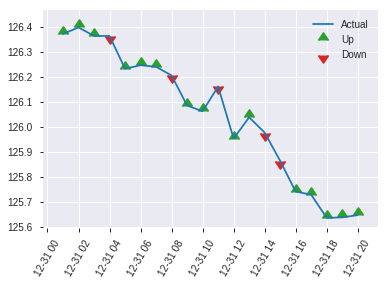


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20251708819499156
RMSE: 0.4500189864827834
LogLoss: 0.5925714153360654
Mean Per-Class Error: 0.2965747087766517
AUC: 0.7546417006602465
pr_auc: 0.7098815138341972
Gini: 0.509283401320493
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33730679750442505: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      146  170  0.538    (170.0/316.0)
1      37   264  0.1229   (37.0/301.0)
Total  183  434  0.3355   (207.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337307     0.718367  273
max f2                       0.136241     0.840832  366
max f0point5                 0.522353     0.700211  180
max accuracy                 0.522353     0.703404  180
max precision                0.805976     0.837838  29
max recall                   0.0806442    1         387
max specificity              0.945379     0.996835  0
max absolute_mcc             0.502356     0.406744  193
max min_per_class_accuracy   0.502356     0.702532  193
max mean_per_class_accuracy  0.502356     0.703425  193

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 47.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.91159            1.46417   1.46417            0.714286         0.926176  0.714286                    0.926176            0.0166113       0.0166113                  46.4167   46.4167
    2        0.0210697                   0.876403           1.36656   1.41912            0.666667         0.888716  0.692308                    0.908887            0.013289        0.0299003                  36.6556   41.9116
    3        0.0307942                   0.864359           1.70819   1.5104             0.833333         0.872028  0.736842                    0.897247            0.0166113       0.0465116                  70.8195   51.0404
    4        0.0405186                   0.839831           2.04983   1.63987            1                0.850352  0.8                         0.885992            0.0199336       0.0664452                  104.983   63.9867
    5        0.0502431                   0.825164           1.70819   1.65309            0.833333         0.834118  0.806452                    0.875952            0.0166113       0.0830565                  70.8195   65.3092
    6        0.100486                    0.747087           1.65309   1.65309            0.806452         0.786633  0.806452                    0.831292            0.0830565       0.166113                   65.3092   65.3092
    7        0.150729                    0.696362           1.58697   1.63105            0.774194         0.720574  0.795699                    0.794386            0.0797342       0.245847                   58.6968   63.1051
    8        0.200972                    0.66586            1.32247   1.55391            0.645161         0.680131  0.758065                    0.765822            0.0664452       0.312292                   32.2473   55.3906
    9        0.299838                    0.601106           1.57938   1.56231            0.770492         0.631302  0.762162                    0.721467            0.156146        0.468439                   57.938    56.2306
    10       0.400324                    0.549494           1.1241    1.45231            0.548387         0.575561  0.708502                    0.684843            0.112957        0.581395                   12.4102   45.2311
    11       0.50081                     0.498281           1.22329   1.40636            0.596774         0.52326   0.686084                    0.652422            0.122924        0.704319                   22.3288   40.6359
    12       0.599676                    0.437923           0.940907  1.32962            0.459016         0.466635  0.648649                    0.621792            0.0930233       0.797342                   -5.90926  32.9622
    13       0.700162                    0.338287           0.760422  1.24793            0.370968         0.390669  0.608796                    0.588622            0.076412        0.873754                   -23.9578  24.7931
    14       0.799028                    0.248758           0.537661  1.16005            0.262295         0.294856  0.565923                    0.552273            0.0531561       0.92691                    -46.2339  16.0048
    15       0.899514                    0.161816           0.462866  1.08216            0.225806         0.207721  0.527928                    0.513783            0.0465116       0.973422                   -53.7134  8.21646
    16       1                           0.0433076          0.264495  1                  0.129032         0.111239  0.487844                    0.473333         

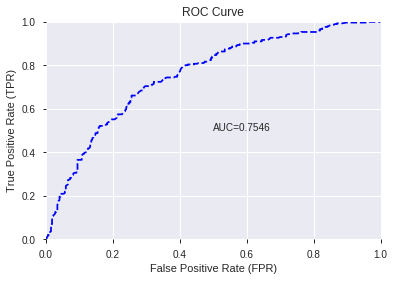

This function is available for GLM models only


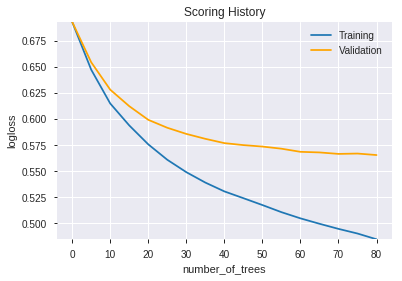

--2019-08-24 14:53:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.172
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.172|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_145306_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_145306_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'CCI_8',
 'STOCHRSI_fastk',
 'SUB',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'NATR_8',
 'Volume',
 'ADOSC',
 'ULTOSC',
 'WILLR_8',
 'WILLR_12',
 'WILLR_24',
 'CCI_12',
 'WILLR_14',
 'CCI_20',
 'CCI_14',
 'ROC_20',
 'STOCHRSI_fastd',
 'WILLR_30',
 'MINUS_DI_30',
 'CDLHAMMER',
 'MOM_12',
 'MINUS_DM_12',
 'MOM_20',
 'MOM_24',
 'CMO_30',
 'MINUS_DM_14',
 'MINUS_DM_8',
 'STOCH_slowk',
 'MOM_30',
 'CCI_30',
 'ROC_12',
 'ROC_8',
 'ROC_14',
 'CCI_24',
 'MOM_14',
 'MINUS_DI_12',
 'ATR_8',
 'CDLTAKURI',
 'ROC_30',
 'CDLBELTHOLD',
 'MINUS_DI_20',
 'MOM_8',
 'CMO_14',
 'CDLHIKKAKE',
 'aroondown_8',
 'MINUS_DI_24',
 'ROCP_30',
 'ROCP_14',
 'CMO_24',
 'WILLR_20',
 'CDLSHORTLINE',
 'STOCHF_fastd',
 'CMO_8',
 'ROC_24',
 'MINUS_DI_8',
 'aroondown_14',
 'MINUS_DI_14',
 'CMO_20',
 'ROCP_8',
 'RSI_8',
 'ROCP_20',
 'ROCR_12',
 'CDLDRAGONFLYDOJI',
 'ROCP_24',
 'RSI_24',
 'ROCR_8',
 'aroondown_12',
 'RSI_20',
 'CDLENGULFING',
 'RSI_30',
 'CMO_12',
 'ROCR_24',
 'ROCR_30',
 'ROCP_12

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

54

['BBANDS_middleband_8_2_2',
 'BBANDS_upperband_8_5_5',
 'BOP',
 'ADXR_8',
 'aroonup_8',
 'AROONOSC_8',
 'CCI_8',
 'DX_8',
 'MINUS_DM_8',
 'PLUS_DI_8',
 'WILLR_8',
 'MFI_12',
 'MINUS_DI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MFI_14',
 'ROCP_14',
 'WILLR_14',
 'aroondown_20',
 'CCI_20',
 'DX_20',
 'MACDFIX_signal_20',
 'PLUS_DI_20',
 'ROCR_20',
 'aroondown_24',
 'CCI_24',
 'PLUS_DI_24',
 'WILLR_24',
 'MOM_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'ATR_14',
 'ATR_24',
 'TRANGE',
 'HT_PHASOR_inphase',
 'CDLSPINNINGTOP',
 'BETA_8',
 'LINEARREG_SLOPE_8',
 'VAR_8',
 'LINEARREG_SLOPE_12',
 'CORREL_14',
 'BETA_24',
 'LINEARREG_ANGLE_30',
 'STDDEV_30',
 'TAN',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_145946_model_6  0.742125  0.599909              0.303708  0.452492  0.204749
1  DeepLearning_grid_1_AutoML_20190824_145946_model_9  0.741410  0.596457              0.322301  0.452533  0.204786
2  DeepLearning_grid_1_AutoML_20190824_145946_model_7  0.737915  0.631326              0.330607  0.463600  0.214925
3  DeepLearning_grid_1_AutoML_20190824_145946_model_5  0.737410  0.607130              0.335753  0.456823  0.208688
4               DeepLearning_1_AutoML_20190824_145946  0.733315  0.602260              0.308371  0.456419  0.208318
5  DeepLearning_grid_1_AutoML_20190824_145946_model_8  0.722339  0.627937              0.347145  0.465343  0.216544
6  DeepLearning_grid_1_AutoML_20190824_145946_model_2  0.710942  0.672644              0.330449  0.474914  0.225543
7  DeepLearning_grid_1_AutoML_20190824_145946_model_4  0.709344  0.679431              0.333141  0.477806  0.228299
8  DeepLearning_grid_1_AutoML_20190824_145946_model_3  0.699325  0.666923              0.349915  0.478145  0.228622
9  DeepLearning_grid_1_AutoML_20190824_145946_model_1  0.655158  0.745894              0.443590  0.505317  0.255346

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.060445
1              STOCHF_fastk             0.407968           0.407968    0.024660
2                       DIV             0.389960           0.389960    0.023571
3                    TRANGE             0.389487           0.389487    0.023543
4                   WILLR_8             0.389024           0.389024    0.023515
5                       SUB             0.378395           0.378395    0.022872
6            STOCHRSI_fastk             0.367392           0.367392    0.022207
7         MACDFIX_signal_20             0.332362           0.332362    0.020090
8                  WILLR_14             0.325689           0.325689    0.019686
9                     ADOSC             0.322950           0.322950    0.019521
10                   ULTOSC             0.321409           0.321409    0.019428
11                   ATR_24             0.317968           0.317968    0.019220
12                    CCI_8             0.310856           0.310856    0.018790
13                   ATR_14             0.302204           0.302204    0.018267
14                 WILLR_12             0.296840           0.296840    0.017943
15                   CCI_14             0.296722           0.296722    0.017935
16           STOCHRSI_fastd             0.296036           0.296036    0.017894
17                    VAR_8             0.294645           0.294645    0.017810
18                aroonup_8             0.292050           0.292050    0.017653
19  BBANDS_middleband_8_2_2             0.291789           0.291789    0.017637
20                   ADXR_8             0.291644           0.291644    0.017629
21   BBANDS_upperband_8_5_5             0.291448           0.291448    0.017617
22                   MOM_30             0.290954           0.290954    0.017587
23                    DX_20             0.287970           0.287970    0.017406
24                PLUS_DI_8             0.287185           0.287185    0.017359
25                     DX_8             0.285589           0.285589    0.017263
26                 WILLR_30             0.283292           0.283292    0.017124
27                STDDEV_30             0.279659           0.279659    0.016904
28             aroondown_24             0.278106           0.278106    0.016810
29                   CCI_20             0.276285           0.276285    0.016700
30       LINEARREG_SLOPE_12             0.273499           0.273499    0.016532
31                      TAN             0.273226           0.273226    0.016515
32                  BETA_24             0.273053           0.273053    0.016505
33                   BETA_8             0.272924           0.272924    0.016497
34           CDLSPINNINGTOP             0.272344           0.272344    0.016462
35       LINEARREG_ANGLE_30             0.269963           0.269963    0.016318
36               AROONOSC_8             0.269747           0.269747    0.016305
37                  ROCR_20             0.269724           0.269724    0.016304
38                 WILLR_24             0.269026           0.269026    0.016261
39              STOCH_slowk             0.268860           0.268860    0.016251
40                   CMO_14             0.268785           0.268785    0.016247
41        LINEARREG_SLOPE_8             0.268589           0.268589    0.016235
42                   CCI_24             0.268132           0.268132    0.016207
43                   MFI_12             0.267125           0.267125    0.016146
44               PLUS_DI_20             0.266566           0.266566    0.016113
45               MINUS_DM_8             0.264101           0.264101    0.015964
46              MINUS_DI_12             0.260395           0.260395    0.015740
47        HT_PHASOR_inphase             0.258272           0.258272    0.015611
48             aroondown_20             0.257346           0.257346    0.015555
49                 

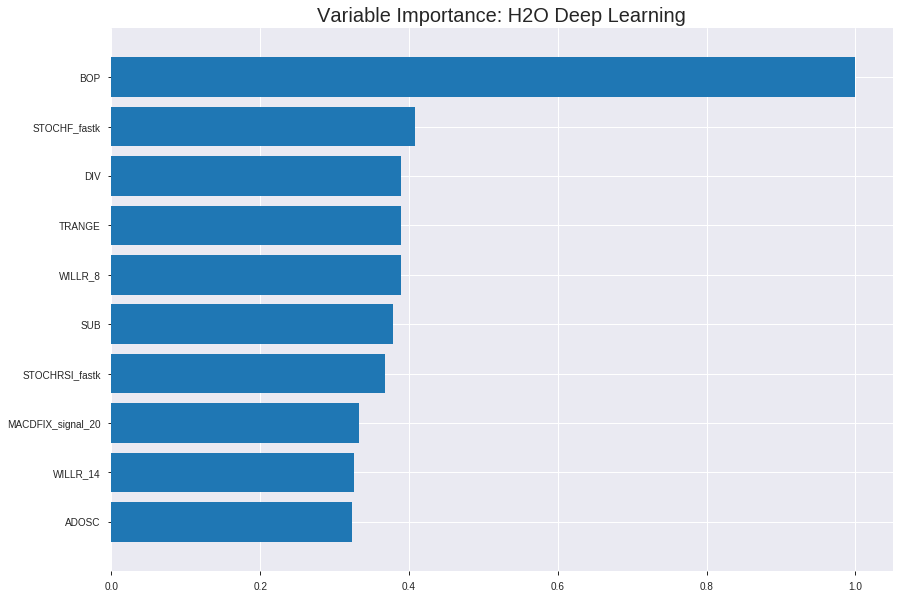

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_145946_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1948202450427186
RMSE: 0.44138446397978104
LogLoss: 0.5704983625425238
Mean Per-Class Error: 0.2939888307197378
AUC: 0.7714036991678551
pr_auc: 0.7287587371470223
Gini: 0.5428073983357102
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41649878989090877: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1172  1082  0.48     (1082.0/2254.0)
1      269   1793  0.1305   (269.0/2062.0)
Total  1441  2875  0.313    (1351.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416499     0.726352  233
max f2                       0.186697     0.840641  327
max f0point5                 0.617193     0.687432  139
max accuracy                 0.54391      0.703892  178
max precision                0.982417     1         0
max recall                   0.0320019    1         392
max specificity              0.982417     1         0
max absolute_mcc             0.439071     0.413478  224
max min_per_class_accuracy   0.575921     0.697866  161
max mean_per_class_accuracy  0.54391      0.706011  178

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 50.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.865795           1.85526   1.85526            0.886364         0.889805   0.886364                    0.889805            0.0189137       0.0189137                  85.526    85.526
    2        0.0201576                   0.844685           1.84973   1.85253            0.883721         0.853384   0.885057                    0.871804            0.0184287       0.0373424                  84.9728   85.2526
    3        0.0301205                   0.830454           1.80105   1.8355             0.860465         0.837275   0.876923                    0.860383            0.0179437       0.0552861                  80.1051   83.55
    4        0.0400834                   0.821346           1.75237   1.81484            0.837209         0.82604    0.867052                    0.851847            0.0174588       0.0727449                  75.2374   81.4838
    5        0.0500463                   0.813093           1.7037    1.79271            0.813953         0.817522   0.856481                    0.845013            0.0169738       0.0897187                  70.3697   79.2713
    6        0.100093                    0.778005           1.64736   1.72004            0.787037         0.79456    0.821759                    0.819787            0.0824442       0.172163                   64.7358   72.0035
    7        0.150139                    0.752021           1.56984   1.66997            0.75             0.765183   0.79784                     0.801585            0.0785645       0.250727                   56.9835   66.9969
    8        0.200185                    0.72533            1.51169   1.6304             0.722222         0.738585   0.778935                    0.785835            0.0756547       0.326382                   51.1693   63.04
    9        0.300046                    0.674606           1.39865   1.55327            0.668213         0.69938    0.742085                    0.757061            0.13967         0.466052                   39.8647   55.3268
    10       0.400139                    0.623652           1.29851   1.48954            0.62037          0.649731   0.711639                    0.730213            0.129971        0.596023                   29.8506   48.9541
    11       0.5                         0.569567           1.11212   1.41416            0.531323         0.59791    0.675626                    0.703789            0.111057        0.707081                   11.2118   41.4161
    12       0.600093                    0.485782           1.01749   1.348              0.486111         0.529944   0.644015                    0.674793            0.101843        0.808923                   1.74857   34.7997
    13       0.699954                    0.369552           0.820734  1.27277            0.392111         0.432733   0.608077                    0.640259            0.0819593       0.890883                   -17.9266  27.2774
    14       0.800046                    0.254329           0.56204   1.18385            0.268519         0.311453   0.565595                    0.599122            0.0562561       0.947139                   -43.796   18.3855
    15       0.899907                    0.14996            0.398226  1.09668            0.190255         0.200171   0.523944                    0.554851            0.0397672       0.986906                   -60.1774  9.66751
    16       1                           0.0032672          0.13082   1                  0.0625           0.0929409  0.477757                    0.50



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20195087543230433
RMSE: 0.44938944739758224
LogLoss: 0.584860836538524
Mean Per-Class Error: 0.3134313585760211
AUC: 0.7545291146056028
pr_auc: 0.7139436709028396
Gini: 0.5090582292112056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3304435768118791: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      279  372  0.5714   (372.0/651.0)
1      54   528  0.0928   (54.0/582.0)
Total  333  900  0.3455   (426.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330444     0.712551  270
max f2                       0.170036     0.837482  339
max f0point5                 0.630258     0.667331  130
max accuracy                 0.552501     0.684509  175
max precision                0.965469     1         0
max recall                   0.0819782    1         378
max specificity              0.965469     1         0
max absolute_mcc             0.330444     0.377549  270
max min_per_class_accuracy   0.574008     0.680412  163
max mean_per_class_accuracy  0.547021     0.686569  178

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 50.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.864317           1.79262   1.79262            0.846154         0.901911  0.846154                    0.901911            0.0189003       0.0189003                  79.2625   79.2625
    2        0.0202758                   0.841166           1.76546   1.77959            0.833333         0.853917  0.84                        0.878874            0.0171821       0.0360825                  76.5464   77.9588
    3        0.0300081                   0.82876            1.76546   1.77501            0.833333         0.834532  0.837838                    0.864493            0.0171821       0.0532646                  76.5464   77.5007
    4        0.0405515                   0.818413           1.95559   1.82196            0.923077         0.825373  0.86                        0.854322            0.0206186       0.0738832                  95.5591   82.1959
    5        0.0502839                   0.811721           2.11856   1.87936            1                0.814483  0.887097                    0.846611            0.0206186       0.0945017                  111.856   87.9365
    6        0.100568                    0.765111           1.74268   1.81102            0.822581         0.784378  0.854839                    0.815494            0.0876289       0.182131                   74.2684   81.1024
    7        0.150041                    0.738423           1.42395   1.68339            0.672131         0.752838  0.794595                    0.794835            0.0704467       0.252577                   42.3948   68.3394
    8        0.200324                    0.718739           1.29847   1.58677            0.612903         0.729273  0.748988                    0.778378            0.0652921       0.317869                   29.847    58.6773
    9        0.300081                    0.667297           1.41237   1.5288             0.666667         0.693449  0.721622                    0.750145            0.140893        0.458763                   41.2371   52.8796
    10       0.399838                    0.622629           1.24013   1.45678            0.585366         0.646671  0.687627                    0.724329            0.123711        0.582474                   24.0131   45.6776
    11       0.500406                    0.563892           1.11053   1.38719            0.524194         0.59648   0.654781                    0.698635            0.111684        0.694158                   11.0534   38.7191
    12       0.600162                    0.477601           0.878426  1.30263            0.414634         0.525099  0.614865                    0.66979             0.0876289       0.781787                   -12.1574  30.2626
    13       0.699919                    0.358302           0.947322  1.25199            0.447154         0.418378  0.590962                    0.633958            0.0945017       0.876289                   -5.26779  25.1986
    14       0.799676                    0.248891           0.671737  1.1796             0.317073         0.305051  0.556795                    0.592928            0.0670103       0.943299                   -32.8263  17.9602
    15       0.899432                    0.153678           0.413377  1.09462            0.195122         0.199186  0.516682                    0.549257            0.0412371       0.984536                   -58.6623  9.46195
    16       1                           0.00647088         0.153766  1                  0.0725806        0.092293  0.472019                    0.503302         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:06:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 15:06:59  4 min 50.947 sec  797 obs/sec       0.485867  1             2097       0.47567          0.684262            0.0931569      0.732485        0.676059           1.66498          0.358434                         0.477883           0.668934              0.0836415        0.72658           0.675556             1.95559            0.355231
    2019-08-24 15:07:19  5 min 11.451 sec  2073 obs/sec      10.1742   21            43912      0.441384         0.570498            0.219174       0.771404        0.728759           1.85526          0.313021                         0.449389           0.584861              0.189659         0.754529          0.713944             1.79262            0.345499
    2019-08-24 15:07:40  5 min 31.816 sec  2330 obs/sec      21.3587   44            92184      0.436631         0.560541            0.235902       0.780586        0.739454           1.85526          0.303985                         0.452022           0.594917              0.180135         0.748996          0.698686             1.62966            0.339011
    2019-08-24 15:08:00  5 min 51.963 sec  2464 obs/sec      32.9525   68            142223     0.435555         0.55786             0.239662       0.785524        0.749624           2.04554          0.298656                         0.452633           0.596458              0.177919         0.745818          0.698269             1.62966            0.351176
    2019-08-24 15:08:20  6 min 12.239 sec  2557 obs/sec      45.0259   93            194332     0.433493         0.553587            0.246846       0.794453        0.758342           1.99797          0.297498                         0.455393           0.599654              0.167863         0.746888          0.706396             1.79262            0.360908
    2019-08-24 15:08:41  6 min 32.899 sec  2647 obs/sec      58.079    120           250669     0.425144         0.535841            0.275578       0.806115        0.777141           1.99797          0.28962                          0.45323            0.595249              0.175747         0.745687          0.698959             1.79262            0.351176
    2019-08-24 15:09:01  6 min 53.275 sec  2718 obs/sec      71.1867   147           307242     0.419228         0.523314            0.295597       0.8146          0.786514           2.04554          0.269926                         0.456059           0.603137              0.165426         0.740728          0.690896             1.79262            0.34631
    2019-08-24 15:09:03  6 min 55.222 sec  2717 obs/sec      71.1867   147           307242     0.441384         0.570498            0.219174       0.771404        0.728759           1.85526          0.313021                         0.449389           0.584861              0.189659         0.754529          0.713944             1.79262            0.345499

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
BOP           1.0                    1.0                  0.06044540204696329
STOCHF_fastk  0.4079684913158417     0.4079684913158417   0.024659819480079104
DIV           0.38996022939682007    0.38996022939682007  0.023571302848216822
TRANGE        0.3894869089126587     0.3894869089126587   0.023542692801254626
WILLR_8       0.3890240490436554     0.3890240490436554   0.023514715050381316
---           ---                    ---                  ---
ROCP_14       0.25706005096435547    0.25706005096435547  0.01553809813075334
PLUS_DI_24    0.2559451758861542     0.2559451758861542   0.015470709058419324
MFI_14        0.2551392614841461     0.2551392614841461   0.015421995238374508
CORREL_14     0.25432655215263367    0.25432655215263367  0.01537287069608392
STOCHF_fastd  0.2538295090198517     0.2538295090198517   0.01534282672408823


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6969205834683955)

('F1', 0.733893557422969)

('auc', 0.7421254047689138)

('logloss', 0.5999091659811508)

('mean_per_class_error', 0.3032980781361706)

('rmse', 0.4524919386625802)

('mse', 0.20474895455462025)

deeplearning prediction progress: |███████████████████████████████████████| 100%


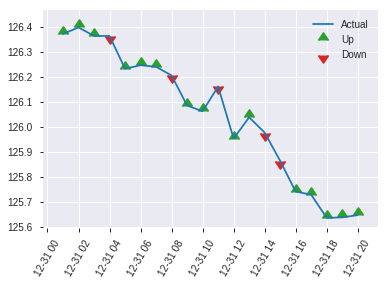


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20474895455462025
RMSE: 0.4524919386625802
LogLoss: 0.5999091659811508
Mean Per-Class Error: 0.3032980781361706
AUC: 0.7421254047689138
pr_auc: 0.6829647085344376
Gini: 0.4842508095378275
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4296639595787071: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      165  151  0.4778   (151.0/316.0)
1      39   262  0.1296   (39.0/301.0)
Total  204  413  0.3079   (190.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429664     0.733894  254
max f2                       0.188084     0.839022  351
max f0point5                 0.571472     0.68954   181
max accuracy                 0.571472     0.696921  181
max precision                0.834789     0.846154  8
max recall                   0.0304019    1         397
max specificity              0.952365     0.996835  0
max absolute_mcc             0.429664     0.417128  254
max min_per_class_accuracy   0.56488      0.693038  186
max mean_per_class_accuracy  0.571472     0.696702  181

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.851914           1.46417   1.46417            0.714286         0.876098  0.714286                    0.876098            0.0166113       0.0166113                  46.4167   46.4167
    2        0.0210697                   0.834526           2.04983   1.73447            1                0.845496  0.846154                    0.861974            0.0199336       0.0365449                  104.983   73.4475
    3        0.0307942                   0.825358           1.36656   1.61829            0.666667         0.830527  0.789474                    0.852043            0.013289        0.0498339                  36.6556   61.829
    4        0.0405186                   0.817857           1.70819   1.63987            0.833333         0.820643  0.8                         0.844507            0.0166113       0.0664452                  70.8195   63.9867
    5        0.0502431                   0.810282           1.36656   1.58697            0.666667         0.813283  0.774194                    0.838464            0.013289        0.0797342                  36.6556   58.6968
    6        0.100486                    0.776039           1.32247   1.45472            0.645161         0.792646  0.709677                    0.815555            0.0664452       0.146179                   32.2473   45.4721
    7        0.150729                    0.74907            1.58697   1.4988             0.774194         0.76347   0.731183                    0.798193            0.0797342       0.225914                   58.6968   49.8803
    8        0.200972                    0.724964           1.52084   1.50431            0.741935         0.736654  0.733871                    0.782808            0.076412        0.302326                   52.0844   50.4314
    9        0.299838                    0.664716           1.34415   1.4515             0.655738         0.691529  0.708108                    0.752711            0.13289         0.435216                   34.4153   45.1504
    10       0.400324                    0.615587           1.22329   1.39422            0.596774         0.64083   0.680162                    0.724627            0.122924        0.55814                    22.3288   39.4219
    11       0.50081                     0.562406           1.3886    1.39309            0.677419         0.593206  0.679612                    0.698258            0.139535        0.697674                   38.8597   39.3091
    12       0.599676                    0.499741           0.940907  1.31854            0.459016         0.534178  0.643243                    0.671207            0.0930233       0.790698                   -5.90926  31.8542
    13       0.700162                    0.393125           0.925731  1.26217            0.451613         0.447351  0.615741                    0.63908             0.0930233       0.883721                   -7.42686  26.2166
    14       0.799028                    0.258197           0.504058  1.16836            0.245902         0.322236  0.56998                     0.599876            0.0498339       0.933555                   -49.5942  16.8364
    15       0.899514                    0.184123           0.462866  1.08955            0.225806         0.223778  0.531532                    0.557861            0.0465116       0.980066                   -53.7134  8.95513
    16       1                           0.0200048          0.198371  1                  0.0967742        0.122189  0.487844                    0.514082          

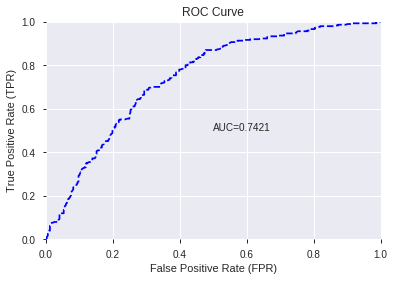

This function is available for GLM models only


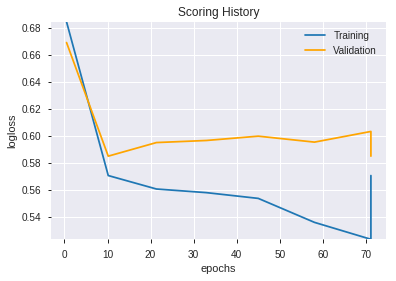

--2019-08-24 15:23:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_145946_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_145946_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'STOCHF_fastk',
 'DIV',
 'TRANGE',
 'WILLR_8',
 'SUB',
 'STOCHRSI_fastk',
 'MACDFIX_signal_20',
 'WILLR_14',
 'ADOSC',
 'ULTOSC',
 'ATR_24',
 'CCI_8',
 'ATR_14',
 'WILLR_12',
 'CCI_14',
 'STOCHRSI_fastd',
 'VAR_8',
 'aroonup_8',
 'BBANDS_middleband_8_2_2',
 'ADXR_8',
 'BBANDS_upperband_8_5_5',
 'MOM_30',
 'DX_20',
 'PLUS_DI_8',
 'DX_8',
 'WILLR_30',
 'STDDEV_30',
 'aroondown_24',
 'CCI_20',
 'LINEARREG_SLOPE_12',
 'TAN',
 'BETA_24',
 'BETA_8',
 'CDLSPINNINGTOP',
 'LINEARREG_ANGLE_30',
 'AROONOSC_8',
 'ROCR_20',
 'WILLR_24',
 'STOCH_slowk',
 'CMO_14',
 'LINEARREG_SLOPE_8',
 'CCI_24',
 'MFI_12',
 'PLUS_DI_20',
 'MINUS_DM_8',
 'MINUS_DI_12',
 'HT_PHASOR_inphase',
 'aroondown_20',
 'ROCP_14',
 'PLUS_DI_24',
 'MFI_14',
 'CORREL_14',
 'STOCHF_fastd']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_152431_model_1  0.74549  0.598023              0.299829  0.454175  0.206275

variable  relative_importance  scaled_importance  percentage
0                       SUB             3.090168           1.000000    0.155159
1                       DIV             2.944989           0.953019    0.147869
2                PLUS_DI_20             1.101160           0.356343    0.055290
3                    ATR_14             1.100974           0.356283    0.055280
4                PLUS_DI_24             0.984638           0.318636    0.049439
5                    ATR_24             0.851648           0.275599    0.042762
6                       BOP             0.813173           0.263148    0.040830
7                    CMO_14             0.563325           0.182296    0.028285
8    BBANDS_upperband_8_5_5             0.537935           0.174080    0.027010
9                MINUS_DM_8             0.510283           0.165131    0.025621
10       LINEARREG_ANGLE_30             0.448545           0.145152    0.022522
11                PLUS_DI_8             0.422875           0.136845    0.021233
12  BBANDS_middleband_8_2_2             0.414931           0.134275    0.020834
13           STOCHRSI_fastd             0.414142           0.134019    0.020794
14                  WILLR_8             0.407867           0.131989    0.020479
15                    CCI_8             0.391830           0.126799    0.019674
16             STOCHF_fastk             0.318607           0.103104    0.015997
17                   CCI_24             0.318295           0.103003    0.015982
18                 WILLR_30             0.303653           0.098264    0.015247
19                   TRANGE             0.265454           0.085903    0.013329
20           STOCHRSI_fastk             0.260065           0.084159    0.013058
21              STOCH_slowk             0.246377           0.079729    0.012371
22                  ROCR_20             0.236784           0.076625    0.011889
23             STOCHF_fastd             0.231607           0.074950    0.011629
24                 WILLR_12             0.215910           0.069870    0.010841
25              MINUS_DI_12             0.191478           0.061963    0.009614
26             aroondown_24             0.189937           0.061465    0.009537
27                  ROCP_14             0.185408           0.059999    0.009309
28                   CCI_14             0.182164           0.058950    0.009147
29                   CCI_20             0.172276           0.055750    0.008650
30       LINEARREG_SLOPE_12             0.152851           0.049464    0.007675
31               AROONOSC_8             0.151813           0.049128    0.007623
32                   ULTOSC             0.148232           0.047969    0.007443
33                   MFI_14             0.140841           0.045577    0.007072
34        MACDFIX_signal_20             0.129710           0.041975    0.006513
35                aroonup_8             0.120538           0.039007    0.006052
36                    ADOSC             0.112781           0.036497    0.005663
37             aroondown_20             0.093853           0.030372    0.004712
38                   BETA_8             0.084776           0.027434    0.004257
39        LINEARREG_SLOPE_8             0.076545           0.024770    0.003843
40                  BETA_24             0.058757           0.019014    0.002950
41                    DX_20             0.057229           0.018520    0.002873
42                   MOM_30             0.047807           0.015471    0.002400
43                 WILLR_14             0.042401           0.013721    0.002129
44        HT_PHASOR_inphase             0.034070           0.011025    0.001711
45                      TAN             0.033062           0.010699    0.001660
46                CORREL_14             0.031092           0.010062    0.001561
47                STDDEV_30             0.022329           0.007226    0.001121
48                   MFI_12             0.019341           0.006259    0.000971
49           CDLSPI

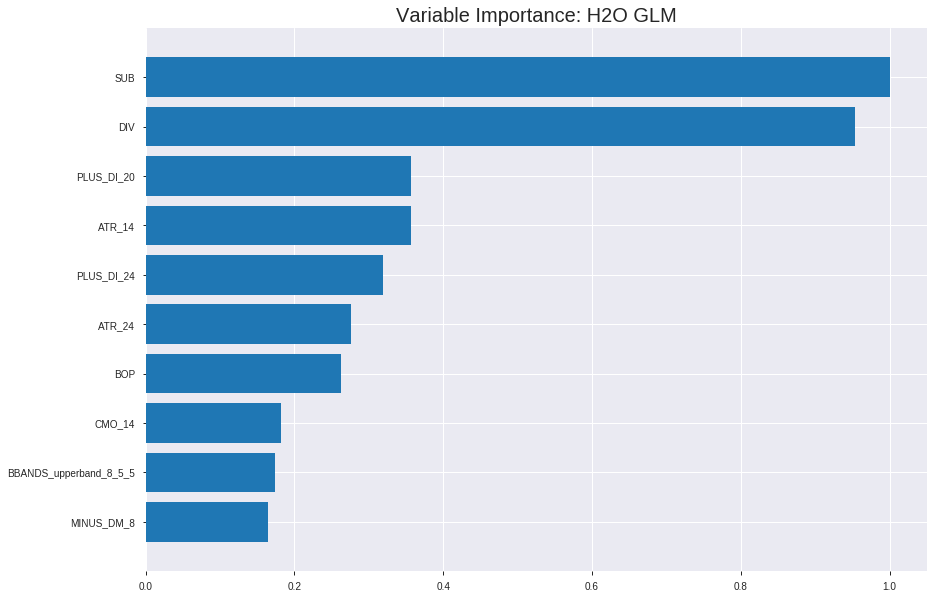

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_152431_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19303297760506083
RMSE: 0.43935518388322314
LogLoss: 0.567629446883948
Null degrees of freedom: 4315
Residual degrees of freedom: 4261
Null deviance: 5974.702401324418
Residual deviance: 4899.777385502239
AIC: 5009.777385502239
AUC: 0.7735553863935825
pr_auc: 0.727584087272116
Gini: 0.5471107727871649
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39580918076715965: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1325  929   0.4122   (929.0/2254.0)
1      344   1718  0.1668   (344.0/2062.0)
Total  1669  2647  0.2949   (1273.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395809     0.729667  235
max f2                       0.18813      0.838794  329
max f0point5                 0.488541     0.691539  192
max accuracy                 0.43416      0.708758  217
max precision                0.94747      1         0
max recall                   0.0398223    1         392
max specificity              0.94747      1         0
max absolute_mcc             0.399556     0.432784  233
max min_per_class_accuracy   0.503674     0.703201  185
max mean_per_class_accuracy  0.418147     0.712477  224

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 47.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.882555           1.90283   1.90283            0.909091         0.902367   0.909091                    0.902367            0.0193986       0.0193986                  90.283    90.283
    2        0.0201576                   0.863405           1.84973   1.87658            0.883721         0.873105   0.896552                    0.887904            0.0184287       0.0378274                  84.9728   87.6585
    3        0.0301205                   0.849481           1.75237   1.8355             0.837209         0.855583   0.876923                    0.877213            0.0174588       0.0552861                  75.2374   83.55
    4        0.0400834                   0.837946           1.65502   1.79064            0.790698         0.843579   0.855491                    0.868853            0.0164888       0.071775                   65.502    79.064
    5        0.0500463                   0.827998           1.7037    1.77333            0.813953         0.833413   0.847222                    0.861798            0.0169738       0.0887488                  70.3697   77.3332
    6        0.100093                    0.789089           1.58922   1.68127            0.759259         0.807685   0.803241                    0.834742            0.0795344       0.168283                   58.9216   68.1274
    7        0.150139                    0.753154           1.63767   1.66674            0.782407         0.769867   0.796296                    0.813117            0.0819593       0.250242                   63.7667   66.6739
    8        0.200185                    0.71867            1.51169   1.62798            0.722222         0.734989   0.777778                    0.793585            0.0756547       0.325897                   51.1693   62.7977
    9        0.300046                    0.649913           1.45207   1.56943            0.693735         0.683884   0.749807                    0.757075            0.145005        0.470902                   45.2067   56.9431
    10       0.400139                    0.571614           1.23067   1.48469            0.587963         0.612882   0.709323                    0.721006            0.123181        0.594083                   23.0673   48.4693
    11       0.5                         0.493487           1.2141    1.43065            0.580046         0.532671   0.683503                    0.683391            0.121242        0.715325                   21.4103   43.065
    12       0.600093                    0.404754           1.05625   1.3682             0.50463          0.448711   0.653668                    0.644248            0.105723        0.821048                   5.62471   36.8201
    13       0.699954                    0.310242           0.718749  1.27555            0.343387         0.360453   0.609401                    0.603759            0.071775        0.892823                   -28.1251  27.5545
    14       0.800046                    0.228393           0.57173   1.18749            0.273148         0.272785   0.567333                    0.562352            0.057226        0.950048                   -42.827   18.7492
    15       0.899907                    0.145027           0.344805  1.09398            0.164733         0.18542    0.522657                    0.520524            0.0344326       0.984481                   -65.5195  9.39805
    16       1                           0.00648471         0.155045  1                  0.0740741        0.0932572  0.477757                    0.47



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19865578799437536
RMSE: 0.4457081870398785
LogLoss: 0.5775342037719707
Null degrees of freedom: 1232
Residual degrees of freedom: 1178
Null deviance: 1705.6003649118566
Residual deviance: 1424.1993465016799
AIC: 1534.1993465016799
AUC: 0.7590080816718662
pr_auc: 0.7221261695416442
Gini: 0.5180161633437323
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3093451034769309: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      302  349  0.5361   (349.0/651.0)
1      62   520  0.1065   (62.0/582.0)
Total  364  869  0.3333   (411.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309345     0.716747  273
max f2                       0.219228     0.839832  314
max f0point5                 0.526082     0.67148   169
max accuracy                 0.526082     0.687753  169
max precision                0.922621     1         0
max recall                   0.0918231    1         373
max specificity              0.922621     1         0
max absolute_mcc             0.309345     0.391122  273
max min_per_class_accuracy   0.490652     0.682131  185
max mean_per_class_accuracy  0.444995     0.690421  209

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 46.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.890475           2.11856   2.11856            1                0.905438   1                           0.905438            0.0223368       0.0223368                  111.856   111.856
    2        0.0202758                   0.850859           1.94201   2.03381            0.916667         0.870883   0.96                        0.888851            0.0189003       0.0412371                  94.201    103.381
    3        0.0300081                   0.834513           1.76546   1.94678            0.833333         0.844339   0.918919                    0.874415            0.0171821       0.0584192                  76.5464   94.6782
    4        0.0405515                   0.826692           1.95559   1.94907            0.923077         0.830628   0.92                        0.86303             0.0206186       0.0790378                  95.5591   94.9072
    5        0.0502839                   0.81186            1.94201   1.94771            0.916667         0.817826   0.919355                    0.854281            0.0189003       0.0979381                  94.201    94.7705
    6        0.100568                    0.772483           1.606     1.77685            0.758065         0.789695   0.83871                     0.821988            0.080756        0.178694                   60.6003   77.6854
    7        0.150041                    0.741962           1.42395   1.66049            0.672131         0.757963   0.783784                    0.800877            0.0704467       0.249141                   42.3948   66.049
    8        0.200324                    0.706328           1.50349   1.62108            0.709677         0.723094   0.765182                    0.781353            0.0756014       0.324742                   50.3492   62.1082
    9        0.300081                    0.632222           1.37792   1.54025            0.650407         0.667576   0.727027                    0.743529            0.137457        0.462199                   37.7923   54.0248
    10       0.399838                    0.556              1.22291   1.46107            0.577236         0.594537   0.689655                    0.706357            0.121993        0.584192                   22.2907   46.1074
    11       0.500406                    0.478634           1.11053   1.39062            0.524194         0.518399   0.656402                    0.668583            0.111684        0.695876                   11.0534   39.0625
    12       0.600162                    0.401762           0.964546  1.3198             0.455285         0.442468   0.622973                    0.630999            0.0962199       0.792096                   -3.54539  31.9804
    13       0.699919                    0.315878           0.930098  1.26426            0.439024         0.356232   0.596756                    0.591837            0.0927835       0.88488                    -6.99019  26.426
    14       0.799676                    0.230609           0.637289  1.18605            0.300813         0.27317    0.559838                    0.552085            0.0635739       0.948454                   -36.2711  18.6048
    15       0.899432                    0.148349           0.361705  1.09462            0.170732         0.190547   0.516682                    0.511986            0.0360825       0.984536                   -63.8295  9.46195
    16       1                           0.0158842          0.153766  1                  0.0725806        0.0924898  0.472019                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 15:24:32  0.000 sec   2            .21E2     55            1.3692216776042476  1.3710068920699332
     2019-08-24 15:24:32  0.028 sec   4            .13E2     55            1.3620392567834863  1.3650199417492253
     2019-08-24 15:24:32  0.056 sec   6            .8E1      55            1.3523097505741175  1.3567414616967566
     2019-08-24 15:24:32  0.084 sec   8            .49E1     55            1.3395765509373119  1.345603089467643
     2019-08-24 15:24:32  0.113 sec   10           .31E1     55            1.3234152763749767  1.331032338221703
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 15:24:32  0.686 sec   48           .14E-3    55            1.1365625040973193  1.1556075529647236
     2019-08-24 15:24:32  0.719 sec   50           .86E-4    55            1.1361099646138555  1.1554295730479025
     2019-08-24 15:24:32  0.737 sec   51           .54E-4    55            1.1358537547670882  1.1553109836446662
     2019-08-24 15:24:32  0.774 sec   53           .33E-4    55            1.1354384279690575  1.1551333905018883
     2019-08-24 15:24:32  0.805 sec   54           .21E-4    55            1.135258893767896   1.1550684075439415


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6969205834683955)

('F1', 0.7285921625544268)

('auc', 0.745489717818243)

('logloss', 0.5980232384547013)

('mean_per_class_error', 0.2998286303040498)

('rmse', 0.45417495529799795)

('mse', 0.20627489001993846)

glm prediction progress: |████████████████████████████████████████████████| 100%


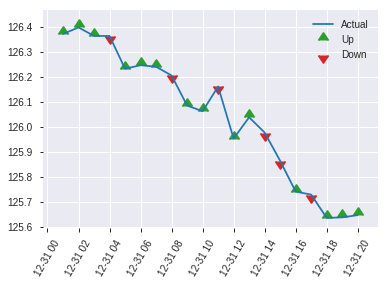


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20627489001993846
RMSE: 0.45417495529799795
LogLoss: 0.5980232384547013
Null degrees of freedom: 616
Residual degrees of freedom: 562
Null deviance: 855.2304056881629
Residual deviance: 737.9606762531014
AIC: 847.9606762531014
AUC: 0.745489717818243
pr_auc: 0.7131196584762582
Gini: 0.49097943563648605
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35044302945938866: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      179  137  0.4335   (137.0/316.0)
1      50   251  0.1661   (50.0/301.0)
Total  229  388  0.3031   (187.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350443     0.728592  247
max f2                       0.101031     0.835196  372
max f0point5                 0.479096     0.679478  183
max accuracy                 0.36597      0.696921  241
max precision                0.917961     1         0
max recall                   0.0745337    1         384
max specificity              0.917961     1         0
max absolute_mcc             0.350443     0.414214  247
max min_per_class_accuracy   0.462516     0.683544  193
max mean_per_class_accuracy  0.350443     0.700171  247

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 45.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.869355           2.04983   2.04983            1                0.89038   1                           0.89038             0.0232558       0.0232558                  104.983   104.983
    2        0.0210697                   0.845491           1.70819   1.89215            0.833333         0.851589  0.923077                    0.872477            0.0166113       0.0398671                  70.8195   89.2154
    3        0.0307942                   0.840056           2.04983   1.94195            1                0.843182  0.947368                    0.863226            0.0199336       0.0598007                  104.983   94.1948
    4        0.0405186                   0.827092           1.36656   1.80385            0.666667         0.834207  0.88                        0.856261            0.013289        0.0730897                  36.6556   80.3854
    5        0.0502431                   0.812453           1.70819   1.78534            0.833333         0.821476  0.870968                    0.849529            0.0166113       0.089701                   70.8195   78.5339
    6        0.100486                    0.760917           1.32247   1.55391            0.645161         0.781569  0.758065                    0.815549            0.0664452       0.156146                   32.2473   55.3906
    7        0.150729                    0.725144           1.65309   1.58697            0.806452         0.743433  0.774194                    0.79151             0.0830565       0.239203                   65.3092   58.6968
    8        0.200972                    0.698466           1.52084   1.57044            0.741935         0.712805  0.766129                    0.771834            0.076412        0.315615                   52.0844   57.0437
    9        0.299838                    0.617671           1.24334   1.46258            0.606557         0.653585  0.713514                    0.732844            0.122924        0.438538                   24.3342   46.2584
    10       0.400324                    0.536602           1.19023   1.39422            0.580645         0.576017  0.680162                    0.693478            0.119601        0.55814                    19.0226   39.4219
    11       0.50081                     0.457276           1.25635   1.36656            0.612903         0.495349  0.666667                    0.653724            0.126246        0.684385                   25.635    36.6556
    12       0.599676                    0.370346           1.14253   1.32962            0.557377         0.411493  0.648649                    0.613789            0.112957        0.797342                   14.253    32.9622
    13       0.700162                    0.289037           0.89267   1.26691            0.435484         0.331854  0.618056                    0.573326            0.089701        0.887043                   -10.733   26.6911
    14       0.799028                    0.198774           0.43685   1.16421            0.213115         0.24771   0.567951                    0.533037            0.0431894       0.930233                   -56.315   16.4206
    15       0.899514                    0.134194           0.396742  1.07847            0.193548         0.165562  0.526126                    0.491985            0.0398671       0.9701                     -60.3258  7.84712
    16       1                           0.0136521          0.297557  1                  0.145161         0.092298  0.487844                    0.451822         

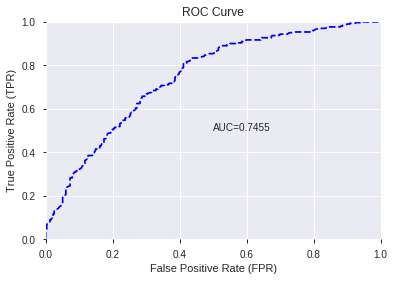

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


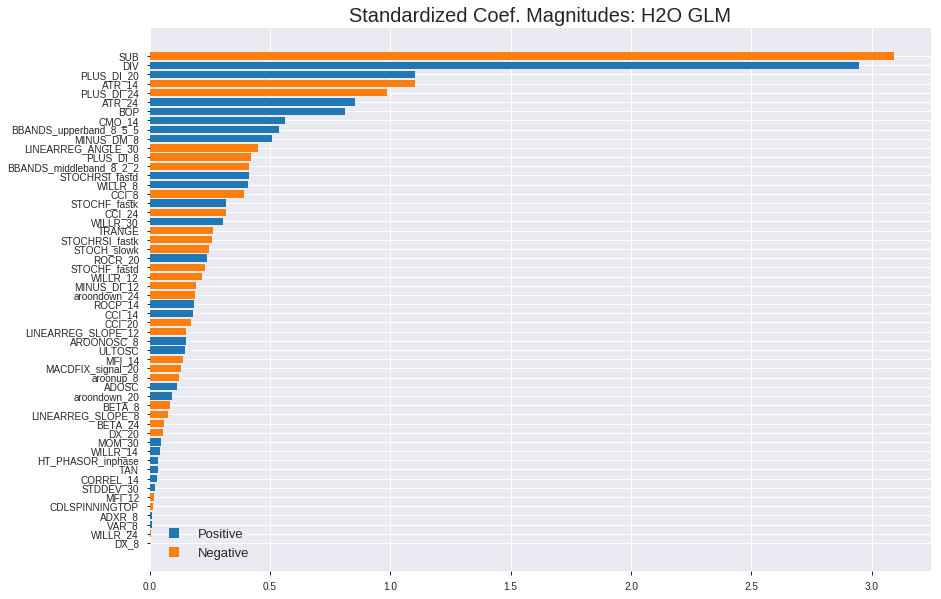

'log_likelihood'
--2019-08-24 15:24:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_152431_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_152431_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['SUB',
 'DIV',
 'PLUS_DI_20',
 'ATR_14',
 'PLUS_DI_24',
 'ATR_24',
 'BOP',
 'CMO_14',
 'BBANDS_upperband_8_5_5',
 'MINUS_DM_8',
 'LINEARREG_ANGLE_30',
 'PLUS_DI_8',
 'BBANDS_middleband_8_2_2',
 'STOCHRSI_fastd',
 'WILLR_8',
 'CCI_8',
 'STOCHF_fastk',
 'CCI_24',
 'WILLR_30',
 'TRANGE',
 'STOCHRSI_fastk',
 'STOCH_slowk',
 'ROCR_20',
 'STOCHF_fastd',
 'WILLR_12',
 'MINUS_DI_12',
 'aroondown_24',
 'ROCP_14',
 'CCI_14',
 'CCI_20',
 'LINEARREG_SLOPE_12',
 'AROONOSC_8',
 'ULTOSC',
 'MFI_14',
 'MACDFIX_signal_20',
 'aroonup_8',
 'ADOSC',
 'aroondown_20',
 'BETA_8',
 'LINEARREG_SLOPE_8',
 'BETA_24',
 'DX_20',
 'MOM_30',
 'WILLR_14',
 'HT_PHASOR_inphase',
 'TAN',
 'CORREL_14',
 'STDDEV_30',
 'MFI_12',
 'CDLSPINNINGTOP',
 'ADXR_8',
 'VAR_8',
 'WILLR_24',
 'DX_8']

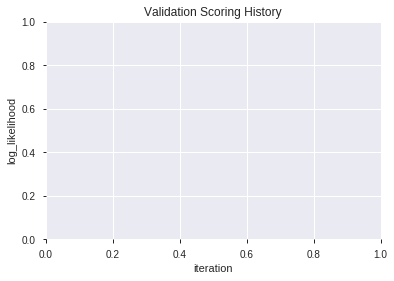

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_152539  0.749133  0.594004              0.338997  0.451354  0.203721
1  XGBoost_grid_1_AutoML_20190824_152539_model_4  0.748155  0.593050              0.337572  0.451271  0.203646
2  XGBoost_grid_1_AutoML_20190824_152539_model_6  0.745984  0.596358              0.331558  0.452065  0.204362
3  XGBoost_grid_1_AutoML_20190824_152539_model_1  0.745637  0.597601              0.338997  0.453017  0.205224
4  XGBoost_grid_1_AutoML_20190824_152539_model_3  0.740433  0.600812              0.310905  0.454191  0.206290
5               XGBoost_2_AutoML_20190824_152539  0.738356  0.599668              0.311698  0.454219  0.206315
6  XGBoost_grid_1_AutoML_20190824_152539_model_2  0.738151  0.601526              0.310983  0.455059  0.207079
7               XGBoost_1_AutoML_20190824_152539  0.730718  0.609926              0.318974  0.458370  0.210103
8  XGBoost_grid_1_AutoML_20190824_152539_model_5  0.727117  0.620663              0.345878  0.462327  0.213746
9  XGBoost_grid_1_AutoML_20190824_152539_model_7  0.721261  0.620201              0.338282  0.462810  0.214194

variable  relative_importance  scaled_importance  percentage
0                       BOP          5258.555664           1.000000    0.311968
1            STOCHRSI_fastk          1128.052979           0.214518    0.066923
2              STOCHF_fastk          1059.319824           0.201447    0.062845
3                    TRANGE           761.304016           0.144774    0.045165
4                     CCI_8           425.207886           0.080860    0.025226
5                       SUB           410.415039           0.078047    0.024348
6                       DIV           369.333344           0.070235    0.021911
7                     ADOSC           342.415924           0.065116    0.020314
8                 PLUS_DI_8           306.135559           0.058217    0.018162
9         LINEARREG_SLOPE_8           298.094330           0.056687    0.017685
10                  WILLR_8           295.944214           0.056279    0.017557
11                CORREL_14           279.156372           0.053086    0.016561
12                aroonup_8           239.012726           0.045452    0.014180
13                    DX_20           230.563507           0.043845    0.013678
14                   ATR_14           229.328995           0.043611    0.013605
15                  ROCR_20           221.584564           0.042138    0.013146
16                  ROCP_14           214.405518           0.040773    0.012720
17                   ULTOSC           212.423386           0.040396    0.012602
18                 WILLR_30           206.665176           0.039301    0.012261
19                    VAR_8           201.253708           0.038272    0.011940
20                  BETA_24           190.592712           0.036244    0.011307
21                   BETA_8           187.139542           0.035588    0.011102
22                 WILLR_24           183.702835           0.034934    0.010898
23   BBANDS_upperband_8_5_5           180.374481           0.034301    0.010701
24           STOCHRSI_fastd           172.639084           0.032830    0.010242
25                      TAN           172.062180           0.032720    0.010208
26       LINEARREG_ANGLE_30           170.441254           0.032412    0.010112
27                   CCI_14           169.004471           0.032139    0.010026
28                   ATR_24           162.409866           0.030885    0.009635
29                   CCI_20           155.939880           0.029655    0.009251
30               MINUS_DM_8           154.492752           0.029379    0.009165
31              STOCH_slowk           145.850266           0.027736    0.008653
32                 WILLR_14           144.476120           0.027474    0.008571
33        HT_PHASOR_inphase           137.412949           0.026131    0.008152
34                   MFI_12           135.610840           0.025789    0.008045
35                 WILLR_12           134.179810           0.025516    0.007960
36        MACDFIX_signal_20           133.887390           0.025461    0.007943
37                   ADXR_8           131.045242           0.024920    0.007774
38                STDDEV_30           128.526703           0.024441    0.007625
39               PLUS_DI_24           116.498169           0.022154    0.006911
40                   MOM_30           109.609680           0.020844    0.006503
41       LINEARREG_SLOPE_12           105.410957           0.020046    0.006254
42  BBANDS_middleband_8_2_2            99.563667           0.018934    0.005907
43                     DX_8            98.317924           0.018697    0.005833
44               PLUS_DI_20            95.463982           0.018154    0.005663
45              MINUS_DI_12            88.646072           0.016857    0.005259
46                   MFI_14            85.011154           0.016166    0.005043
47                   CCI_24            84.179184           0.016008    0.004994
48             aroondown_24            81.694962           0.015536    0.004847
49                 

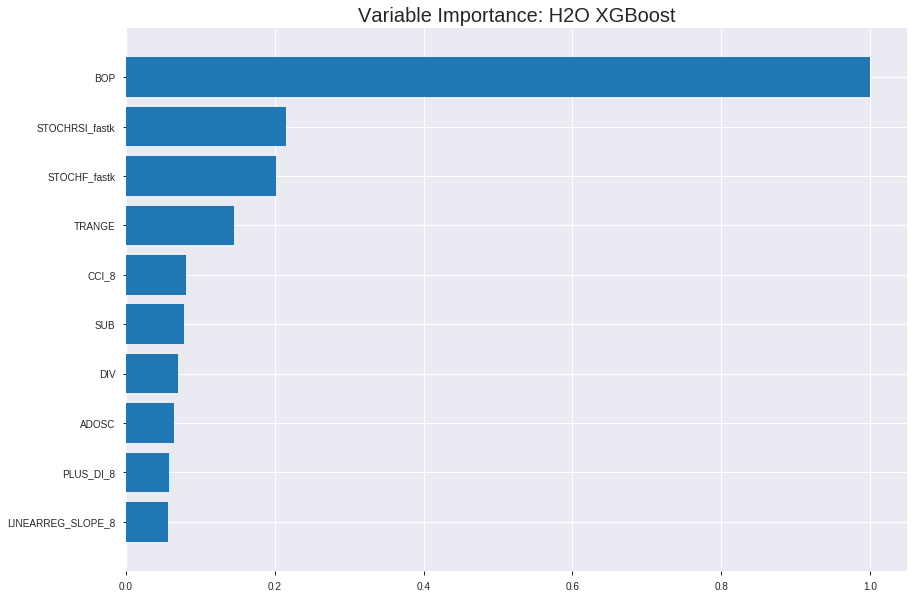

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_152539


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1564748828979801
RMSE: 0.39556906210923537
LogLoss: 0.48196608165106486
Mean Per-Class Error: 0.21809401026045294
AUC: 0.8726041084843671
pr_auc: 0.8664514813675013
Gini: 0.7452082169687342
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4190896779298782: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1448  806   0.3576   (806.0/2254.0)
1      221   1841  0.1072   (221.0/2062.0)
Total  1669  2647  0.238    (1027.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41909      0.781907  233
max f2                       0.285342     0.870625  292
max f0point5                 0.588553     0.792418  153
max accuracy                 0.563931     0.784523  166
max precision                0.959063     1         0
max recall                   0.119533     1         365
max specificity              0.959063     1         0
max absolute_mcc             0.563931     0.56908   166
max min_per_class_accuracy   0.523545     0.777728  184
max mean_per_class_accuracy  0.563931     0.781906  166

Gains/Lift Table: Avg response rate: 47.78 %, avg score: 47.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.907236           2.09311    2.09311            1                0.925787   1                           0.925787            0.0213385       0.0213385                  109.311   109.311
    2        0.0201576                   0.880313           2.09311    2.09311            1                0.894535   1                           0.91034             0.0208535       0.042192                   109.311   109.311
    3        0.0301205                   0.860779           2.09311    2.09311            1                0.87009    1                           0.897027            0.0208535       0.0630456                  109.311   109.311
    4        0.0400834                   0.842748           2.09311    2.09311            1                0.850543   1                           0.885473            0.0208535       0.0838991                  109.311   109.311
    5        0.0500463                   0.818968           2.04444    2.08342            0.976744         0.831019   0.99537                     0.874633            0.0203686       0.104268                   104.444   108.342
    6        0.100093                    0.7537             2.03497    2.0592             0.972222         0.780494   0.983796                    0.827563            0.101843        0.206111                   103.497   105.92
    7        0.150139                    0.71409            1.909      2.00913            0.912037         0.731147   0.959877                    0.795425            0.0955383       0.301649                   90.8997   100.913
    8        0.200185                    0.681382           1.85085    1.96956            0.884259         0.696548   0.940972                    0.770706            0.0926285       0.394277                   85.0855   96.9562
    9        0.300046                    0.634449           1.55405    1.83127            0.742459         0.657883   0.874903                    0.733156            0.155189        0.549467                   55.4052   83.1272
    10       0.400139                    0.580339           1.36149    1.71376            0.650463         0.607927   0.818761                    0.701831            0.136275        0.685742                   36.1493   71.3759
    11       0.5                         0.514503           1.03442    1.57808            0.4942           0.549281   0.753939                    0.671363            0.103298        0.78904                    3.44157   57.808
    12       0.600093                    0.431062           0.915737   1.4676             0.4375           0.473291   0.701158                    0.638326            0.0916586       0.880698                   -8.42629  46.7604
    13       0.699954                    0.334086           0.655616   1.35176            0.313225         0.383794   0.645813                    0.602012            0.0654704       0.946169                   -34.4384  35.1759
    14       0.800046                    0.242217           0.363388   1.22811            0.173611         0.286454   0.586736                    0.562533            0.0363725       0.982541                   -63.6612  22.8105
    15       0.899907                    0.14141            0.160262   1.10961            0.0765661        0.18942    0.530124                    0.521129            0.0160039       0.998545                   -83.9738  10.9609
    16       1                           0.039932           0.0145355  1                  0.00694444       0.0991914  0.477757   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1949937272946279
RMSE: 0.4415809408190393
LogLoss: 0.5712982262052657
Mean Per-Class Error: 0.2918863920692987
AUC: 0.7693873026430392
pr_auc: 0.7306754156561956
Gini: 0.5387746052860785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30305109918117523: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      278  373  0.573    (373.0/651.0)
1      51   531  0.0876   (51.0/582.0)
Total  329  904  0.3439   (424.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303051     0.71467   285
max f2                       0.196764     0.835067  334
max f0point5                 0.520403     0.68907   190
max accuracy                 0.515682     0.708029  193
max precision                0.896776     0.933333  11
max recall                   0.0770863    1         387
max specificity              0.952468     0.998464  0
max absolute_mcc             0.515682     0.41566   193
max min_per_class_accuracy   0.515682     0.706605  193
max mean_per_class_accuracy  0.515682     0.708114  193

Gains/Lift Table: Avg response rate: 47.20 %, avg score: 47.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.90127            1.95559   1.95559            0.923077         0.922727  0.923077                    0.922727            0.0206186       0.0206186                  95.5591   95.5591
    2        0.0202758                   0.877289           1.94201   1.94907            0.916667         0.887169  0.92                        0.905659            0.0189003       0.0395189                  94.201    94.9072
    3        0.0300081                   0.863847           1.58892   1.83227            0.75             0.871104  0.864865                    0.894452            0.0154639       0.0549828                  58.8918   83.2265
    4        0.0405515                   0.828212           2.11856   1.9067             1                0.847692  0.9                         0.882294            0.0223368       0.0773196                  111.856   90.6701
    5        0.0502839                   0.806193           1.58892   1.84519            0.75             0.816387  0.870968                    0.869538            0.0154639       0.0927835                  58.8918   84.5195
    6        0.100568                    0.736553           1.81102   1.82811            0.854839         0.764319  0.862903                    0.816929            0.0910653       0.183849                   81.1024   82.8109
    7        0.150041                    0.70278            1.52814   1.7292             0.721311         0.719163  0.816216                    0.784693            0.0756014       0.25945                    52.8139   72.92
    8        0.200324                    0.670762           1.46932   1.66397            0.693548         0.684832  0.785425                    0.759626            0.0738832       0.333333                   46.9322   66.3968
    9        0.300081                    0.622858           1.3607    1.56315            0.642276         0.646801  0.737838                    0.72212             0.135739        0.469072                   36.0699   56.3151
    10       0.399838                    0.568839           1.24013   1.48256            0.585366         0.595997  0.699797                    0.690653            0.123711        0.592784                   24.0131   48.256
    11       0.500406                    0.506289           1.24721   1.43526            0.58871          0.538614  0.677472                    0.660097            0.12543         0.718213                   24.7215   43.5262
    12       0.600162                    0.42853            0.861202  1.33984            0.406504         0.469103  0.632432                    0.628351            0.0859107       0.804124                   -13.8798  33.9844
    13       0.699919                    0.334472           0.792306  1.26181            0.373984         0.385416  0.595597                    0.593726            0.0790378       0.883162                   -20.7694  26.1805
    14       0.799676                    0.234799           0.516721  1.16886            0.243902         0.285402  0.551724                    0.555264            0.0515464       0.934708                   -48.3279  16.8859
    15       0.899432                    0.146091           0.465049  1.0908             0.219512         0.190205  0.514878                    0.514775            0.0463918       0.9811                     -53.4951  9.07988
    16       1                           0.0438818          0.187936  1                  0.0887097        0.100914  0.472019                    0.473154            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:25:46  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.522243                         0.5                0.693147              0.5               0                    1                  0.527981
    2019-08-24 15:25:46  0.098 sec   5                  0.475378         0.644797            0.804908        0.766727           2.00768          0.294717                         0.480328           0.654312              0.750078          0.703655             1.96723            0.3382
    2019-08-24 15:25:46  0.165 sec   10                 0.45917          0.613259            0.814507        0.790334           2.09311          0.283364                         0.467987           0.629885              0.758137          0.724157             1.95559            0.351987
    2019-08-24 15:25:46  0.240 sec   15                 0.447153         0.589565            0.82243         0.801988           2.09311          0.280816                         0.46               0.613546              0.76085           0.724464             1.95559            0.347932
    2019-08-24 15:25:46  0.320 sec   20                 0.43844          0.571894            0.826002        0.80633            2.09311          0.27734                          0.454802           0.602453              0.761698          0.725226             1.95559            0.34631
    2019-08-24 15:25:46  0.404 sec   25                 0.430974         0.556356            0.829308        0.810937           2.09311          0.271779                         0.450704           0.593348              0.762649          0.725262             1.79262            0.3382
    2019-08-24 15:25:46  0.483 sec   30                 0.42534          0.544343            0.834075        0.817203           2.09311          0.268767                         0.4475             0.58625               0.765934          0.727628             1.79262            0.337388
    2019-08-24 15:25:46  0.568 sec   35                 0.420246         0.533478            0.83903         0.825486           2.09311          0.268536                         0.446196           0.5829                0.765002          0.724948             1.79262            0.336577
    2019-08-24 15:25:47  0.653 sec   40                 0.415521         0.523485            0.844649        0.832422           2.09311          0.262048                         0.444882           0.579557              0.765393          0.726826             1.95559            0.343066
    2019-08-24 15:25:47  0.737 sec   45                 0.411917         0.515942            0.849408        0.838347           2.09311          0.252085                         0.443984           0.577296              0.766161          0.726755             1.95559            0.312247
    2019-08-24 15:25:47  0.823 sec   50                 0.408757         0.509036            0.853525        0.844056           2.09311          0.243744                         0.443391           0.57557               0.766243          0.727666             1.95559            0.340633
    2019-08-24 15:25:47  0.918 sec   55                 0.406029         0.503196            0.856809        0.847806           2.09311          0.244439                         0.442981           0.574531              0.766817          0.7277

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             5258.5556640625        1.0                    0.3119675152729251
STOCHRSI_fastk  1128.052978515625      0.2145176452585361     0.0669225367735043
STOCHF_fastk    1059.31982421875       0.20144691658552719    0.06284489402657913
TRANGE          761.3040161132812      0.14477435720916862    0.04516489649377923
CCI_8           425.2078857421875      0.08086020438047296    0.02522575704503705
---             ---                    ---                    ---
CMO_14          74.62902069091797      0.014191923687513708   0.004427419169736621
CDLSPINNINGTOP  57.33518981933594      0.010903220101133551   0.0034014504834244453
STOCHF_fastd    32.17499542236328      0.0061185993793410704  0.0019088042453234955
aroondown_20    26.1602783203125       0.004974802967114046   0.0015519769206229445
AROONOSC_8      22.443754196166992     0.004268045377849639   0.0013314915115998447


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6888168557536467)

('F1', 0.7215686274509805)

('auc', 0.7491326380419698)

('logloss', 0.5940043830203191)

('mean_per_class_error', 0.3094747466251735)

('rmse', 0.45135411753837107)

('mse', 0.2037205394188417)

xgboost prediction progress: |████████████████████████████████████████████| 100%


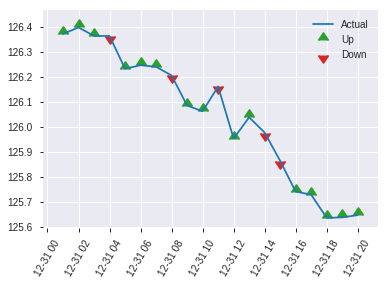


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2037205394188417
RMSE: 0.45135411753837107
LogLoss: 0.5940043830203191
Mean Per-Class Error: 0.3094747466251735
AUC: 0.7491326380419698
pr_auc: 0.6950413106722929
Gini: 0.49826527608393967
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3090708255767822: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  188  0.5949   (188.0/316.0)
1      25   276  0.0831   (25.0/301.0)
Total  153  464  0.3452   (213.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309071     0.721569  291
max f2                       0.262687     0.840682  313
max f0point5                 0.533398     0.68323   179
max accuracy                 0.533398     0.688817  179
max precision                0.863261     0.8       12
max recall                   0.124664     1         380
max specificity              0.936402     0.996835  0
max absolute_mcc             0.429424     0.390779  234
max min_per_class_accuracy   0.513022     0.674419  189
max mean_per_class_accuracy  0.465549     0.690525  217

Gains/Lift Table: Avg response rate: 48.78 %, avg score: 47.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.891291           1.46417   1.46417            0.714286         0.913174  0.714286                    0.913174            0.0166113       0.0166113                  46.4167   46.4167
    2        0.0210697                   0.866863           1.70819   1.5768             0.833333         0.875455  0.769231                    0.895765            0.0166113       0.0332226                  70.8195   57.6795
    3        0.0307942                   0.844254           1.02492   1.40252            0.5              0.85438   0.684211                    0.882696            0.00996678      0.0431894                  2.49169   40.2518
    4        0.0405186                   0.824645           2.04983   1.55787            1                0.837221  0.76                        0.871782            0.0199336       0.0631229                  104.983   55.7874
    5        0.0502431                   0.789697           1.36656   1.52084            0.666667         0.806535  0.741935                    0.859154            0.013289        0.076412                   36.6556   52.0844
    6        0.100486                    0.73235            1.58697   1.55391            0.774194         0.757329  0.758065                    0.808241            0.0797342       0.156146                   58.6968   55.3906
    7        0.150729                    0.681502           1.45472   1.52084            0.709677         0.707021  0.741935                    0.774501            0.0730897       0.229236                   45.4721   52.0844
    8        0.200972                    0.658816           1.52084   1.52084            0.741935         0.670616  0.741935                    0.74853             0.076412        0.305648                   52.0844   52.0844
    9        0.299838                    0.616004           1.51217   1.51799            0.737705         0.638361  0.740541                    0.712204            0.149502        0.45515                    51.2173   51.7985
    10       0.400324                    0.568354           1.19023   1.43571            0.580645         0.59231   0.700405                    0.682109            0.119601        0.574751                   19.0226   43.5714
    11       0.50081                     0.507097           1.09104   1.36656            0.532258         0.539732  0.666667                    0.653541            0.109635        0.684385                   9.10406   36.6556
    12       0.599676                    0.436345           1.00812   1.30746            0.491803         0.474781  0.637838                    0.62407             0.0996678       0.784053                   0.811503  30.7462
    13       0.700162                    0.340663           0.826546  1.23844            0.403226         0.394328  0.604167                    0.591098            0.0830565       0.86711                    -17.3454  23.8441
    14       0.799028                    0.264367           0.806492  1.185              0.393443         0.305353  0.578093                    0.555742            0.0797342       0.946844                   -19.3508  18.4995
    15       0.899514                    0.176794           0.231433  1.07847            0.112903         0.219889  0.526126                    0.518223            0.0232558       0.9701                     -76.8567  7.84712
    16       1                           0.0472712          0.297557  1                  0.145161         0.123693  0.487844                    0.478578         

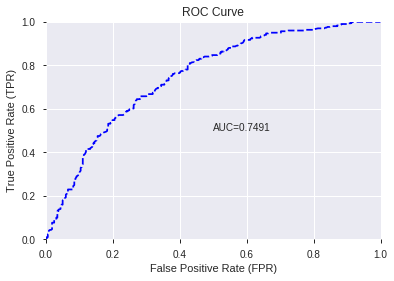

This function is available for GLM models only


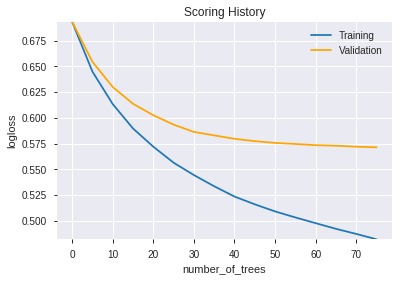

--2019-08-24 15:26:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_152539',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_152539',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_baad',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_baad',
   'ty

['BOP',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'TRANGE',
 'CCI_8',
 'SUB',
 'DIV',
 'ADOSC',
 'PLUS_DI_8',
 'LINEARREG_SLOPE_8',
 'WILLR_8',
 'CORREL_14',
 'aroonup_8',
 'DX_20',
 'ATR_14',
 'ROCR_20',
 'ROCP_14',
 'ULTOSC',
 'WILLR_30',
 'VAR_8',
 'BETA_24',
 'BETA_8',
 'WILLR_24',
 'BBANDS_upperband_8_5_5',
 'STOCHRSI_fastd',
 'TAN',
 'LINEARREG_ANGLE_30',
 'CCI_14',
 'ATR_24',
 'CCI_20',
 'MINUS_DM_8',
 'STOCH_slowk',
 'WILLR_14',
 'HT_PHASOR_inphase',
 'MFI_12',
 'WILLR_12',
 'MACDFIX_signal_20',
 'ADXR_8',
 'STDDEV_30',
 'PLUS_DI_24',
 'MOM_30',
 'LINEARREG_SLOPE_12',
 'BBANDS_middleband_8_2_2',
 'DX_8',
 'PLUS_DI_20',
 'MINUS_DI_12',
 'MFI_14',
 'CCI_24',
 'aroondown_24',
 'CMO_14',
 'CDLSPINNINGTOP',
 'STOCHF_fastd',
 'aroondown_20',
 'AROONOSC_8']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.710
GLM             0.705
XGBoost         0.703
dtype: float64

DeepLearning    GLM  XGBoost
All          0.710  0.705    0.689
DLF          0.697  0.689    0.702
Fwe          0.695  0.689    0.703
RFE          0.697  0.697    0.689
XGBF         0.692  0.689    0.702





F1


DeepLearning    0.734
GLM             0.729
XGBoost         0.726
dtype: float64

DeepLearning    GLM  XGBoost
All          0.731  0.718    0.720
DLF          0.716  0.727    0.726
Fwe          0.721  0.719    0.718
RFE          0.734  0.729    0.722
XGBF         0.721  0.727    0.726





auc


DeepLearning    0.748
GLM             0.749
XGBoost         0.758
dtype: float64

DeepLearning    GLM  XGBoost
All          0.748  0.744    0.751
DLF          0.745  0.749    0.758
Fwe          0.742  0.740    0.755
RFE          0.742  0.745    0.749
XGBF         0.744  0.749    0.758





logloss


DeepLearning    0.640
GLM             0.607
XGBoost         0.594
dtype: float64

DeepLearning    GLM  XGBoost
All          0.640  0.607    0.590
DLF          0.601  0.596    0.587
Fwe          0.607  0.600    0.593
RFE          0.600  0.598    0.594
XGBF         0.598  0.596    0.587





mean_per_class_error


DeepLearning    0.305
GLM             0.311
XGBoost         0.310
dtype: float64

DeepLearning    GLM  XGBoost
All          0.289  0.295    0.310
DLF          0.301  0.311    0.297
Fwe          0.303  0.311    0.297
RFE          0.303  0.300    0.309
XGBF         0.305  0.311    0.297





rmse


DeepLearning    0.474
GLM             0.458
XGBoost         0.451
dtype: float64

DeepLearning    GLM  XGBoost
All          0.474  0.458    0.450
DLF          0.455  0.452    0.449
Fwe          0.456  0.455    0.450
RFE          0.452  0.454    0.451
XGBF         0.454  0.452    0.449





mse


DeepLearning    0.225
GLM             0.210
XGBoost         0.204
dtype: float64

DeepLearning    GLM  XGBoost
All          0.225  0.210    0.203
DLF          0.207  0.205    0.201
Fwe          0.208  0.207    0.203
RFE          0.205  0.206    0.204
XGBF         0.206  0.205    0.201

{'F1':       DeepLearning    GLM  XGBoost
 All          0.731    NaN      NaN
 DLF          0.716    NaN      NaN
 DLF            NaN  0.727      NaN
 DLF            NaN    NaN    0.726
 All            NaN  0.718      NaN
 All            NaN    NaN    0.720
 XGBF         0.721    NaN      NaN
 XGBF           NaN  0.727      NaN
 XGBF           NaN    NaN    0.726
 Fwe          0.721    NaN      NaN
 Fwe            NaN  0.719      NaN
 Fwe            NaN    NaN    0.718
 RFE          0.734    NaN      NaN
 RFE            NaN  0.729      NaN
 RFE            NaN    NaN    0.722,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.710    NaN      NaN
 DLF          0.697    NaN      NaN
 DLF            NaN  0.689      NaN
 DLF            NaN    NaN    0.702
 All            NaN  0.705      NaN
 All            NaN    NaN    0.689
 XGBF         0.692    NaN      NaN
 XGBF           NaN  0.689      NaN
 XGBF           NaN    NaN    0.702
 Fwe          0.695    NaN      NaN
 Fwe     